# Predicción del precio de alquiler de la vivienda en la ciudad de Barcelona

Descripción del dataset:

|Columna|Descripción|Key|
|--|--|--|
|id|Identificador numérico de la vivienda||
|price|Precio de mercado de la vivienda||
|currency|Moneda|Euros / Mes|
|latitude|Latitud de las coordenadas geográficas de la vivienda||
|longitude|Longitud de las coordenadas geográficas de la vivienda||
|sq_meters|Metros cuadrados de la vivienda||
|sq_meters_built|Metros cuadrados construídos de la vivienda||
|rooms|Número de habitaciones||
|bathrooms|Número de baños||
|balcony|Indicador si la vivienda tiene balcón|1, 0|
|terrace|Indicador si la vivienda tiene terraza|1, 0|
|exterior|Indicador si la vivienda tiene una orientación exterior o interior en el edificio|1, 0|
|orientation|Orientación principal de la vivienda|norte, sur, este, oeste|
|floor|Piso de la vivienda||
|rooftop|Indicador si la vivienda es un ático|1, 0|
|elevator|Indicador si el edificio de la vivienda tiene ascensor|1, 0|
|doorman|Indicador si el edificio tiene portero|1,0|
|pool|Indicador si la vivienda cuenta con piscina o derecho de uso de piscina|1,0|
|ac|Indicador si tiene aire acondicionado|1,0|
|heating|Indicador si tiene calefacción|bomba, electric, gas, individual|
|year_built|Año de construcción||
|quality|Indicador de calidad de la vivienda|2 - En buen estado|
|city|Ciudad de la vivienda||
|neighborhood|Barrio de la vivienda||
|dist_city_center|Distancia en kilómetros al centro de la ciudad||
|furniture|Indicador si la vivienda cuenta con mobiliario|1: Sin Equipar; 2: Cocina Equipada; 3: Amueblado|
|garage|Indicador si la vivienda tiene garage|1, 0|
|property_type|Tipo de vivienda||
|garden|Indicador si la vivienda cuenta con jardín|1,0|
|closest_station|Nombre de la estación de metro más cercana||
|dist_closest_station|Distancia en kilómetros a la estación de metro más cercana||
|created_at|Fecha de creación del anuncio||
|last_seen|Fecha última en la que el anuncio fue publicado en la web||



#### Carga de librerías y dataset

In [176]:
# Library load
import os
import pandas as pd
import numpy as np

# Plotting library
import seaborn as sn
import matplotlib.pyplot as plt

# Funciones para hacer cálculo estadístico
import statsmodels.api as sm
from statsmodels.formula.api import ols

# sklearn packages
from sklearn.preprocessing import StandardScaler # Análisis de PCA
from sklearn import metrics # Calcula métricas para un modelo
from sklearn import tree # Cálculo de decision trees
from sklearn.tree import DecisionTreeClassifier # Generación de modelos de decision tree
from sklearn.ensemble import BaggingClassifier # Generación de modelos de bagging
from sklearn.ensemble import RandomForestClassifier # Generación de modelo de random forest
from sklearn.ensemble import GradientBoostingRegressor # Generación de modelo de gradient boosting
from sklearn.ensemble import StackingRegressor # Generación de modelo de gradient boosting
from sklearn.model_selection import train_test_split # Hace split entre training y testing
from sklearn.model_selection import cross_validate # trains model with cross validation
from sklearn.model_selection import GridSearchCV # Optimización de hiperparámetros para un modelo
from sklearn.preprocessing import OneHotEncoder # One Hot encoding de las variables categóricas

# Catboost & shap 
import catboost
import shap
# print the JS visualization code to the notebook 
shap.initjs()

# Confusion matrix viz
from mlxtend.evaluate import confusion_matrix # Calcula la matriz de confusion 
from mlxtend.plotting import plot_confusion_matrix #plot de la matriz de confusión

# Ignoring warning messages
import warnings
warnings.filterwarnings('ignore') #ignora los errores en el notebook

In [52]:
raw_data = pd.read_csv('input/processed_renting_Barcelona.csv', delimiter = ',')
raw_data.head()

,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,...,neighborhood,dist_city_center,furniture,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen
0,536625,850,€/mes,41.401708,2.154077,52.0,55,2,1,NaN,...,Gràcia,2.026455,3.0,NaN,piso,NaN,Fontana,0.094111,9/1/2021 15:58,10/4/2021 6:01
1,545910,725,€/mes,41.407221,2.135569,32.0,37,2,1,1.0,...,Sant Gervasi - La Bonanova,3.582409,NaN,NaN,piso,NaN,Vallcarca,0.902561,9/2/2021 15:24,9/8/2021 12:29
2,570697,950,€/mes,41.411508,2.164608,NaN,72,3,1,NaN,...,El Baix Guinardó,2.663025,3.0,NaN,piso,NaN,Alfons X,0.188177,8/28/2021 23:52,8/28/2021 23:52
3,591588,750,€/mes,41.402256,2.140764,NaN,45,1,1,1.0,...,Sant Gervasi - La Bonanova,2.910067,3.0,NaN,piso,NaN,Lesseps,0.892917,8/29/2021 11:25,9/8/2021 12:29
4,610243,990,€/mes,41.405327,2.146929,NaN,45,1,1,NaN,...,Sarrià-Sant Gervasi,2.727149,3.0,NaN,piso,NaN,Lesseps,0.293784,8/30/2021 13:48,8/30/2021 14:04


# Ejemplo de modelo de Bagging

Retiramos las variables que no nos importan para el modelo

In [53]:
rent_dataset = raw_data[['price', 'sq_meters_built', 'rooms', 'bathrooms', 'balcony', 'terrace', 'exterior', 'orientation', 'floor', 'rooftop', 'elevator', 'pool', 'ac', 'heating', 'year_built', 'neighborhood', 'dist_city_center', 'property_type', 'dist_closest_station']]
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station
0,850,55,2,1,NaN,NaN,1.0,norte,2.0,NaN,0.0,NaN,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111
1,725,37,2,1,1.0,NaN,1.0,sur,3.0,NaN,1.0,NaN,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561
2,950,72,3,1,NaN,NaN,1.0,NaN,4.0,NaN,1.0,NaN,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177
3,750,45,1,1,1.0,NaN,1.0,norte,4.0,NaN,1.0,NaN,NaN,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917
4,990,45,1,1,NaN,NaN,1.0,sur,3.0,NaN,1.0,NaN,NaN,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784


Podemos asumir que para algunas de las variables, los valores nulos son en realidad 0:

In [54]:
features_to_null = ['balcony', 'terrace', 'exterior', 'rooftop', 'elevator', 'pool', 'ac']
   rent_dataset[features_to_null[i]].fillna(0, inplace = True) 
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,0.0,0.0,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,1.0,0.0,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,1.0,0.0,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784


Para otras, como por ejemplo la property_age, podemos transformarla a una variable categórica incluyendo los valores nulos como una categoría de unknown:

In [55]:
rent_dataset['property_age'] = 2022 - rent_dataset['year_built']
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,0.0,0.0,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111,NaN
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,1.0,0.0,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,1.0,0.0,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN


array([[<AxesSubplot:title={'center':'property_age'}>]], dtype=object)

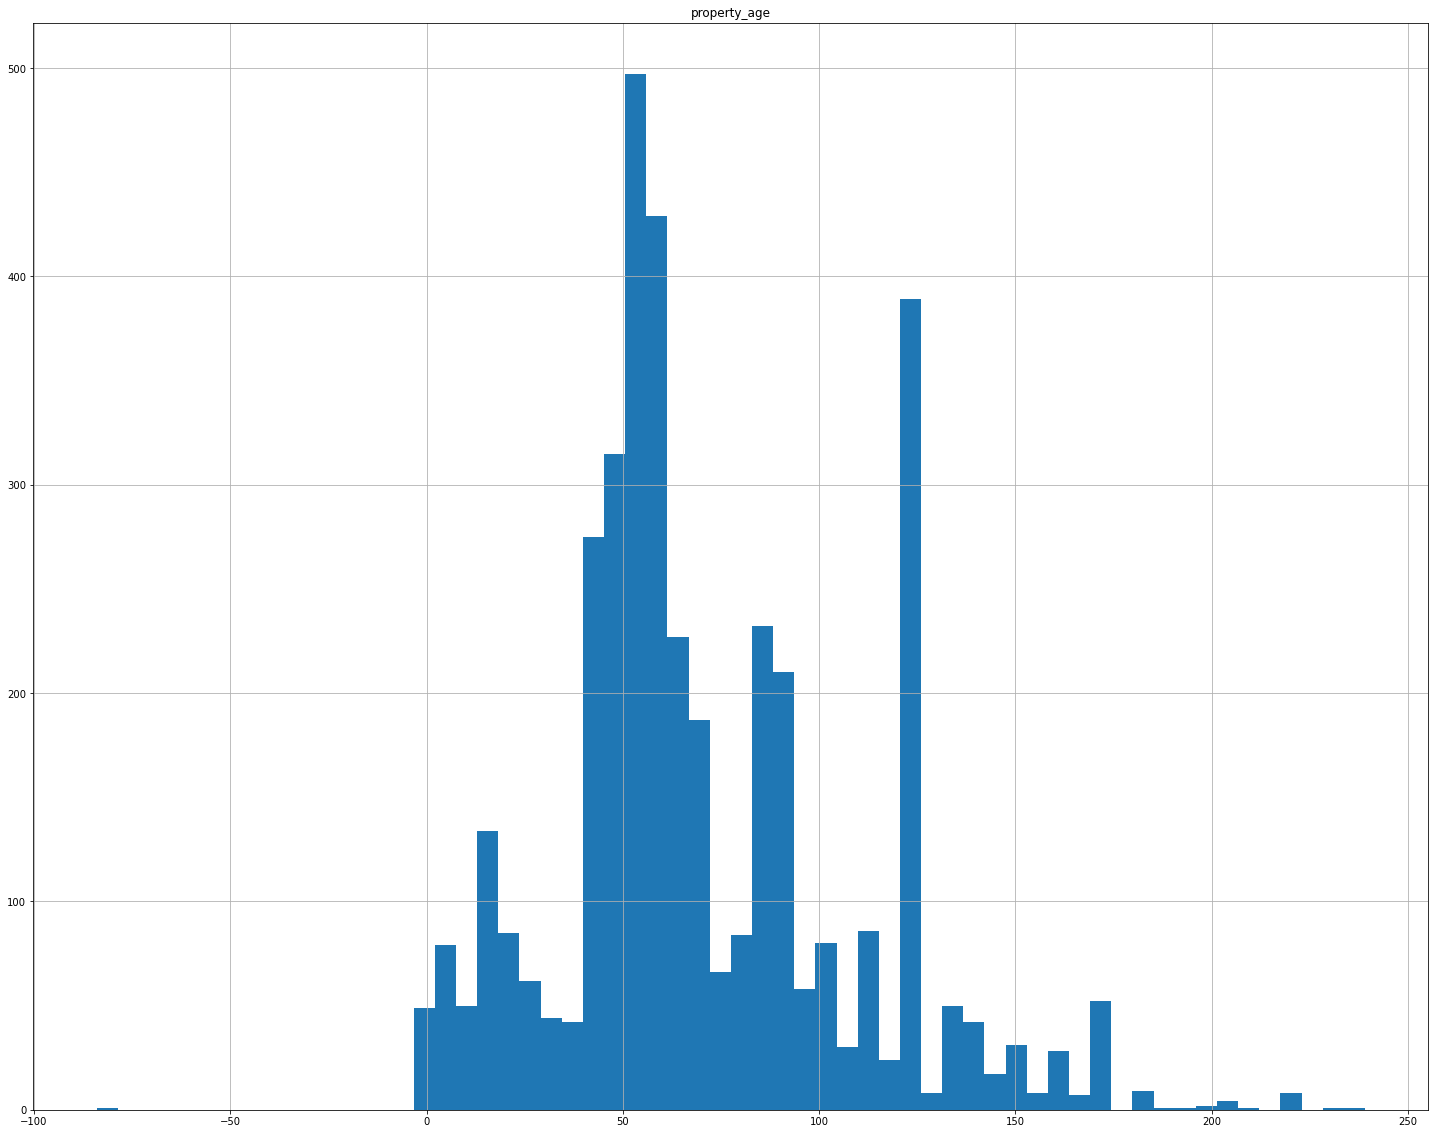

In [56]:
# Scatter matrix, similar a la función pairs. Cuidado que solo sive para variables numéricas
rent_dataset[['property_age']].hist(bins=60, figsize=(25, 20))

Apreciamos pequeños "clusters de viviendas, los cuales podemos agrupar en categorías según la edad de la vivienda:

In [57]:
def conditions(x):
    if x < 0:
        return "Unknown"
    elif ((x >= 0) & (x < 40)):
        return "0 - 40"
    elif ((x >= 40) & (x < 70)):
        return "40 - 70"
    elif ((x >= 70) & (x < 120)):
        return "70 - 120"
    elif ((x >= 120) & (x < 150)):
        return "120 - 150"
    elif ((x >= 150)):
        return "+150"
    else:
        return "Unknown"

func = np.vectorize(conditions)
rent_dataset['property_age_cat'] = func(rent_dataset['property_age'])
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,...,pool,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age,property_age_cat
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,...,0.0,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111,NaN,Unknown
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,...,0.0,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0,40 - 70
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,...,0.0,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN,Unknown
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,...,0.0,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0,70 - 120
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,...,0.0,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN,Unknown


Del dataset que tenemos, generamos un subset con valores numéricos únicamente:

In [58]:
cat_features = ['neighborhood', 'property_type', 'orientation', 'heating', 'property_age_cat']
rent_dataset_numeric = rent_dataset.drop(cat_features, axis = 1)
rent_dataset_numeric

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,pool,ac,year_built,dist_city_center,dist_closest_station,property_age
0,850,55,2,1,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,NaN,2.026455,0.094111,NaN
1,725,37,2,1,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,1962.0,3.582409,0.902561,60.0
2,950,72,3,1,0.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,NaN,2.663025,0.188177,NaN
3,750,45,1,1,1.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1936.0,2.910067,0.892917,86.0
4,990,45,1,1,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,NaN,2.727149,0.293784,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,907,49,0,1,0.0,1.0,1.0,9.0,0.0,1.0,0.0,0.0,1966.0,1.317748,0.285426,56.0
8498,950,125,1,1,0.0,0.0,0.0,NaN,0.0,1.0,0.0,1.0,1997.0,4.063099,0.534462,25.0
8499,950,48,2,1,0.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0,1890.0,0.288753,0.261938,132.0
8500,926,51,2,1,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,NaN,3.909033,0.545561,NaN


Comprobamos que no hay nulls

In [59]:
rent_dataset_numeric_no_nulls = rent_dataset_numeric.drop(['year_built', 'property_age', 'floor'], axis = 1)
rent_dataset_numeric_no_nulls.isnull().sum() / len(rent_dataset_numeric_no_nulls)

price                   0.0
sq_meters_built         0.0
rooms                   0.0
bathrooms               0.0
balcony                 0.0
terrace                 0.0
exterior                0.0
rooftop                 0.0
elevator                0.0
pool                    0.0
ac                      0.0
dist_city_center        0.0
dist_closest_station    0.0
dtype: float64

Generamos el split

In [60]:
X = rent_dataset_numeric_no_nulls.drop(['price'], axis = 1)
y = rent_dataset_numeric_no_nulls[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

Ejemplos de scoring parameter: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

En este caso optamos por un R2.

Hacemos grid search con cross validation para encontrar los parámetros óptimos de nuestro modelo

In [61]:
# we enumerate the values to try
parameters = [{"max_depth":[2,3,4,5,6,7,9], "min_samples_split":[2,5,10]}]

#instantiate the classifier
decision_tree_model = DecisionTreeClassifier()

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=decision_tree_model, param_grid=parameters, scoring="r2")
grid_bag.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 9],
                          'min_samples_split': [2, 5, 10]}],
             scoring='r2')

In [62]:
grid_bag.best_params_

{'max_depth': 9, 'min_samples_split': 10}

In [63]:
# we enumerate the values to try
parameters = {"n_estimators":[1,5,10,20,50,100,200]}

#instantiate the classifier
decision_tree_model = DecisionTreeClassifier(max_depth = 9, min_samples_split = 10)

#instantiate the classifier
bagging_model = BaggingClassifier(decision_tree_model)

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=bagging_model, param_grid=parameters, scoring="r2")
grid_bag.fit(X_train, y_train)
grid_bag.best_params_

{'n_estimators': 100}

A continuación, con los parámetros óptimos del modelo, procedemos a hacer un xvalidation para entender la performance del modelo:

In [64]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
bag = BaggingClassifier(DecisionTreeClassifier(max_depth = 9, min_samples_split = 10), n_estimators = 200)
# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model = cross_validate(bag, X_train, y_train, cv = 10, scoring = "r2")

In [65]:
for i, score in enumerate(model["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: 0.5286525781866775
Accuracy for the fold no. 1 on the test set: 0.25880174339626805
Accuracy for the fold no. 2 on the test set: 0.661423636449699
Accuracy for the fold no. 3 on the test set: 0.44913249510402553
Accuracy for the fold no. 4 on the test set: 0.7784820759896598
Accuracy for the fold no. 5 on the test set: 0.6889179101509166
Accuracy for the fold no. 6 on the test set: 0.7239496862432133
Accuracy for the fold no. 7 on the test set: 0.3412988182727055
Accuracy for the fold no. 8 on the test set: 0.4619171220209449
Accuracy for the fold no. 9 on the test set: 0.45345752927807137


Nos encontramos con que hay mucha variación con los datos de entrenamiento (R2 de 0.35 o de 0.74). Ésto nos indica que hay mucha variación en los datos y que probablemente tengamos outlayers o grupos de instancias que no estamos prediciendo correctamente

{'whiskers': [<matplotlib.lines.Line2D at 0x1f9d26ebd30>,
 'caps': [<matplotlib.lines.Line2D at 0x1f9e16e1af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f9e15b1f10>],
 'medians': [<matplotlib.lines.Line2D at 0x1f9e16e14f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f9e16e1a00>],
 'means': []}

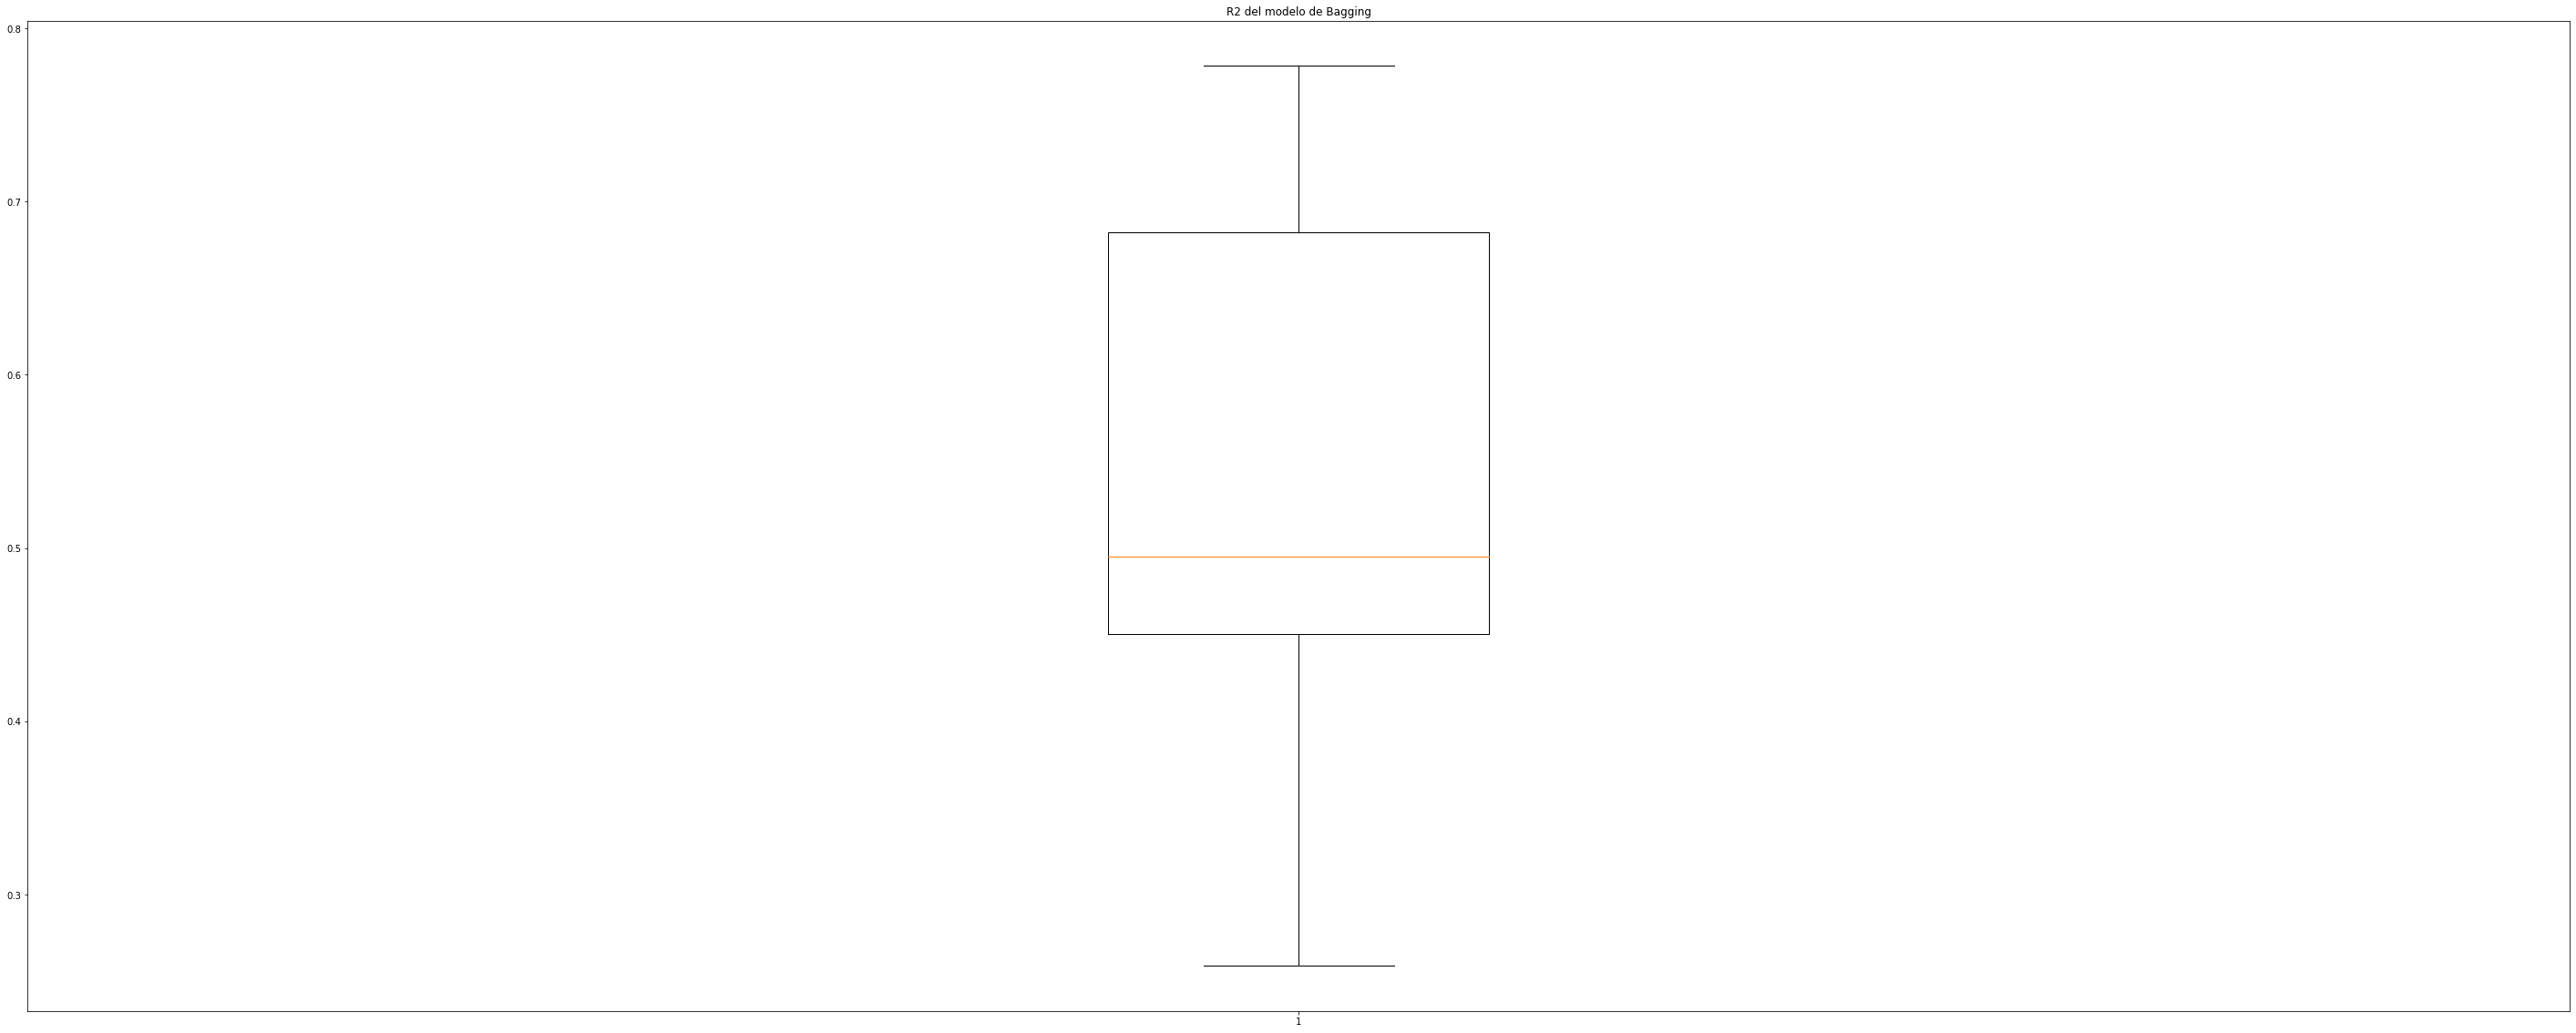

In [66]:
fig1, ax1 = plt.subplots()
ax1.set_title('R2 del modelo de Bagging')
ax1.boxplot(model["test_score"])

Generamos las predicciones y calculamos el resultado de validación:

In [67]:
bag = BaggingClassifier(DecisionTreeClassifier(max_depth = 9, min_samples_split = 10), n_estimators = 20)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=9,
                                                        min_samples_split=10),
                  n_estimators=20)

Error del modelo:

In [68]:
y_pred = bag.predict(X_train)
#error rate
metrics.r2_score(y_train, y_pred)

0.7430770929232244

Error en validación

In [69]:
y_pred = bag.predict(X_test)
#error rate
metrics.r2_score(y_test, y_pred)

0.5583691961694922

# Ejemplo Working Lab Sesión 2: One-hot encoding, Random Forest y comparación de modelos

En primer lugar generamos un diccionario para almacenar los resultados obtenidos de todos los modelos que generemos

In [70]:
# Definimos 2 diccionarios vacíos
cv = {}
results = pd.DataFrame(columns=['model','median_r2_cv_training','r2_validation'])
# Almacenamos los resultados para el modelo decision_tree_bagging
cv['decision_tree_bagging'] = model["test_score"]
cv

{'decision_tree_bagging': array([0.52865258, 0.25880174, 0.66142364, 0.4491325 , 0.77848208,
        0.68891791, 0.72394969, 0.34129882, 0.46191712, 0.45345753])}

In [71]:
results = pd.DataFrame(columns=['model','median_r2_cv_training','r2_validation'])
model_results = ['decision_tree_bagging', np.median(model["test_score"]), metrics.r2_score(y_test, y_pred)]
results = results.append(dict(zip(results.columns,model_results)), ignore_index=True)
results

,model,median_r2_cv_training,r2_validation
0,decision_tree_bagging,0.495285,0.558369


Hacemos un test ANOVA para entender el impacto de las variables categóricas sobre nuestro modelo:

In [72]:
# Test ANOVA
for i in range(0, len(cat_features)):
    model_def = 'price ~ ' + cat_features[i]
    anova_model = ols(model_def, data=rent_dataset).fit()
    aov_table = sm.stats.anova_lm(anova_model, typ=2)
    print(aov_table)

                    sum_sq      df          F         PR(>F)
neighborhood  1.556514e+09    75.0  24.564561  9.791768e-300
Residual      7.118760e+09  8426.0        NaN            NaN
                     sum_sq      df           F  PR(>F)
property_type  2.192390e+09     7.0  412.708187     0.0
Residual       6.444463e+09  8492.0         NaN     NaN
                   sum_sq      df         F    PR(>F)
orientation  3.160177e+07     3.0  8.869687  0.000007
Residual     4.372860e+09  3682.0       NaN       NaN
                sum_sq      df          F        PR(>F)
heating   4.185726e+08     4.0  88.414601  6.438156e-73
Residual  6.470470e+09  5467.0        NaN           NaN
                        sum_sq      df          F        PR(>F)
property_age_cat  1.536836e+08     5.0  30.644413  5.303173e-31
Residual          8.521591e+09  8496.0        NaN           NaN


En éste caso vemos como las 3 categorías más importantes según los resultados del test ANOVA medidos mediante la F y el p value son:

- property_type
- heating
- property_age_cat
- neighborhood

Atendiendo al property type, vamos a sacar la mediana del precio de la vivienda en donde vemos una clara proporción entre barrios de precio alto, medio y bajo:

In [73]:
neighborhood = rent_dataset[['neighborhood', 'price']].groupby('neighborhood', as_index=False).agg(
    # Number of instances per category
    category_count=('price', "count"),
    # Mean price
    mean_price=('price', "mean"),
    # Median price
    median_price=('price', "median"),
    # Min price
    min_price=('price', min),
    # Max price
    max_price=('price', max),
    # Standard deviation
    stantard_deviation=('price', "std")).sort_values('median_price', ascending = False).reset_index()

neighborhood.head(60)

,index,neighborhood,category_count,mean_price,median_price,min_price,max_price,stantard_deviation
0,55,Pedralbes,49,3114.122449,2300.0,550,14000,2622.439423
1,6,Diagonal Mar i el Front Marítim del Poblenou,50,2716.300000,2150.0,890,10000,2151.594276
2,49,La Vila Olímpica del Poblenou,20,1546.950000,1722.5,750,2600,508.797289
3,52,Les Tres Torres,59,1672.288136,1500.0,460,5500,1119.686425
4,32,La Dreta de l'Eixample,309,1902.275081,1450.0,450,16800,1828.864233
5,61,Sant Gervasi - Galvany,358,1898.871508,1400.0,600,15000,1671.755972
6,70,Sarrià-Sant Gervasi,124,2425.862903,1300.0,550,20000,2862.691784
7,72,Vallvidrera - El Tibidabo i les Planes,5,4838.000000,1200.0,790,20000,8479.529468
8,69,Sarrià,146,1992.369863,1200.0,515,7700,1653.428559
9,20,El Parc i la Llacuna del Poblenou,51,1204.176471,1150.0,765,2750,390.296846


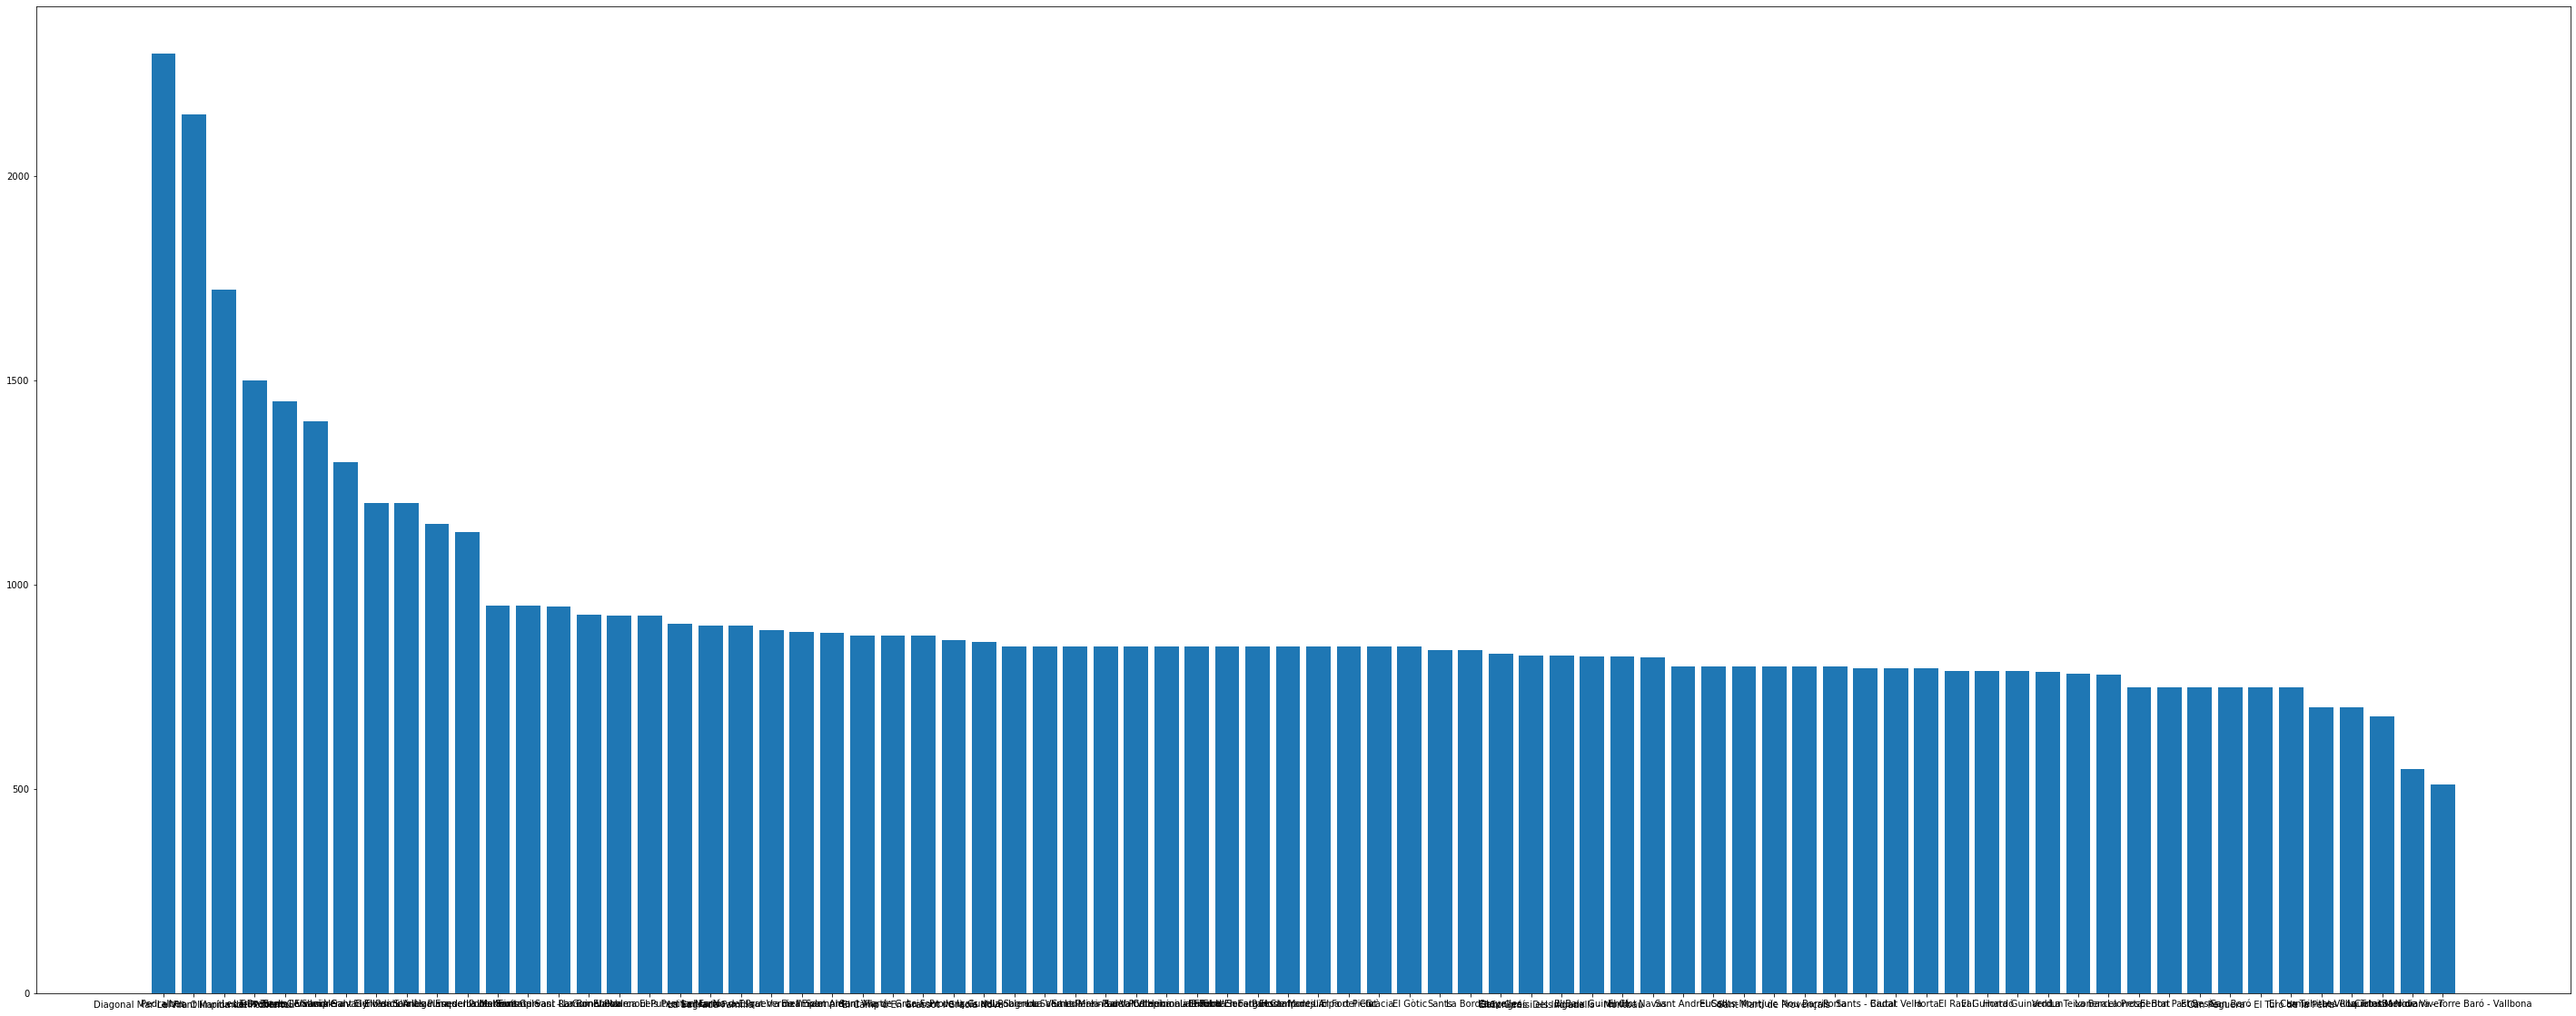

In [74]:
plt.bar(x = 'neighborhood', height = 'median_price', data = neighborhood)
plt.rcParams["figure.figsize"] = (50,20)

En este caso, podemos definir 3 tiers de precios según la zona dado que nos encontraremos con viviendas con pocas instancias

In [75]:
def conditions(x):
    if x < 0:
        return "Unknown"
    elif ((x >= 0) & (x < 800)):
        return "0 - 800"
    elif ((x >= 800) & (x < 1000)):
        return "800 - 1000"
    elif ((x >= 1000)):
        return "+1000"
    else:
        return "Unknown"

func = np.vectorize(conditions)
neighborhood['neighborhood_rent_index'] = func(neighborhood['median_price'])
neighborhood.head()

,index,neighborhood,category_count,mean_price,median_price,min_price,max_price,stantard_deviation,neighborhood_rent_index
0,55,Pedralbes,49,3114.122449,2300.0,550,14000,2622.439423,+1000
1,6,Diagonal Mar i el Front Marítim del Poblenou,50,2716.300000,2150.0,890,10000,2151.594276,+1000
2,49,La Vila Olímpica del Poblenou,20,1546.950000,1722.5,750,2600,508.797289,+1000
3,52,Les Tres Torres,59,1672.288136,1500.0,460,5500,1119.686425,+1000
4,32,La Dreta de l'Eixample,309,1902.275081,1450.0,450,16800,1828.864233,+1000


Finalmente agregamos ésta información el modelo de datos

In [76]:
neighborhood_mapping = neighborhood[['neighborhood', 'neighborhood_rent_index']]
rent_dataset = pd.merge(rent_dataset, neighborhood_mapping, on='neighborhood', how='left')
cat_features.append('neighborhood_rent_index')
rent_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,...,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,...,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111,NaN,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,...,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,...,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,...,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,...,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN,Unknown,+1000


Aplicamos one-hot encoding para la métrica de rent_index y para la edad del piso:

In [77]:
# select the categorical feature to do the one-hot encoding
cat_feature = 'neighborhood_rent_index'
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(rent_dataset[[cat_feature]]).toarray())
# renames columns adding a prefix with the column name
enc_df.columns = enc.categories_[0]
enc_df = enc_df.add_prefix(cat_feature + '_')
# merge with main df bridge_df on key values
rent_dataset_numeric = rent_dataset_numeric.join(enc_df)
rent_dataset_numeric

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,pool,ac,year_built,dist_city_center,dist_closest_station,property_age,neighborhood_rent_index_+1000,neighborhood_rent_index_0 - 800,neighborhood_rent_index_800 - 1000
0,850,55,2,1,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,NaN,2.026455,0.094111,NaN,0.0,0.0,1.0
1,725,37,2,1,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,1962.0,3.582409,0.902561,60.0,0.0,0.0,1.0
2,950,72,3,1,0.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,NaN,2.663025,0.188177,NaN,0.0,0.0,1.0
3,750,45,1,1,1.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1936.0,2.910067,0.892917,86.0,0.0,0.0,1.0
4,990,45,1,1,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,NaN,2.727149,0.293784,NaN,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,907,49,0,1,0.0,1.0,1.0,9.0,0.0,1.0,0.0,0.0,1966.0,1.317748,0.285426,56.0,0.0,0.0,1.0
8498,950,125,1,1,0.0,0.0,0.0,NaN,0.0,1.0,0.0,1.0,1997.0,4.063099,0.534462,25.0,0.0,0.0,1.0
8499,950,48,2,1,0.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0,1890.0,0.288753,0.261938,132.0,0.0,1.0,0.0
8500,926,51,2,1,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,NaN,3.909033,0.545561,NaN,0.0,0.0,1.0


In [78]:
# select the categorical feature to do the one-hot encoding
cat_feature = 'property_age_cat'
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(rent_dataset[[cat_feature]]).toarray())
# renames columns adding a prefix with the column name
enc_df.columns = enc.categories_[0]
enc_df = enc_df.add_prefix(cat_feature + '_')
# merge with main df bridge_df on key values
rent_dataset_numeric = rent_dataset_numeric.join(enc_df)
rent_dataset_numeric

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,...,property_age,neighborhood_rent_index_+1000,neighborhood_rent_index_0 - 800,neighborhood_rent_index_800 - 1000,property_age_cat_+150,property_age_cat_0 - 40,property_age_cat_120 - 150,property_age_cat_40 - 70,property_age_cat_70 - 120,property_age_cat_Unknown
0,850,55,2,1,0.0,0.0,1.0,2.0,0.0,0.0,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,725,37,2,1,1.0,0.0,1.0,3.0,0.0,1.0,...,60.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,950,72,3,1,0.0,0.0,1.0,4.0,0.0,1.0,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,750,45,1,1,1.0,0.0,1.0,4.0,0.0,1.0,...,86.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,990,45,1,1,0.0,0.0,1.0,3.0,0.0,1.0,...,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,907,49,0,1,0.0,1.0,1.0,9.0,0.0,1.0,...,56.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8498,950,125,1,1,0.0,0.0,0.0,NaN,0.0,1.0,...,25.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
8499,950,48,2,1,0.0,0.0,1.0,NaN,0.0,0.0,...,132.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8500,926,51,2,1,1.0,0.0,1.0,3.0,0.0,1.0,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Hacemos un modelo de Random Forest comprobando que no hay null values

In [79]:
rent_dataset_numeric_no_nulls = rent_dataset_numeric.drop(['year_built', 'property_age', 'floor'], axis = 1)
rent_dataset_numeric_no_nulls.isnull().sum() / len(rent_dataset_numeric_no_nulls)

price                                 0.0
sq_meters_built                       0.0
rooms                                 0.0
bathrooms                             0.0
balcony                               0.0
terrace                               0.0
exterior                              0.0
rooftop                               0.0
elevator                              0.0
pool                                  0.0
ac                                    0.0
dist_city_center                      0.0
dist_closest_station                  0.0
neighborhood_rent_index_+1000         0.0
neighborhood_rent_index_0 - 800       0.0
neighborhood_rent_index_800 - 1000    0.0
property_age_cat_+150                 0.0
property_age_cat_0 - 40               0.0
property_age_cat_120 - 150            0.0
property_age_cat_40 - 70              0.0
property_age_cat_70 - 120             0.0
property_age_cat_Unknown              0.0
dtype: float64

In [80]:
X = rent_dataset_numeric_no_nulls.drop(['price'], axis = 1)
y = rent_dataset_numeric_no_nulls[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [81]:
# we enumerate the values to try
parameters = [{"n_estimators":[100,150,200], "max_depth": [5,10,15]}]

#instantiate the classifier
rf_cv = RandomForestClassifier()

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=rf_cv, param_grid=parameters, scoring="r2")
grid_bag.fit(X_train, y_train)
grid_bag.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [83]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
rf = RandomForestClassifier(n_estimators = 100, max_depth=15)
# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model = cross_validate(rf, X_train, y_train, cv = 10, scoring = "r2")
for i, score in enumerate(model["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: 0.424235879796768
Accuracy for the fold no. 1 on the test set: 0.8378813669791414
Accuracy for the fold no. 2 on the test set: 0.6844122102490021
Accuracy for the fold no. 3 on the test set: 0.7752009859771941
Accuracy for the fold no. 4 on the test set: 0.679441211964492
Accuracy for the fold no. 5 on the test set: 0.7020123625110479
Accuracy for the fold no. 6 on the test set: 0.7358623743146169
Accuracy for the fold no. 7 on the test set: 0.5156074027817573
Accuracy for the fold no. 8 on the test set: 0.6738756367960282
Accuracy for the fold no. 9 on the test set: 0.6134520297195529


{'whiskers': [<matplotlib.lines.Line2D at 0x1fb077094f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1fb07709bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fb077091f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fb0771d2b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fb0771d610>],
 'means': []}

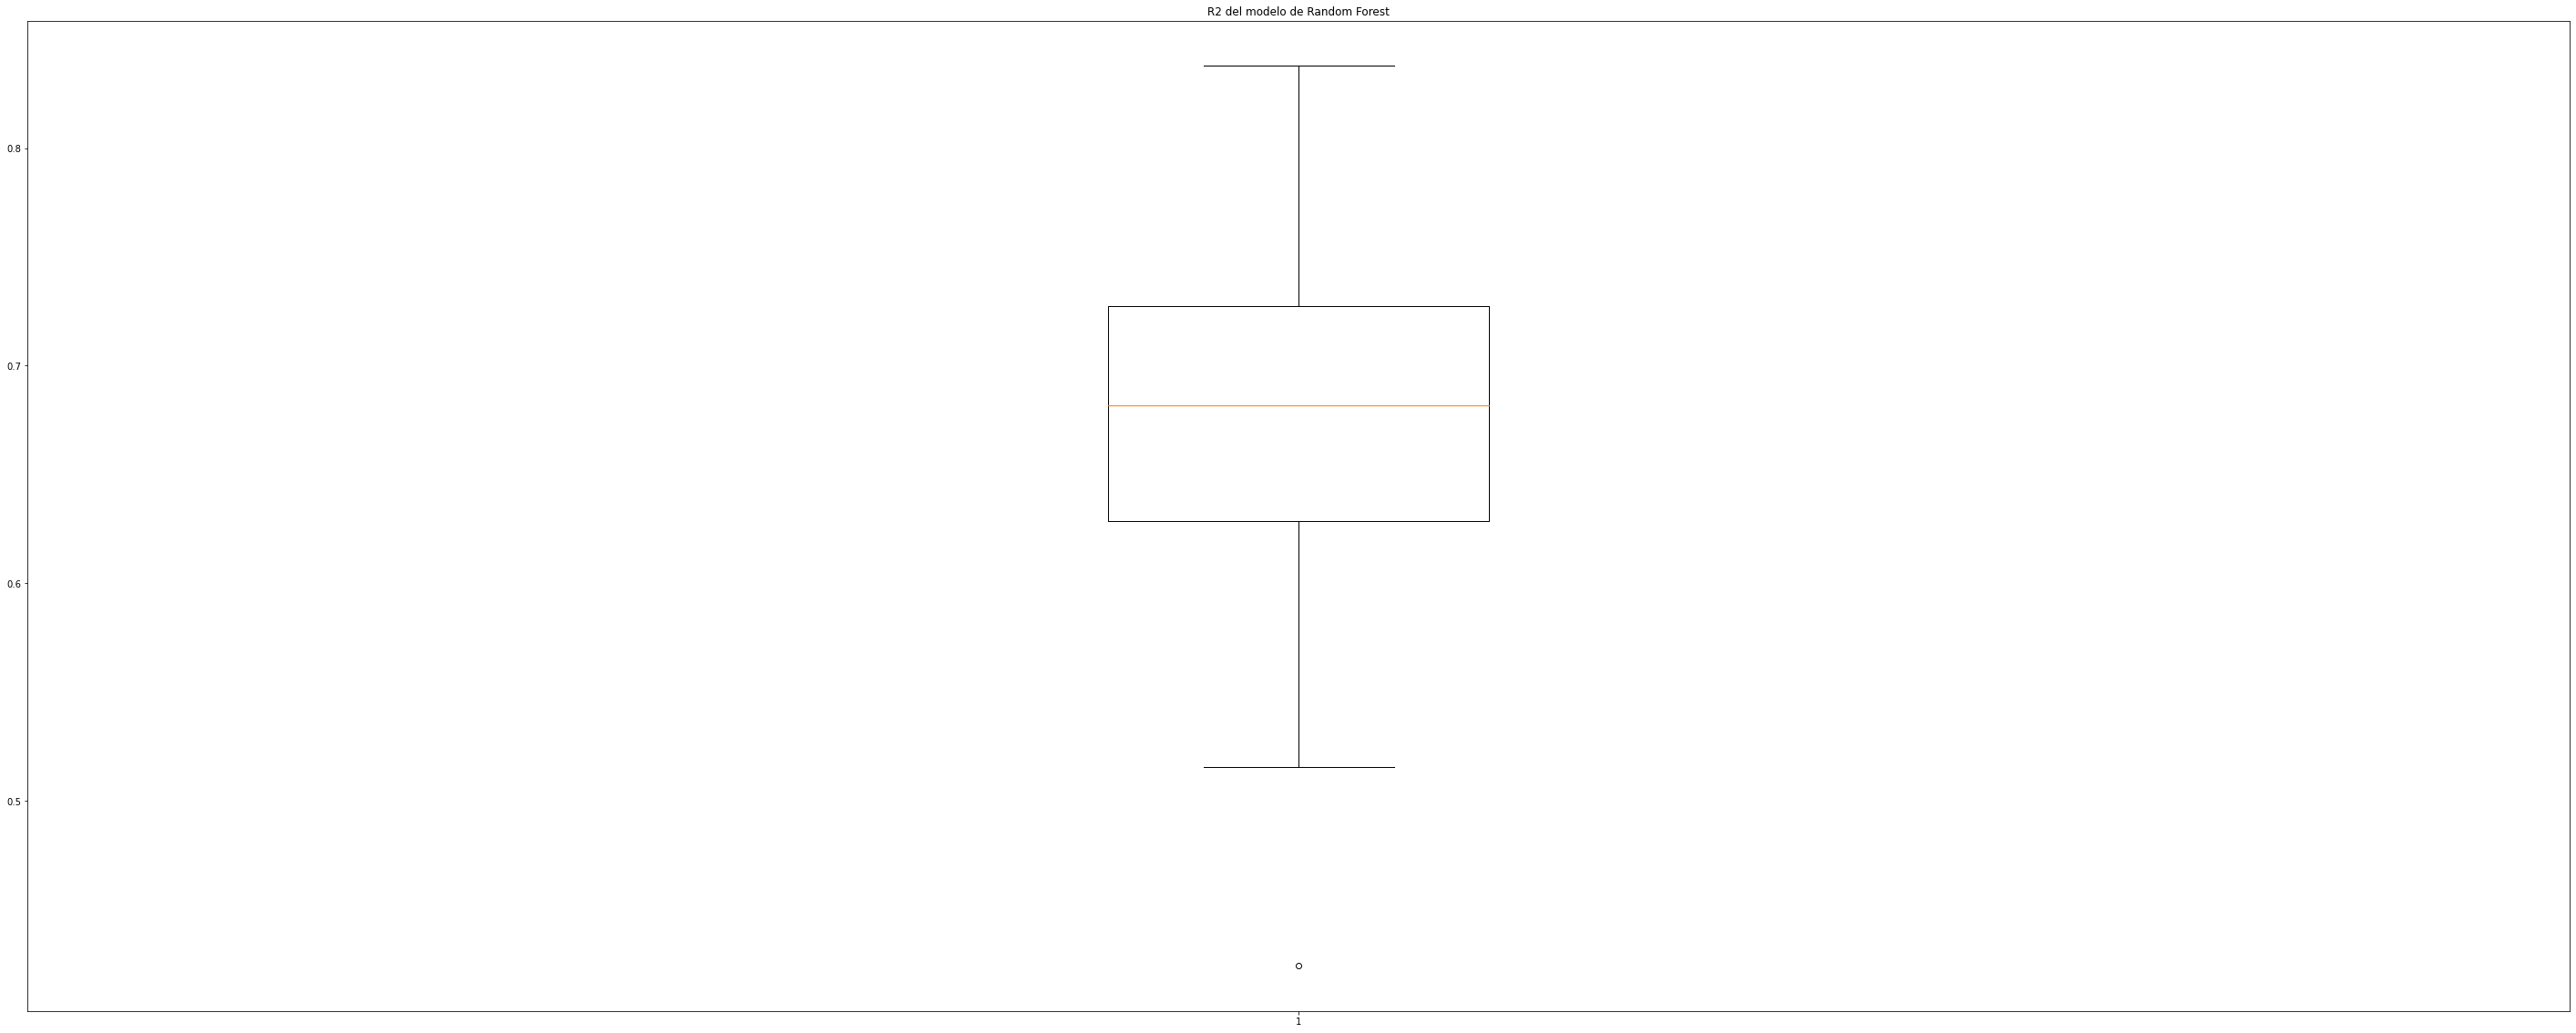

In [84]:
fig1, ax1 = plt.subplots()
ax1.set_title('R2 del modelo de Random Forest')
ax1.boxplot(model["test_score"])

In [85]:
np.median(model["test_score"])

0.6819267111067471

In [86]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
#error rate
metrics.r2_score(y_train, y_pred)

0.9977217789592701

In [87]:
y_pred = rf.predict(X_test)
#error rate
metrics.r2_score(y_test, y_pred)

0.5497360961365858

In [88]:
# Almacenamos los resultados para el modelo rf_1
cv['rf_1'] = model["test_score"]

model_results = ['rf_1', np.median(model["test_score"]), metrics.r2_score(y_test, y_pred)]
results = results.append(dict(zip(results.columns,model_results)), ignore_index=True)
results

,model,median_r2_cv_training,r2_validation
0,decision_tree_bagging,0.495285,0.558369
1,rf_1,0.681927,0.549736


{'whiskers': [<matplotlib.lines.Line2D at 0x1fb07830be0>,
 'caps': [<matplotlib.lines.Line2D at 0x1fb0784e310>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fb078308b0>,
 'medians': [<matplotlib.lines.Line2D at 0x1fb0784e9d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1fb0784ed30>,
 'means': []}

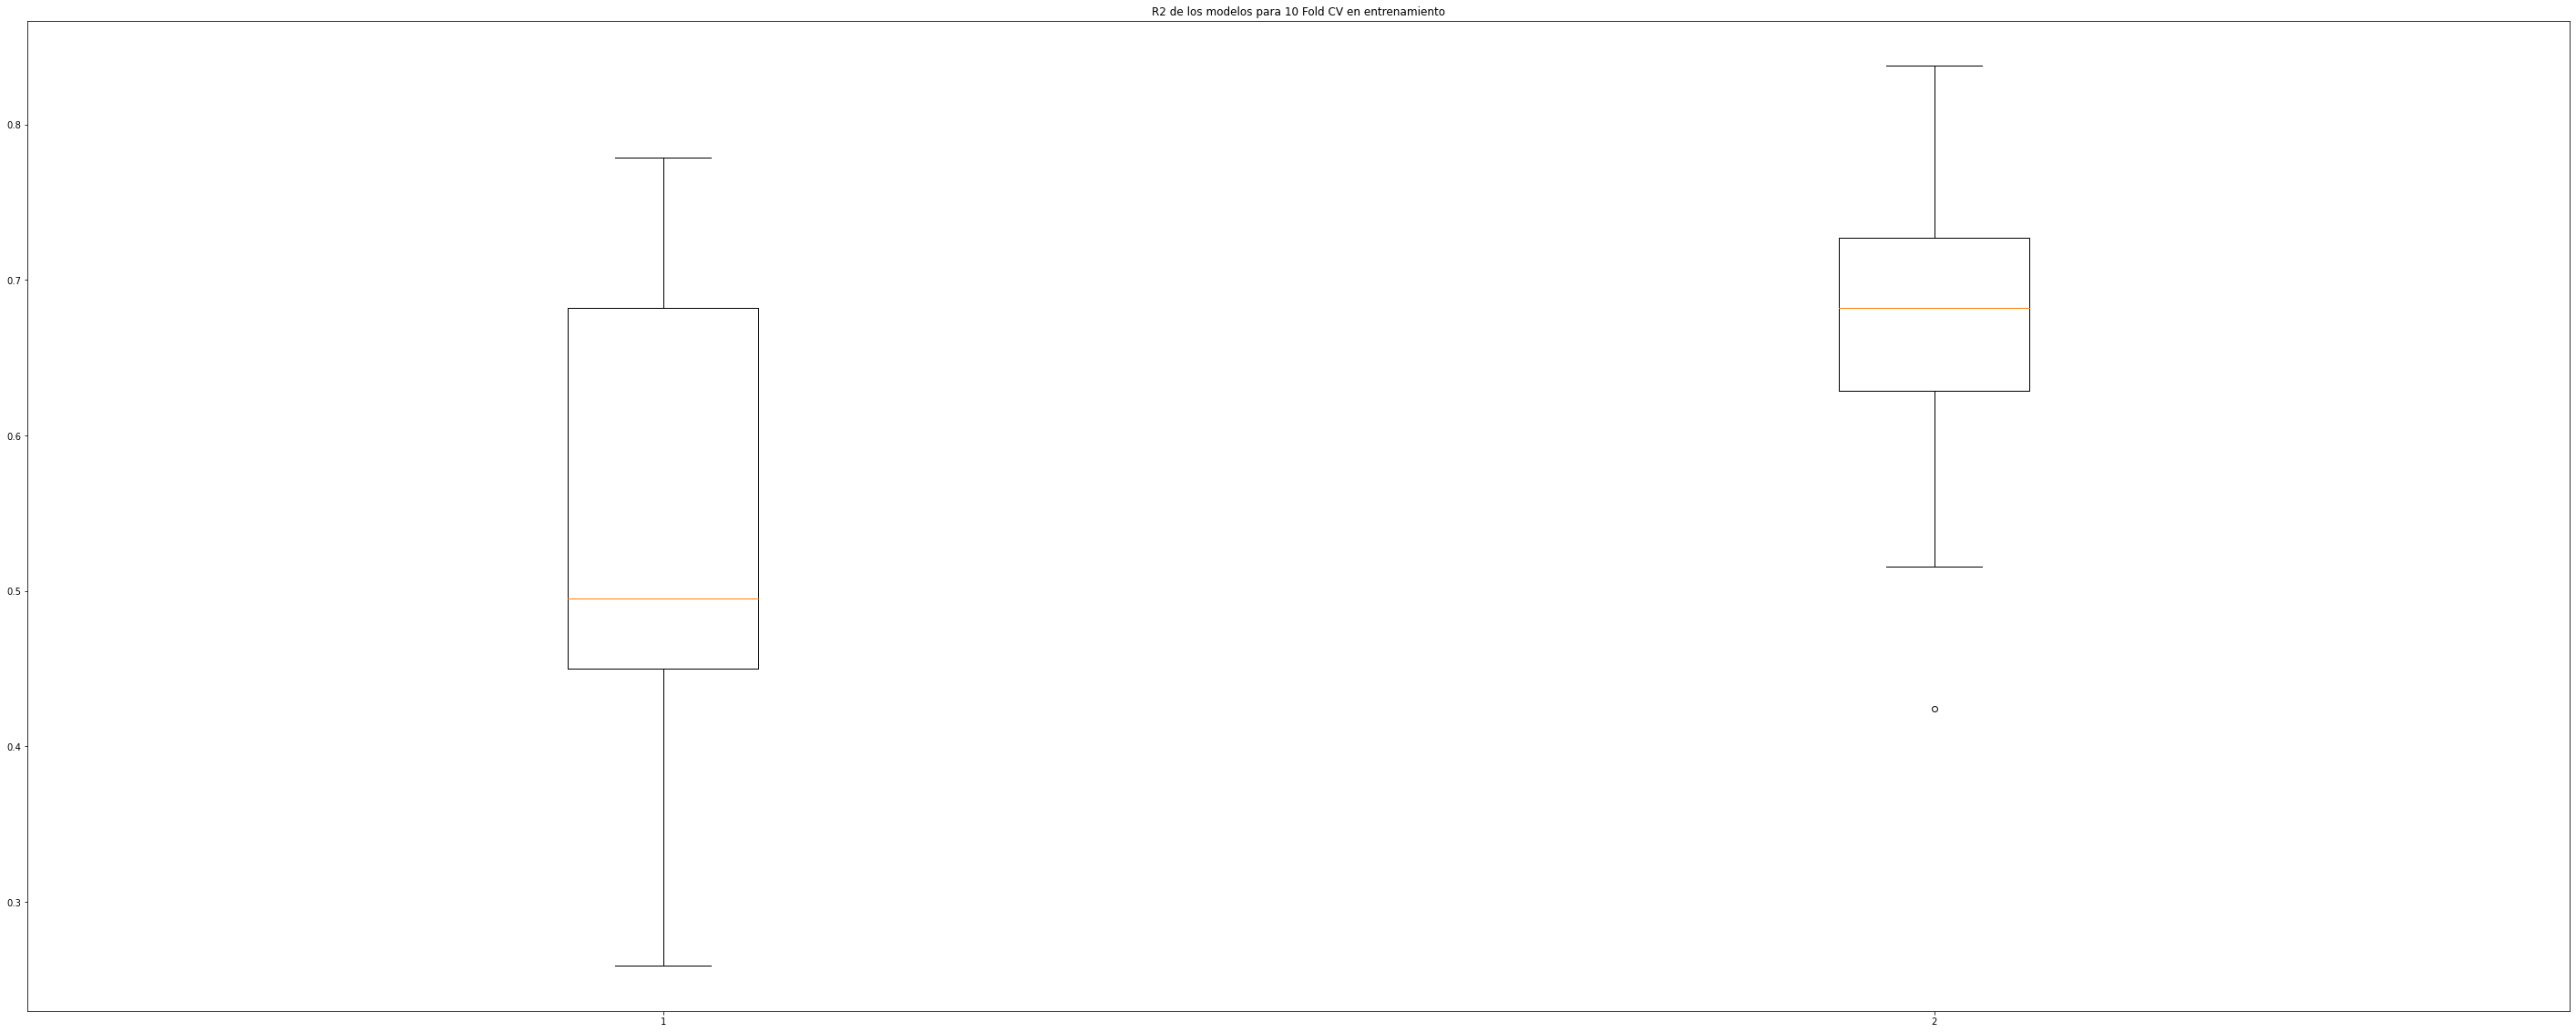

In [89]:
fig1, ax1 = plt.subplots()
ax1.set_title('R2 de los modelos para 10 Fold CV en entrenamiento')
ax1.boxplot(pd.DataFrame(cv))

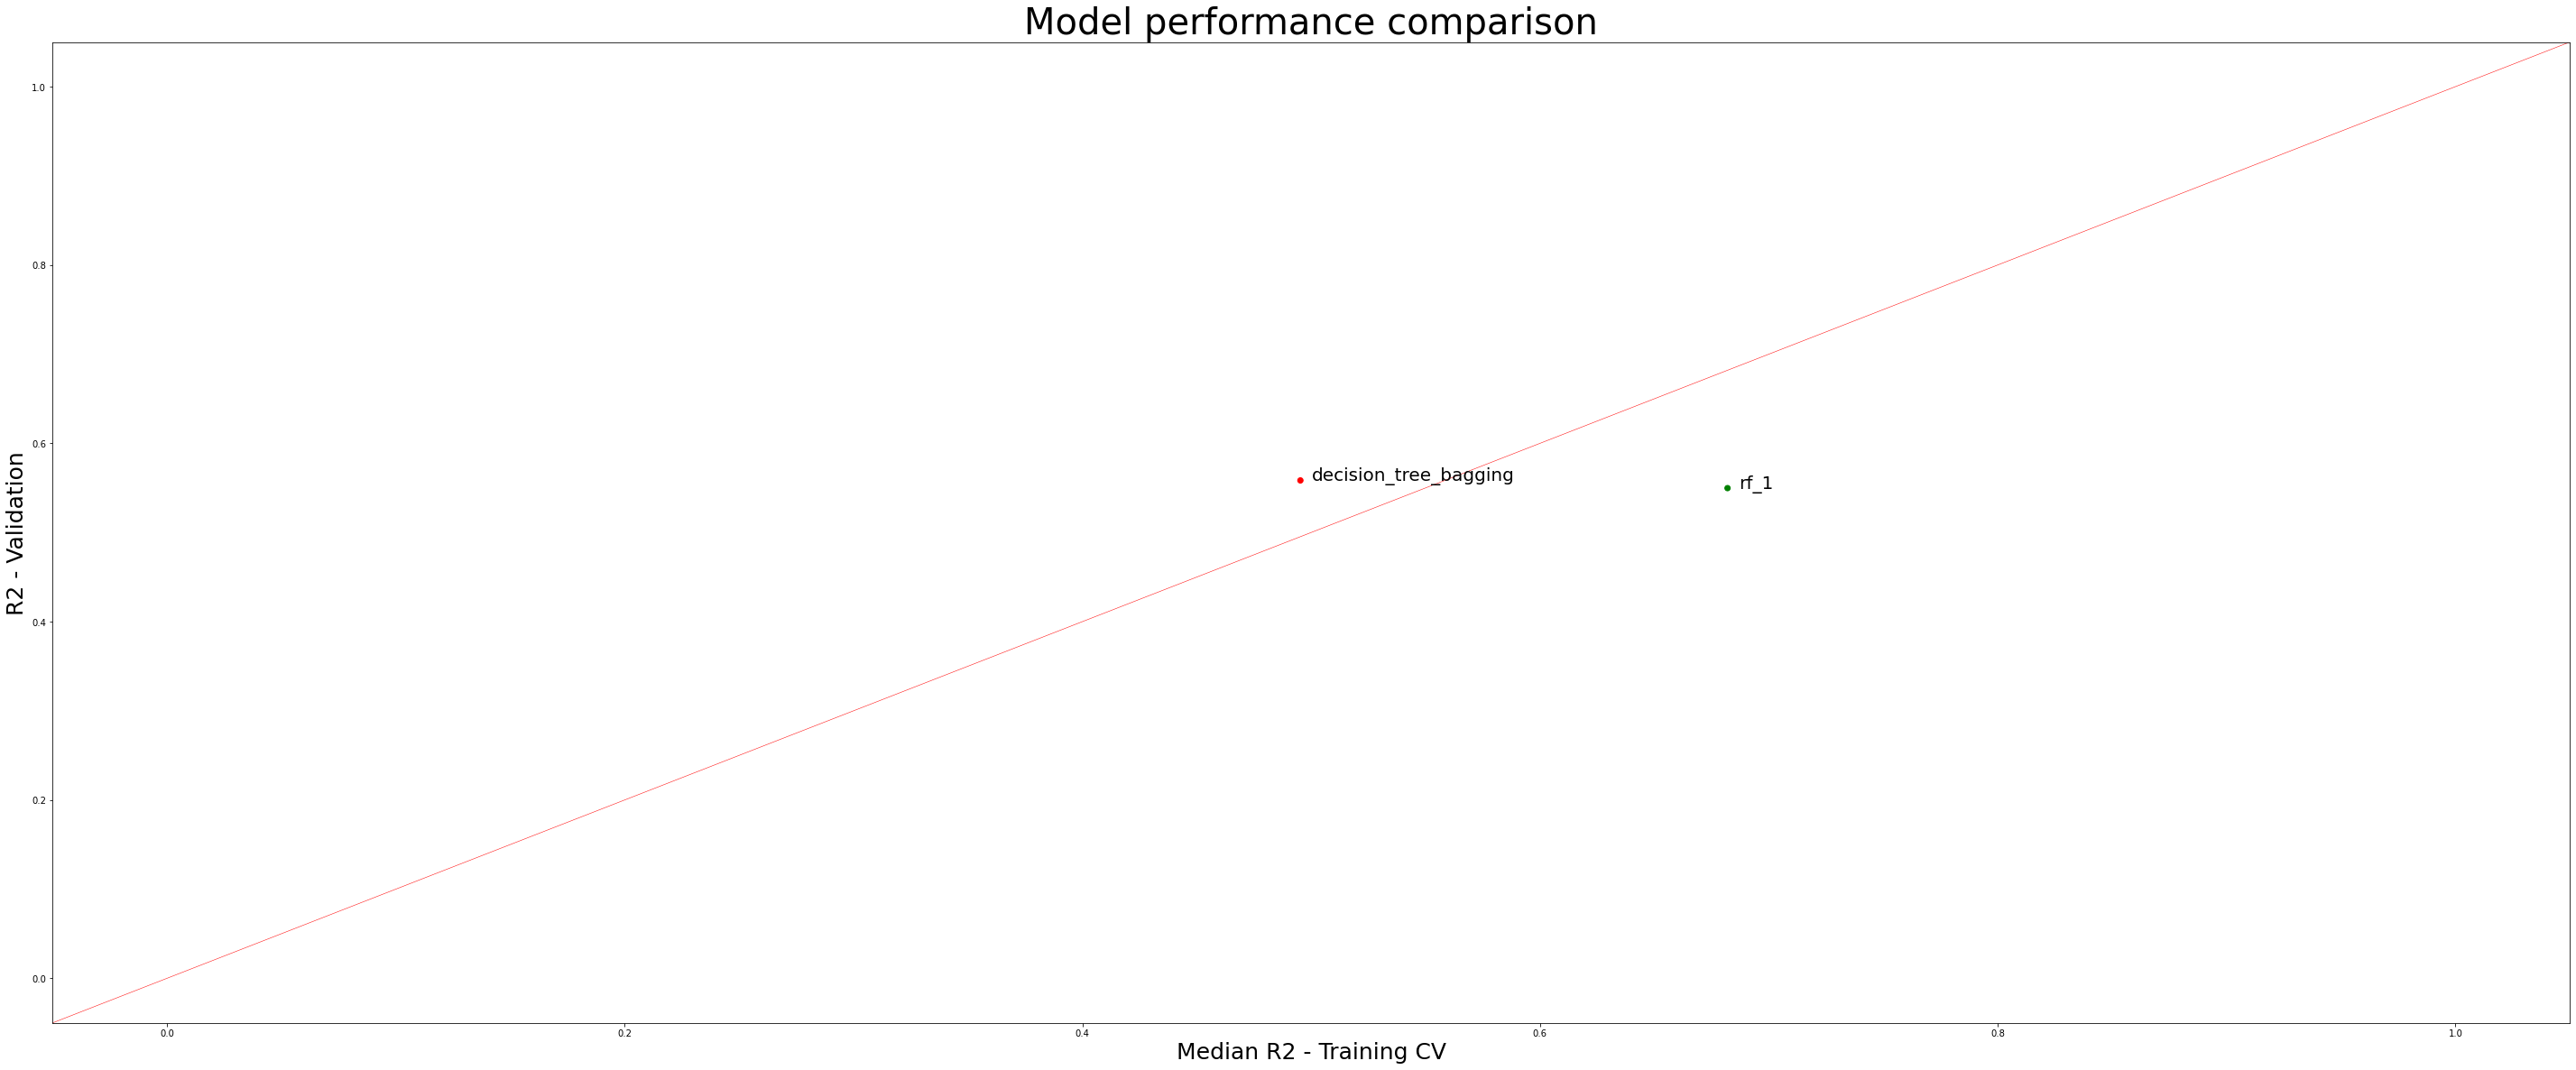

In [90]:
colors = {'decision_tree_bagging':'red', 'rf_1':'green'}
fig, ax = plt.subplots()

ax.scatter(x='median_r2_cv_training', y = 'r2_validation', data=results, c=results['model'].map(colors))
ax.axline((0, 0), (1, 1), linewidth=0.5, color='r')
plt.title("Model performance comparison", fontsize = 40)
plt.xlabel("Median R2 - Training CV", fontsize = 25)
plt.ylabel("R2 - Validation", fontsize = 25)

for i in range(0,len(results)):
    ax.annotate(results['model'][i], (results['median_r2_cv_training'][i] + 0.005, results['r2_validation'][i]), fontsize = 20)
    
plt.show()

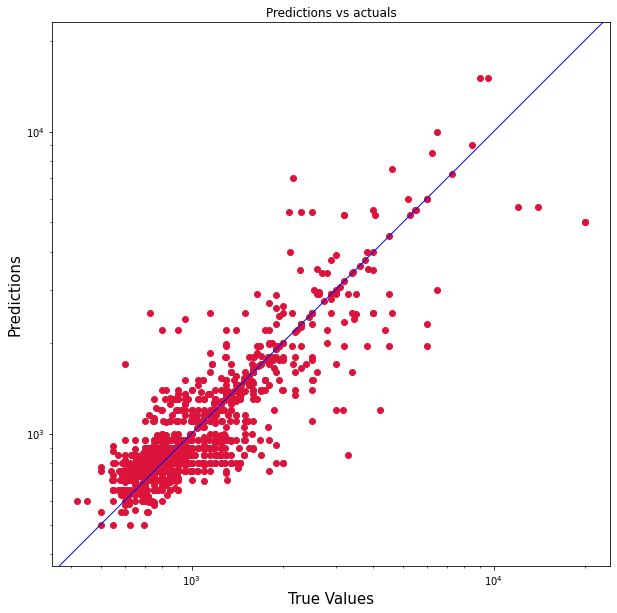

In [91]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_pred), np.max(y_test.values))
p2 = min(min(y_pred), np.min(y_test.values))
plt.axline((p2,p2), (p1,p1), linewidth=1, color='b')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Predictions vs actuals')
plt.axis('equal')
plt.show()

# Ejemplo Working Lab Sesión 3: Catboost

Recordamos que catboost admite variables categóricas. En este caso vamos a hacer limpieza del dataset y vamos a aplicar cambios adecuados:

In [94]:
catboost_dataset = rent_dataset
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,...,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,...,1.0,NaN,NaN,Gràcia,2.026455,piso,0.094111,NaN,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,...,1.0,NaN,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,NaN,4.0,0.0,...,1.0,NaN,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,...,0.0,NaN,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,...,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN,Unknown,+1000


Dentro de las variables categóricas había null values. Las sutituímos por una categoría Unknown

In [93]:
cat_features = ['neighborhood', 'property_type', 'orientation', 'heating', 'property_age_cat', 'neighborhood_rent_index']

In [95]:
for i in range(0,len(cat_features)):
    catboost_dataset[cat_features[i]].fillna("Unknown", inplace = True) 
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,...,ac,heating,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,property_age,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,...,1.0,Unknown,NaN,Gràcia,2.026455,piso,0.094111,NaN,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,...,1.0,Unknown,1962.0,Sant Gervasi - La Bonanova,3.582409,piso,0.902561,60.0,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,Unknown,4.0,0.0,...,1.0,Unknown,NaN,El Baix Guinardó,2.663025,piso,0.188177,NaN,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,...,0.0,Unknown,1936.0,Sant Gervasi - La Bonanova,2.910067,piso,0.892917,86.0,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,...,0.0,gas,NaN,Sarrià-Sant Gervasi,2.727149,piso,0.293784,NaN,Unknown,+1000


Comprobamos null values y vemos que hay 3 columnas, con 2 de ellas ya transformadas en la variable property_age_cat.

In [96]:
catboost_dataset.isnull().sum() / len(catboost_dataset)

price                      0.000000
sq_meters_built            0.000000
rooms                      0.000000
bathrooms                  0.000000
balcony                    0.000000
terrace                    0.000000
exterior                   0.000000
orientation                0.000000
floor                      0.231240
rooftop                    0.000000
elevator                   0.000000
pool                       0.000000
ac                         0.000000
heating                    0.000000
year_built                 0.528817
neighborhood               0.000000
dist_city_center           0.000000
property_type              0.000000
dist_closest_station       0.000000
property_age               0.528817
property_age_cat           0.000000
neighborhood_rent_index    0.000000
dtype: float64

In [98]:
catboost_dataset = catboost_dataset.drop(['property_age', 'year_built', 'neighborhood'], axis = 1)
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,dist_city_center,property_type,dist_closest_station,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,2.0,0.0,0.0,0.0,1.0,Unknown,2.026455,piso,0.094111,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,1.0,Unknown,3.582409,piso,0.902561,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,Unknown,4.0,0.0,1.0,0.0,1.0,Unknown,2.663025,piso,0.188177,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,4.0,0.0,1.0,0.0,0.0,Unknown,2.910067,piso,0.892917,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,3.0,0.0,1.0,0.0,0.0,gas,2.727149,piso,0.293784,Unknown,+1000


Estudiamos la categoría floor

In [103]:
floor = rent_dataset[['floor', 'price']].groupby('floor', as_index=False).agg(
    # Number of instances per category
    category_count=('price', "count"),
    # Mean price
    mean_price=('price', "mean"),
    # Median price
    median_price=('price', "median"),
    # Min price
    min_price=('price', min),
    # Max price
    max_price=('price', max),
    # Standard deviation
    stantard_deviation=('price', "std")).sort_values('floor', ascending = True).reset_index()

floor

,index,floor,category_count,mean_price,median_price,min_price,max_price,stantard_deviation
0,0,1.0,1621,1058.713140,850.0,375,15000,872.195510
1,1,2.0,1444,1034.605956,850.0,450,8000,657.958040
2,2,3.0,1247,1076.694467,850.0,365,11000,728.365237
3,3,4.0,967,1109.232678,850.0,480,14000,919.922265
4,4,5.0,583,1124.686106,900.0,419,7250,620.034299
5,5,6.0,298,1227.724832,942.5,550,7200,820.993341
6,6,7.0,192,1345.104167,950.0,500,8000,1027.784049
7,7,8.0,87,1079.298851,900.0,460,3500,562.091797
8,8,9.0,41,1371.560976,925.0,700,3400,746.857652
9,9,10.0,21,1122.285714,850.0,675,2500,572.837424


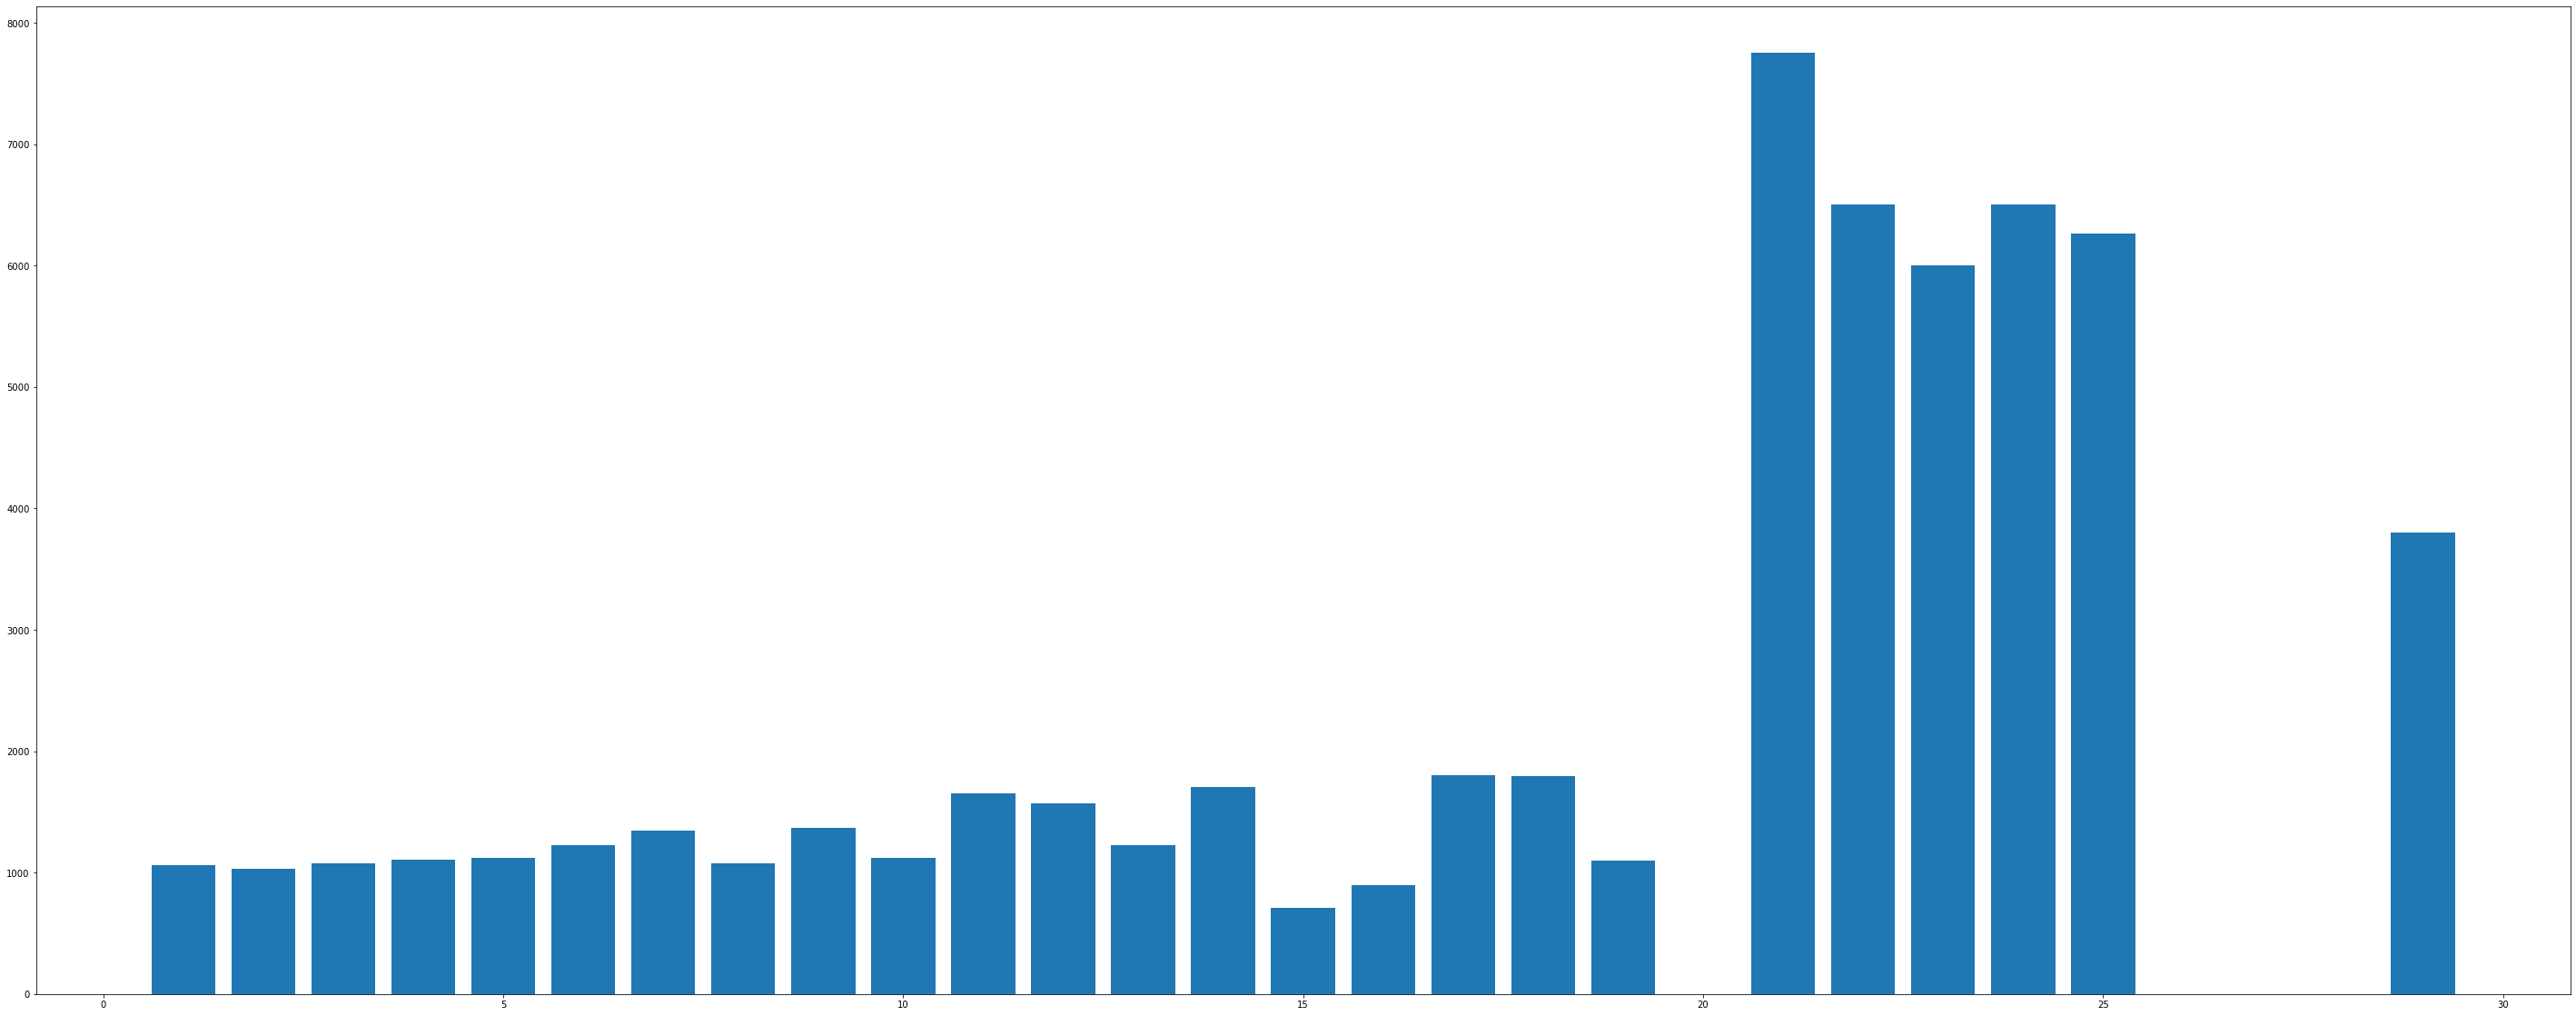

In [105]:
plt.bar(x = 'floor', height = 'mean_price', data = floor)
plt.rcParams["figure.figsize"] = (50,20)

Hacemos drop de la variable floor

Vemos que para pisos altos el precio aumenta mucho, pero tenemos muy pocas instancias (Menos de 10) y además tenemos un 20% con null values. Para este ejemplo decidimos retirarlas del modelo

In [106]:
catboost_dataset = catboost_dataset.drop(['floor'], axis = 1)
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,heating,dist_city_center,property_type,dist_closest_station,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,0.0,0.0,0.0,1.0,Unknown,2.026455,piso,0.094111,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,0.0,1.0,0.0,1.0,Unknown,3.582409,piso,0.902561,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,Unknown,0.0,1.0,0.0,1.0,Unknown,2.663025,piso,0.188177,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,0.0,1.0,0.0,0.0,Unknown,2.910067,piso,0.892917,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,0.0,1.0,0.0,0.0,gas,2.727149,piso,0.293784,Unknown,+1000


In [107]:
catboost_dataset.isnull().sum() / len(catboost_dataset)

price                      0.0
sq_meters_built            0.0
rooms                      0.0
bathrooms                  0.0
balcony                    0.0
terrace                    0.0
exterior                   0.0
orientation                0.0
rooftop                    0.0
elevator                   0.0
pool                       0.0
ac                         0.0
heating                    0.0
dist_city_center           0.0
property_type              0.0
dist_closest_station       0.0
property_age_cat           0.0
neighborhood_rent_index    0.0
dtype: float64

Definimos como tipo de dato "category" las categorías en nuestros datos:

In [122]:
cat_features = ['property_type', 'orientation', 'heating', 'property_age_cat', 'neighborhood_rent_index']
for i in range(0,len(cat_features)):
    catboost_dataset[cat_features[i]].astype("category")
catboost_dataset.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,heating,dist_city_center,property_type,dist_closest_station,property_age_cat,neighborhood_rent_index
0,850,55,2,1,0.0,0.0,1.0,norte,0.0,0.0,0.0,1.0,Unknown,2.026455,piso,0.094111,Unknown,800 - 1000
1,725,37,2,1,1.0,0.0,1.0,sur,0.0,1.0,0.0,1.0,Unknown,3.582409,piso,0.902561,40 - 70,800 - 1000
2,950,72,3,1,0.0,0.0,1.0,Unknown,0.0,1.0,0.0,1.0,Unknown,2.663025,piso,0.188177,Unknown,800 - 1000
3,750,45,1,1,1.0,0.0,1.0,norte,0.0,1.0,0.0,0.0,Unknown,2.910067,piso,0.892917,70 - 120,800 - 1000
4,990,45,1,1,0.0,0.0,1.0,sur,0.0,1.0,0.0,0.0,gas,2.727149,piso,0.293784,Unknown,+1000


Hacemos el modelo

In [114]:
import catboost as cat

In [123]:
# Target and variable
X = catboost_dataset.drop(['price'], axis = 1)
y = catboost_dataset[['price']]
# Split in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
# create a train/test split with catboost
d_train_cat = cat.Pool(X_train, y_train, cat_features = cat_features)
d_test_cat = cat.Pool(X_test, y_test, cat_features = cat_features)

Gridsearch nos ayudará a generar la mejor combinación

In [125]:
model = cat.CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.015],
        'depth': [6, 8, 10, 12]}

grid_search_result = model.grid_search(grid,
                                       d_train_cat,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1479.4560124	test: 1344.2548569	best: 1344.2548569 (0)	total: 171ms	remaining: 2m 51s
1:	learn: 1445.5029794	test: 1310.7580607	best: 1310.7580607 (1)	total: 189ms	remaining: 1m 34s
2:	learn: 1412.8888991	test: 1278.3019374	best: 1278.3019374 (2)	total: 204ms	remaining: 1m 7s
3:	learn: 1380.1406035	test: 1246.6533678	best: 1246.6533678 (3)	total: 220ms	remaining: 54.7s
4:	learn: 1349.3397392	test: 1215.8157611	best: 1215.8157611 (4)	total: 246ms	remaining: 49s
5:	learn: 1319.0086821	test: 1185.8381544	best: 1185.8381544 (5)	total: 274ms	remaining: 45.3s
6:	learn: 1290.2765973	test: 1156.9812821	best: 1156.9812821 (6)	total: 292ms	remaining: 41.4s
7:	learn: 1261.5331472	test: 1129.2899848	best: 1129.2899848 (7)	total: 308ms	remaining: 38.2s
8:	learn: 1234.7749401	test: 1101.8738007	best: 1101.8738007 (8)	total: 325ms	remaining: 35.8s
9:	learn: 1210.1833075	test: 1076.3928287	best: 1076.3928287 (9)	total: 342ms	remaining: 33.8s
10:	learn: 1185.3611245	test: 1051.8852788	best: 1

95:	learn: 451.6121769	test: 420.0977137	best: 420.0977137 (95)	total: 2.14s	remaining: 20.2s
96:	learn: 449.8578086	test: 419.6011645	best: 419.6011645 (96)	total: 2.17s	remaining: 20.2s
97:	learn: 447.8327742	test: 418.7299749	best: 418.7299749 (97)	total: 2.19s	remaining: 20.2s
98:	learn: 445.7102917	test: 418.7978456	best: 418.7299749 (97)	total: 2.21s	remaining: 20.1s
99:	learn: 444.0027770	test: 418.3912214	best: 418.3912214 (99)	total: 2.24s	remaining: 20.1s
100:	learn: 442.4371692	test: 418.0551335	best: 418.0551335 (100)	total: 2.27s	remaining: 20.2s
101:	learn: 440.7245800	test: 417.4160215	best: 417.4160215 (101)	total: 2.29s	remaining: 20.2s
102:	learn: 439.4823277	test: 417.0409152	best: 417.0409152 (102)	total: 2.31s	remaining: 20.1s
103:	learn: 437.6888227	test: 416.6914918	best: 416.6914918 (103)	total: 2.33s	remaining: 20.1s
104:	learn: 436.5582467	test: 416.3657700	best: 416.3657700 (104)	total: 2.36s	remaining: 20.1s
105:	learn: 435.5527651	test: 416.1417660	best: 41

189:	learn: 364.5047849	test: 403.1032826	best: 403.0748307 (183)	total: 4.08s	remaining: 17.4s
190:	learn: 363.5658770	test: 403.1123398	best: 403.0748307 (183)	total: 4.11s	remaining: 17.4s
191:	learn: 363.3444324	test: 403.1178111	best: 403.0748307 (183)	total: 4.14s	remaining: 17.4s
192:	learn: 362.3249176	test: 402.6119130	best: 402.6119130 (192)	total: 4.16s	remaining: 17.4s
193:	learn: 361.2983947	test: 402.2330709	best: 402.2330709 (193)	total: 4.17s	remaining: 17.3s
194:	learn: 360.5558313	test: 402.1087668	best: 402.1087668 (194)	total: 4.19s	remaining: 17.3s
195:	learn: 360.3728654	test: 402.1575211	best: 402.1087668 (194)	total: 4.21s	remaining: 17.3s
196:	learn: 359.5671734	test: 401.4630547	best: 401.4630547 (196)	total: 4.22s	remaining: 17.2s
197:	learn: 359.0195573	test: 401.3334379	best: 401.3334379 (197)	total: 4.24s	remaining: 17.2s
198:	learn: 358.4070431	test: 401.3228809	best: 401.3228809 (198)	total: 4.26s	remaining: 17.1s
199:	learn: 357.5805368	test: 401.010341

275:	learn: 325.6547514	test: 393.2667452	best: 393.2667452 (275)	total: 5.8s	remaining: 15.2s
276:	learn: 325.4149011	test: 393.2897728	best: 393.2667452 (275)	total: 5.81s	remaining: 15.2s
277:	learn: 325.1696533	test: 393.1322071	best: 393.1322071 (277)	total: 5.83s	remaining: 15.1s
278:	learn: 324.9632508	test: 393.0259598	best: 393.0259598 (278)	total: 5.85s	remaining: 15.1s
279:	learn: 324.6432837	test: 392.7565042	best: 392.7565042 (279)	total: 5.86s	remaining: 15.1s
280:	learn: 324.2346240	test: 392.6470558	best: 392.6470558 (280)	total: 5.88s	remaining: 15s
281:	learn: 324.0603483	test: 392.6475243	best: 392.6470558 (280)	total: 5.89s	remaining: 15s
282:	learn: 323.8304294	test: 392.6400376	best: 392.6400376 (282)	total: 5.91s	remaining: 15s
283:	learn: 323.4427883	test: 392.9477126	best: 392.6400376 (282)	total: 5.93s	remaining: 15s
284:	learn: 323.4251389	test: 392.9483911	best: 392.6400376 (282)	total: 5.94s	remaining: 14.9s
285:	learn: 323.3705791	test: 392.9432684	best: 3

366:	learn: 302.4165585	test: 385.5490791	best: 385.3509683 (362)	total: 7.78s	remaining: 13.4s
367:	learn: 302.3528688	test: 385.5500438	best: 385.3509683 (362)	total: 7.8s	remaining: 13.4s
368:	learn: 302.1286988	test: 385.5232395	best: 385.3509683 (362)	total: 7.82s	remaining: 13.4s
369:	learn: 301.6014157	test: 385.2704393	best: 385.2704393 (369)	total: 7.85s	remaining: 13.4s
370:	learn: 300.9236996	test: 385.2020187	best: 385.2020187 (370)	total: 7.86s	remaining: 13.3s
371:	learn: 300.7967862	test: 385.2382156	best: 385.2020187 (370)	total: 7.89s	remaining: 13.3s
372:	learn: 300.5754733	test: 385.3373458	best: 385.2020187 (370)	total: 7.91s	remaining: 13.3s
373:	learn: 300.1553342	test: 385.2177447	best: 385.2020187 (370)	total: 7.93s	remaining: 13.3s
374:	learn: 299.5620431	test: 384.9450413	best: 384.9450413 (374)	total: 7.94s	remaining: 13.2s
375:	learn: 299.4881900	test: 384.9211192	best: 384.9211192 (375)	total: 7.96s	remaining: 13.2s
376:	learn: 299.2306112	test: 384.9466880

460:	learn: 286.6543836	test: 383.3760651	best: 383.3481922 (453)	total: 9.88s	remaining: 11.6s
461:	learn: 286.6002616	test: 383.4555675	best: 383.3481922 (453)	total: 9.9s	remaining: 11.5s
462:	learn: 286.5699681	test: 383.4411854	best: 383.3481922 (453)	total: 9.94s	remaining: 11.5s
463:	learn: 286.3600584	test: 383.3075346	best: 383.3075346 (463)	total: 9.97s	remaining: 11.5s
464:	learn: 286.3159284	test: 383.2936142	best: 383.2936142 (464)	total: 9.99s	remaining: 11.5s
465:	learn: 286.2307464	test: 383.2957517	best: 383.2936142 (464)	total: 10s	remaining: 11.5s
466:	learn: 286.0710491	test: 383.0745332	best: 383.0745332 (466)	total: 10s	remaining: 11.4s
467:	learn: 286.0596635	test: 383.0692385	best: 383.0692385 (467)	total: 10s	remaining: 11.4s
468:	learn: 285.6929829	test: 383.0562929	best: 383.0562929 (468)	total: 10.1s	remaining: 11.4s
469:	learn: 285.6634421	test: 383.0423503	best: 383.0423503 (469)	total: 10.1s	remaining: 11.4s
470:	learn: 285.5835028	test: 383.0459072	best:

549:	learn: 274.5504087	test: 380.7255274	best: 380.3540441 (540)	total: 12.1s	remaining: 9.86s
550:	learn: 274.4387303	test: 380.7415183	best: 380.3540441 (540)	total: 12.1s	remaining: 9.84s
551:	learn: 274.2974529	test: 380.7630573	best: 380.3540441 (540)	total: 12.1s	remaining: 9.81s
552:	learn: 274.2091486	test: 380.7418948	best: 380.3540441 (540)	total: 12.1s	remaining: 9.79s
553:	learn: 274.1186832	test: 380.7177577	best: 380.3540441 (540)	total: 12.1s	remaining: 9.76s
554:	learn: 274.0507462	test: 380.7868310	best: 380.3540441 (540)	total: 12.2s	remaining: 9.75s
555:	learn: 273.8301844	test: 380.5684099	best: 380.3540441 (540)	total: 12.2s	remaining: 9.73s
556:	learn: 273.8132997	test: 380.5551245	best: 380.3540441 (540)	total: 12.2s	remaining: 9.7s
557:	learn: 273.6811842	test: 380.5570256	best: 380.3540441 (540)	total: 12.2s	remaining: 9.68s
558:	learn: 273.6448138	test: 380.5270014	best: 380.3540441 (540)	total: 12.2s	remaining: 9.65s
559:	learn: 273.6273414	test: 380.5273140

635:	learn: 263.9671271	test: 378.8565894	best: 378.8565894 (635)	total: 13.8s	remaining: 7.9s
636:	learn: 263.8291130	test: 378.7538506	best: 378.7538506 (636)	total: 13.8s	remaining: 7.89s
637:	learn: 263.6971550	test: 378.8019564	best: 378.7538506 (636)	total: 13.9s	remaining: 7.86s
638:	learn: 263.6284358	test: 378.8037853	best: 378.7538506 (636)	total: 13.9s	remaining: 7.84s
639:	learn: 263.5601107	test: 378.8007096	best: 378.7538506 (636)	total: 13.9s	remaining: 7.82s
640:	learn: 263.3519821	test: 378.7740949	best: 378.7538506 (636)	total: 13.9s	remaining: 7.8s
641:	learn: 263.2967230	test: 378.7781235	best: 378.7538506 (636)	total: 14s	remaining: 7.78s
642:	learn: 263.1627951	test: 378.7985419	best: 378.7538506 (636)	total: 14s	remaining: 7.76s
643:	learn: 262.9863565	test: 378.8965322	best: 378.7538506 (636)	total: 14s	remaining: 7.73s
644:	learn: 262.9334360	test: 378.8513025	best: 378.7538506 (636)	total: 14s	remaining: 7.71s
645:	learn: 262.9031839	test: 378.8552124	best: 37

724:	learn: 254.2675330	test: 377.3888936	best: 377.2999844 (719)	total: 15.8s	remaining: 5.98s
725:	learn: 254.2000106	test: 377.3714168	best: 377.2999844 (719)	total: 15.8s	remaining: 5.96s
726:	learn: 253.7892453	test: 377.0476377	best: 377.0476377 (726)	total: 15.8s	remaining: 5.93s
727:	learn: 253.5695095	test: 377.0762977	best: 377.0476377 (726)	total: 15.8s	remaining: 5.91s
728:	learn: 253.4252045	test: 377.0269196	best: 377.0269196 (728)	total: 15.8s	remaining: 5.89s
729:	learn: 253.2666441	test: 376.9604827	best: 376.9604827 (729)	total: 15.9s	remaining: 5.87s
730:	learn: 253.0988304	test: 376.9283333	best: 376.9283333 (730)	total: 15.9s	remaining: 5.85s
731:	learn: 252.9387269	test: 377.1011791	best: 376.9283333 (730)	total: 15.9s	remaining: 5.83s
732:	learn: 252.8570311	test: 377.0749537	best: 376.9283333 (730)	total: 15.9s	remaining: 5.8s
733:	learn: 252.7694506	test: 377.0330282	best: 376.9283333 (730)	total: 15.9s	remaining: 5.78s
734:	learn: 252.6375581	test: 377.1391286

818:	learn: 243.6104616	test: 375.7700629	best: 375.6778357 (812)	total: 17.9s	remaining: 3.96s
819:	learn: 243.5966170	test: 375.7643224	best: 375.6778357 (812)	total: 17.9s	remaining: 3.93s
820:	learn: 243.5306037	test: 375.7309344	best: 375.6778357 (812)	total: 17.9s	remaining: 3.91s
821:	learn: 243.4159560	test: 375.7795971	best: 375.6778357 (812)	total: 18s	remaining: 3.89s
822:	learn: 243.3128074	test: 375.6756579	best: 375.6756579 (822)	total: 18s	remaining: 3.87s
823:	learn: 243.2610129	test: 375.6504364	best: 375.6504364 (823)	total: 18s	remaining: 3.85s
824:	learn: 243.1879581	test: 375.7092819	best: 375.6504364 (823)	total: 18s	remaining: 3.82s
825:	learn: 243.1494692	test: 375.7088595	best: 375.6504364 (823)	total: 18.1s	remaining: 3.8s
826:	learn: 243.0994277	test: 375.6214942	best: 375.6214942 (826)	total: 18.1s	remaining: 3.78s
827:	learn: 243.0159061	test: 375.7143866	best: 375.6214942 (826)	total: 18.1s	remaining: 3.76s
828:	learn: 242.9832006	test: 375.6757187	best: 3

907:	learn: 235.7012385	test: 374.1762777	best: 374.1642418 (906)	total: 19.8s	remaining: 2.01s
908:	learn: 235.6858317	test: 374.1578377	best: 374.1578377 (908)	total: 19.9s	remaining: 1.99s
909:	learn: 235.6501988	test: 374.1498511	best: 374.1498511 (909)	total: 19.9s	remaining: 1.97s
910:	learn: 235.5449203	test: 373.9826098	best: 373.9826098 (910)	total: 19.9s	remaining: 1.94s
911:	learn: 235.5305894	test: 374.0298624	best: 373.9826098 (910)	total: 19.9s	remaining: 1.92s
912:	learn: 235.4193578	test: 374.0485589	best: 373.9826098 (910)	total: 19.9s	remaining: 1.9s
913:	learn: 235.1974839	test: 374.0116938	best: 373.9826098 (910)	total: 20s	remaining: 1.88s
914:	learn: 235.0838807	test: 373.9758435	best: 373.9758435 (914)	total: 20s	remaining: 1.85s
915:	learn: 235.0566052	test: 373.9742638	best: 373.9742638 (915)	total: 20s	remaining: 1.83s
916:	learn: 235.0176359	test: 373.9498152	best: 373.9498152 (916)	total: 20s	remaining: 1.81s
917:	learn: 234.9833532	test: 373.9328843	best: 3

997:	learn: 229.0098615	test: 372.5729868	best: 372.5443761 (974)	total: 21.6s	remaining: 43.2ms
998:	learn: 228.9691233	test: 372.5797401	best: 372.5443761 (974)	total: 21.6s	remaining: 21.6ms
999:	learn: 228.8838235	test: 372.5713268	best: 372.5443761 (974)	total: 21.6s	remaining: 0us

bestTest = 372.5443761
bestIteration = 974

0:	loss: 372.5443761	best: 372.5443761 (0)	total: 21.8s	remaining: 2m 32s
0:	learn: 1497.6520140	test: 1362.8064818	best: 1362.8064818 (0)	total: 18.2ms	remaining: 18.2s
1:	learn: 1480.3773865	test: 1345.7629979	best: 1345.7629979 (1)	total: 33.9ms	remaining: 16.9s
2:	learn: 1463.5026119	test: 1328.9758777	best: 1328.9758777 (2)	total: 54.7ms	remaining: 18.2s
3:	learn: 1446.3110002	test: 1312.3472089	best: 1312.3472089 (3)	total: 86.2ms	remaining: 21.5s
4:	learn: 1429.8410213	test: 1295.8549670	best: 1295.8549670 (4)	total: 115ms	remaining: 22.9s
5:	learn: 1413.1473597	test: 1278.6667978	best: 1278.6667978 (5)	total: 125ms	remaining: 20.7s
6:	learn: 1397.1038

94:	learn: 660.7671622	test: 553.4536008	best: 553.4536008 (94)	total: 1.87s	remaining: 17.8s
95:	learn: 656.7746261	test: 550.3781440	best: 550.3781440 (95)	total: 1.89s	remaining: 17.8s
96:	learn: 652.8586325	test: 547.3153810	best: 547.3153810 (96)	total: 1.9s	remaining: 17.7s
97:	learn: 649.1486530	test: 544.4240091	best: 544.4240091 (97)	total: 1.92s	remaining: 17.6s
98:	learn: 645.4237890	test: 541.2964580	best: 541.2964580 (98)	total: 1.93s	remaining: 17.6s
99:	learn: 641.6340867	test: 538.2570054	best: 538.2570054 (99)	total: 1.97s	remaining: 17.7s
100:	learn: 638.4082827	test: 535.5301447	best: 535.5301447 (100)	total: 1.98s	remaining: 17.7s
101:	learn: 634.8357052	test: 532.6412240	best: 532.6412240 (101)	total: 2s	remaining: 17.6s
102:	learn: 631.2748153	test: 530.0185931	best: 530.0185931 (102)	total: 2.01s	remaining: 17.5s
103:	learn: 627.9363302	test: 527.3854779	best: 527.3854779 (103)	total: 2.04s	remaining: 17.6s
104:	learn: 624.3432745	test: 524.7656515	best: 524.7656

191:	learn: 465.8197901	test: 429.2694050	best: 429.2694050 (191)	total: 3.78s	remaining: 15.9s
192:	learn: 464.7683549	test: 428.6328173	best: 428.6328173 (192)	total: 3.79s	remaining: 15.9s
193:	learn: 463.8607359	test: 428.3693227	best: 428.3693227 (193)	total: 3.81s	remaining: 15.8s
194:	learn: 463.0934952	test: 428.0898884	best: 428.0898884 (194)	total: 3.81s	remaining: 15.7s
195:	learn: 462.2244033	test: 427.8775485	best: 427.8775485 (195)	total: 3.83s	remaining: 15.7s
196:	learn: 461.4318018	test: 427.6726359	best: 427.6726359 (196)	total: 3.84s	remaining: 15.7s
197:	learn: 460.4150818	test: 427.4436216	best: 427.4436216 (197)	total: 3.85s	remaining: 15.6s
198:	learn: 459.8686887	test: 427.2916571	best: 427.2916571 (198)	total: 3.86s	remaining: 15.5s
199:	learn: 459.1403446	test: 427.0510242	best: 427.0510242 (199)	total: 3.88s	remaining: 15.5s
200:	learn: 458.1851734	test: 426.7947771	best: 426.7947771 (200)	total: 3.89s	remaining: 15.5s
201:	learn: 457.3300520	test: 426.319356

279:	learn: 408.5242471	test: 414.1367697	best: 414.1367697 (279)	total: 5.28s	remaining: 13.6s
280:	learn: 407.8183436	test: 414.0931507	best: 414.0931507 (280)	total: 5.29s	remaining: 13.5s
281:	learn: 407.1666642	test: 414.1360413	best: 414.0931507 (280)	total: 5.31s	remaining: 13.5s
282:	learn: 406.7495806	test: 414.1357366	best: 414.0931507 (280)	total: 5.32s	remaining: 13.5s
283:	learn: 406.1336903	test: 413.9820071	best: 413.9820071 (283)	total: 5.34s	remaining: 13.5s
284:	learn: 405.9394976	test: 413.9626112	best: 413.9626112 (284)	total: 5.35s	remaining: 13.4s
285:	learn: 405.7106483	test: 413.9412366	best: 413.9412366 (285)	total: 5.37s	remaining: 13.4s
286:	learn: 405.4700079	test: 413.8915921	best: 413.8915921 (286)	total: 5.38s	remaining: 13.4s
287:	learn: 404.9482255	test: 413.5828509	best: 413.5828509 (287)	total: 5.41s	remaining: 13.4s
288:	learn: 404.4141689	test: 413.5329027	best: 413.5329027 (288)	total: 5.42s	remaining: 13.3s
289:	learn: 404.2026319	test: 413.527743

371:	learn: 377.7351475	test: 408.6171935	best: 408.6171935 (371)	total: 6.93s	remaining: 11.7s
372:	learn: 377.3214014	test: 408.3987395	best: 408.3987395 (372)	total: 6.95s	remaining: 11.7s
373:	learn: 377.0750598	test: 408.3613642	best: 408.3613642 (373)	total: 6.96s	remaining: 11.7s
374:	learn: 376.9708694	test: 408.3482620	best: 408.3482620 (374)	total: 6.99s	remaining: 11.6s
375:	learn: 376.8729253	test: 408.3480970	best: 408.3480970 (375)	total: 7s	remaining: 11.6s
376:	learn: 376.6209302	test: 408.3515070	best: 408.3480970 (375)	total: 7.02s	remaining: 11.6s
377:	learn: 376.5130716	test: 408.3506665	best: 408.3480970 (375)	total: 7.04s	remaining: 11.6s
378:	learn: 376.3608823	test: 408.1175012	best: 408.1175012 (378)	total: 7.05s	remaining: 11.6s
379:	learn: 376.1631368	test: 408.1248416	best: 408.1175012 (378)	total: 7.06s	remaining: 11.5s
380:	learn: 375.4874425	test: 407.9608801	best: 407.9608801 (380)	total: 7.08s	remaining: 11.5s
381:	learn: 375.0478116	test: 407.6160790	b

459:	learn: 352.1699180	test: 402.1445849	best: 402.1221941 (458)	total: 8.57s	remaining: 10.1s
460:	learn: 351.9716664	test: 402.1438479	best: 402.1221941 (458)	total: 8.6s	remaining: 10.1s
461:	learn: 351.7013518	test: 402.0998776	best: 402.0998776 (461)	total: 8.62s	remaining: 10s
462:	learn: 351.4421900	test: 401.9771853	best: 401.9771853 (462)	total: 8.64s	remaining: 10s
463:	learn: 351.1924138	test: 401.9440550	best: 401.9440550 (463)	total: 8.65s	remaining: 10s
464:	learn: 350.9186448	test: 401.8706232	best: 401.8706232 (464)	total: 8.67s	remaining: 9.97s
465:	learn: 350.7146186	test: 401.9029992	best: 401.8706232 (464)	total: 8.69s	remaining: 9.96s
466:	learn: 350.5421229	test: 401.9705156	best: 401.8706232 (464)	total: 8.71s	remaining: 9.94s
467:	learn: 350.4246295	test: 401.9212383	best: 401.8706232 (464)	total: 8.73s	remaining: 9.93s
468:	learn: 350.0566244	test: 401.6762193	best: 401.6762193 (468)	total: 8.76s	remaining: 9.91s
469:	learn: 350.0020307	test: 401.6746898	best:

545:	learn: 332.7802947	test: 395.9766384	best: 395.9766384 (545)	total: 10.2s	remaining: 8.52s
546:	learn: 332.4154384	test: 395.6340628	best: 395.6340628 (546)	total: 10.3s	remaining: 8.5s
547:	learn: 332.1160148	test: 395.7372266	best: 395.6340628 (546)	total: 10.3s	remaining: 8.47s
548:	learn: 331.9578430	test: 395.6830706	best: 395.6340628 (546)	total: 10.3s	remaining: 8.46s
549:	learn: 331.7974510	test: 395.6987410	best: 395.6340628 (546)	total: 10.3s	remaining: 8.44s
550:	learn: 331.7163269	test: 395.5223225	best: 395.5223225 (550)	total: 10.3s	remaining: 8.43s
551:	learn: 331.5828494	test: 395.4131113	best: 395.4131113 (551)	total: 10.4s	remaining: 8.41s
552:	learn: 331.2855060	test: 395.3945066	best: 395.3945066 (552)	total: 10.4s	remaining: 8.39s
553:	learn: 331.1010879	test: 395.3768656	best: 395.3768656 (553)	total: 10.4s	remaining: 8.37s
554:	learn: 330.7378844	test: 395.4807206	best: 395.3768656 (553)	total: 10.4s	remaining: 8.35s
555:	learn: 330.4014611	test: 395.2612340

631:	learn: 315.5736771	test: 388.5450090	best: 388.5450090 (631)	total: 12.1s	remaining: 7.05s
632:	learn: 315.3573756	test: 388.5154825	best: 388.5154825 (632)	total: 12.1s	remaining: 7.03s
633:	learn: 315.0245388	test: 388.2650345	best: 388.2650345 (633)	total: 12.2s	remaining: 7.03s
634:	learn: 314.8345583	test: 388.2773250	best: 388.2650345 (633)	total: 12.2s	remaining: 7s
635:	learn: 314.5586490	test: 388.1335252	best: 388.1335252 (635)	total: 12.2s	remaining: 6.99s
636:	learn: 314.5220294	test: 388.1147172	best: 388.1147172 (636)	total: 12.2s	remaining: 6.97s
637:	learn: 314.3673238	test: 388.0864335	best: 388.0864335 (637)	total: 12.3s	remaining: 6.96s
638:	learn: 314.2109763	test: 387.9363977	best: 387.9363977 (638)	total: 12.3s	remaining: 6.95s
639:	learn: 314.1104087	test: 387.8756678	best: 387.8756678 (639)	total: 12.3s	remaining: 6.93s
640:	learn: 314.0798994	test: 387.8867164	best: 387.8756678 (639)	total: 12.3s	remaining: 6.92s
641:	learn: 313.9304819	test: 387.8330410	b

717:	learn: 302.9249007	test: 383.2163986	best: 383.2091723 (716)	total: 14s	remaining: 5.52s
718:	learn: 302.8978202	test: 383.2071568	best: 383.2071568 (718)	total: 14.1s	remaining: 5.5s
719:	learn: 302.8815656	test: 383.2045386	best: 383.2045386 (719)	total: 14.1s	remaining: 5.47s
720:	learn: 302.7981208	test: 383.1474584	best: 383.1474584 (720)	total: 14.1s	remaining: 5.45s
721:	learn: 302.7624553	test: 383.1503014	best: 383.1474584 (720)	total: 14.1s	remaining: 5.43s
722:	learn: 302.7439654	test: 383.1223835	best: 383.1223835 (722)	total: 14.1s	remaining: 5.41s
723:	learn: 302.6672377	test: 383.1325348	best: 383.1223835 (722)	total: 14.1s	remaining: 5.39s
724:	learn: 302.6249303	test: 383.1275153	best: 383.1223835 (722)	total: 14.2s	remaining: 5.37s
725:	learn: 302.5911282	test: 383.1150881	best: 383.1150881 (725)	total: 14.2s	remaining: 5.35s
726:	learn: 302.5524670	test: 383.0325004	best: 383.0325004 (726)	total: 14.2s	remaining: 5.33s
727:	learn: 302.5190848	test: 383.0203114	b

805:	learn: 295.3939023	test: 380.5455317	best: 380.5455317 (805)	total: 15.8s	remaining: 3.79s
806:	learn: 295.2879438	test: 380.5194319	best: 380.5194319 (806)	total: 15.8s	remaining: 3.77s
807:	learn: 295.2151679	test: 380.5031997	best: 380.5031997 (807)	total: 15.8s	remaining: 3.75s
808:	learn: 295.0892741	test: 380.4762418	best: 380.4762418 (808)	total: 15.8s	remaining: 3.73s
809:	learn: 295.0690890	test: 380.4687575	best: 380.4687575 (809)	total: 15.8s	remaining: 3.71s
810:	learn: 295.0491060	test: 380.4613363	best: 380.4613363 (810)	total: 15.8s	remaining: 3.69s
811:	learn: 295.0131288	test: 380.4514896	best: 380.4514896 (811)	total: 15.9s	remaining: 3.67s
812:	learn: 294.9422769	test: 380.4467743	best: 380.4467743 (812)	total: 15.9s	remaining: 3.65s
813:	learn: 294.8511764	test: 380.2571703	best: 380.2571703 (813)	total: 15.9s	remaining: 3.63s
814:	learn: 294.8314198	test: 380.2497625	best: 380.2497625 (814)	total: 15.9s	remaining: 3.62s
815:	learn: 294.7064227	test: 380.170183

894:	learn: 288.4753763	test: 377.7490136	best: 377.7424219 (893)	total: 17.5s	remaining: 2.05s
895:	learn: 288.4445254	test: 377.7557208	best: 377.7424219 (893)	total: 17.5s	remaining: 2.03s
896:	learn: 288.3336241	test: 377.6710448	best: 377.6710448 (896)	total: 17.5s	remaining: 2.01s
897:	learn: 288.3112611	test: 377.6832255	best: 377.6710448 (896)	total: 17.5s	remaining: 1.99s
898:	learn: 288.1973430	test: 377.7446431	best: 377.6710448 (896)	total: 17.5s	remaining: 1.97s
899:	learn: 288.0445472	test: 377.7590843	best: 377.6710448 (896)	total: 17.6s	remaining: 1.95s
900:	learn: 288.0290139	test: 377.7577244	best: 377.6710448 (896)	total: 17.6s	remaining: 1.93s
901:	learn: 288.0074408	test: 377.7697994	best: 377.6710448 (896)	total: 17.6s	remaining: 1.91s
902:	learn: 287.8023151	test: 377.7934347	best: 377.6710448 (896)	total: 17.6s	remaining: 1.89s
903:	learn: 287.7729236	test: 377.7990914	best: 377.6710448 (896)	total: 17.6s	remaining: 1.87s
904:	learn: 287.7360795	test: 377.792643

987:	learn: 280.3773172	test: 375.0524036	best: 375.0524036 (987)	total: 19.4s	remaining: 235ms
988:	learn: 280.2417747	test: 374.9203019	best: 374.9203019 (988)	total: 19.4s	remaining: 215ms
989:	learn: 280.2192777	test: 374.9391113	best: 374.9203019 (988)	total: 19.4s	remaining: 196ms
990:	learn: 280.0402480	test: 374.9342798	best: 374.9203019 (988)	total: 19.4s	remaining: 176ms
991:	learn: 279.9820217	test: 374.8858342	best: 374.8858342 (991)	total: 19.4s	remaining: 157ms
992:	learn: 279.8978237	test: 374.8695571	best: 374.8695571 (992)	total: 19.4s	remaining: 137ms
993:	learn: 279.7381969	test: 374.8504327	best: 374.8504327 (993)	total: 19.5s	remaining: 117ms
994:	learn: 279.7152666	test: 374.8716887	best: 374.8504327 (993)	total: 19.5s	remaining: 97.9ms
995:	learn: 279.5624802	test: 374.8049329	best: 374.8049329 (995)	total: 19.5s	remaining: 78.3ms
996:	learn: 279.5370774	test: 374.8022740	best: 374.8022740 (996)	total: 19.5s	remaining: 58.7ms
997:	learn: 279.4710396	test: 374.783

79:	learn: 489.1614842	test: 438.8869553	best: 438.8869553 (79)	total: 2.18s	remaining: 25.1s
80:	learn: 485.8658899	test: 437.3943168	best: 437.3943168 (80)	total: 2.21s	remaining: 25.1s
81:	learn: 482.9876060	test: 436.0366784	best: 436.0366784 (81)	total: 2.24s	remaining: 25.1s
82:	learn: 479.2405660	test: 435.4298515	best: 435.4298515 (82)	total: 2.26s	remaining: 25s
83:	learn: 475.9895771	test: 434.2852990	best: 434.2852990 (83)	total: 2.28s	remaining: 24.9s
84:	learn: 472.8936196	test: 432.3281082	best: 432.3281082 (84)	total: 2.3s	remaining: 24.8s
85:	learn: 469.5864612	test: 431.5974896	best: 431.5974896 (85)	total: 2.32s	remaining: 24.7s
86:	learn: 466.9463912	test: 430.0756198	best: 430.0756198 (86)	total: 2.34s	remaining: 24.6s
87:	learn: 464.4223533	test: 428.9888164	best: 428.9888164 (87)	total: 2.38s	remaining: 24.7s
88:	learn: 462.2255584	test: 428.4137968	best: 428.4137968 (88)	total: 2.4s	remaining: 24.6s
89:	learn: 459.8728116	test: 427.6425428	best: 427.6425428 (89)	

170:	learn: 355.1461628	test: 398.4908950	best: 398.4908950 (170)	total: 4.55s	remaining: 22s
171:	learn: 354.2209184	test: 397.7791553	best: 397.7791553 (171)	total: 4.57s	remaining: 22s
172:	learn: 352.9340078	test: 397.1883043	best: 397.1883043 (172)	total: 4.6s	remaining: 22s
173:	learn: 352.0553997	test: 396.8451844	best: 396.8451844 (173)	total: 4.63s	remaining: 22s
174:	learn: 351.7632393	test: 396.8279826	best: 396.8279826 (174)	total: 4.65s	remaining: 21.9s
175:	learn: 351.3007149	test: 396.8080946	best: 396.8080946 (175)	total: 4.67s	remaining: 21.9s
176:	learn: 350.7317308	test: 396.4339039	best: 396.4339039 (176)	total: 4.7s	remaining: 21.9s
177:	learn: 350.4594118	test: 396.3447520	best: 396.3447520 (177)	total: 4.72s	remaining: 21.8s
178:	learn: 350.2284515	test: 396.3346920	best: 396.3346920 (178)	total: 4.73s	remaining: 21.7s
179:	learn: 349.6548382	test: 396.4982119	best: 396.3346920 (178)	total: 4.75s	remaining: 21.6s
180:	learn: 349.0381955	test: 396.2769503	best: 39

257:	learn: 309.5166248	test: 387.3764542	best: 387.3764542 (257)	total: 6.61s	remaining: 19s
258:	learn: 309.2293710	test: 387.2574847	best: 387.2574847 (258)	total: 6.65s	remaining: 19s
259:	learn: 308.3176492	test: 387.1570453	best: 387.1570453 (259)	total: 6.68s	remaining: 19s
260:	learn: 308.2253064	test: 387.1565071	best: 387.1565071 (260)	total: 6.71s	remaining: 19s
261:	learn: 308.1523562	test: 387.1585316	best: 387.1565071 (260)	total: 6.73s	remaining: 18.9s
262:	learn: 308.0592008	test: 387.1671254	best: 387.1565071 (260)	total: 6.75s	remaining: 18.9s
263:	learn: 307.0345832	test: 387.0292390	best: 387.0292390 (263)	total: 6.77s	remaining: 18.9s
264:	learn: 306.4567569	test: 386.5588553	best: 386.5588553 (264)	total: 6.79s	remaining: 18.8s
265:	learn: 305.7652717	test: 386.0294388	best: 386.0294388 (265)	total: 6.81s	remaining: 18.8s
266:	learn: 305.2547686	test: 386.0515540	best: 386.0294388 (265)	total: 6.85s	remaining: 18.8s
267:	learn: 304.8395658	test: 385.7990679	best: 

346:	learn: 273.5732025	test: 376.4239850	best: 376.3537257 (344)	total: 9.1s	remaining: 17.1s
347:	learn: 273.2546105	test: 376.0520081	best: 376.0520081 (347)	total: 9.13s	remaining: 17.1s
348:	learn: 273.1255339	test: 376.0378798	best: 376.0378798 (348)	total: 9.15s	remaining: 17.1s
349:	learn: 272.7058188	test: 375.9966456	best: 375.9966456 (349)	total: 9.19s	remaining: 17.1s
350:	learn: 272.2326361	test: 375.9033026	best: 375.9033026 (350)	total: 9.23s	remaining: 17.1s
351:	learn: 271.7925135	test: 375.6894256	best: 375.6894256 (351)	total: 9.26s	remaining: 17s
352:	learn: 271.4172150	test: 375.4686903	best: 375.4686903 (352)	total: 9.28s	remaining: 17s
353:	learn: 271.2466625	test: 375.4924801	best: 375.4686903 (352)	total: 9.3s	remaining: 17s
354:	learn: 270.8944400	test: 375.2366073	best: 375.2366073 (354)	total: 9.32s	remaining: 16.9s
355:	learn: 270.3551149	test: 374.9278309	best: 374.9278309 (355)	total: 9.36s	remaining: 16.9s
356:	learn: 270.0004795	test: 375.0135549	best: 

434:	learn: 247.8702606	test: 370.1073997	best: 369.8385583 (431)	total: 11.5s	remaining: 15s
435:	learn: 247.6589541	test: 370.0808921	best: 369.8385583 (431)	total: 11.5s	remaining: 14.9s
436:	learn: 247.4315198	test: 369.9225463	best: 369.8385583 (431)	total: 11.6s	remaining: 14.9s
437:	learn: 247.2417832	test: 369.8138429	best: 369.8138429 (437)	total: 11.6s	remaining: 14.9s
438:	learn: 246.8868904	test: 369.7242418	best: 369.7242418 (438)	total: 11.6s	remaining: 14.8s
439:	learn: 246.7137163	test: 369.8624725	best: 369.7242418 (438)	total: 11.6s	remaining: 14.8s
440:	learn: 246.5673647	test: 369.6716288	best: 369.6716288 (440)	total: 11.7s	remaining: 14.8s
441:	learn: 246.3132901	test: 369.6816869	best: 369.6716288 (440)	total: 11.7s	remaining: 14.8s
442:	learn: 246.1997455	test: 369.6679392	best: 369.6679392 (442)	total: 11.7s	remaining: 14.7s
443:	learn: 246.0203732	test: 369.8193919	best: 369.6679392 (442)	total: 11.8s	remaining: 14.7s
444:	learn: 245.8840382	test: 369.9585610	

520:	learn: 234.0743353	test: 369.2697143	best: 369.2697143 (520)	total: 13.7s	remaining: 12.6s
521:	learn: 233.9807992	test: 369.3280760	best: 369.2697143 (520)	total: 13.8s	remaining: 12.6s
522:	learn: 233.8922824	test: 369.3079170	best: 369.2697143 (520)	total: 13.8s	remaining: 12.6s
523:	learn: 233.6385758	test: 369.3435236	best: 369.2697143 (520)	total: 13.8s	remaining: 12.5s
524:	learn: 233.3307514	test: 369.0319699	best: 369.0319699 (524)	total: 13.8s	remaining: 12.5s
525:	learn: 233.2293909	test: 369.0239837	best: 369.0239837 (525)	total: 13.8s	remaining: 12.5s
526:	learn: 233.0474925	test: 369.1581189	best: 369.0239837 (525)	total: 13.9s	remaining: 12.4s
527:	learn: 232.8831937	test: 369.0990601	best: 369.0239837 (525)	total: 13.9s	remaining: 12.4s
528:	learn: 232.8104982	test: 369.1187449	best: 369.0239837 (525)	total: 13.9s	remaining: 12.4s
529:	learn: 232.6153085	test: 368.9072959	best: 368.9072959 (529)	total: 13.9s	remaining: 12.4s
530:	learn: 232.5382761	test: 368.898835

612:	learn: 222.2041809	test: 368.9820610	best: 368.6215388 (596)	total: 16.2s	remaining: 10.2s
613:	learn: 222.0659427	test: 368.9579602	best: 368.6215388 (596)	total: 16.2s	remaining: 10.2s
614:	learn: 221.8916039	test: 369.0145126	best: 368.6215388 (596)	total: 16.2s	remaining: 10.2s
615:	learn: 221.5409717	test: 368.9680361	best: 368.6215388 (596)	total: 16.3s	remaining: 10.1s
616:	learn: 221.4047510	test: 368.9970095	best: 368.6215388 (596)	total: 16.3s	remaining: 10.1s
617:	learn: 221.1054207	test: 368.7924833	best: 368.6215388 (596)	total: 16.3s	remaining: 10.1s
618:	learn: 220.9388402	test: 368.8486715	best: 368.6215388 (596)	total: 16.4s	remaining: 10.1s
619:	learn: 220.8053327	test: 368.8515067	best: 368.6215388 (596)	total: 16.4s	remaining: 10.1s
620:	learn: 220.5079160	test: 368.8841673	best: 368.6215388 (596)	total: 16.4s	remaining: 10s
621:	learn: 220.3976274	test: 368.8965649	best: 368.6215388 (596)	total: 16.5s	remaining: 10s
622:	learn: 220.2794044	test: 368.9077253	be

704:	learn: 209.8045713	test: 367.3401491	best: 367.2621345 (699)	total: 18.9s	remaining: 7.91s
705:	learn: 209.7100362	test: 367.3168249	best: 367.2621345 (699)	total: 18.9s	remaining: 7.89s
706:	learn: 209.5834979	test: 367.2467506	best: 367.2467506 (706)	total: 19s	remaining: 7.87s
707:	learn: 209.4534638	test: 367.2082259	best: 367.2082259 (707)	total: 19s	remaining: 7.84s
708:	learn: 209.2810505	test: 367.2179169	best: 367.2082259 (707)	total: 19.1s	remaining: 7.82s
709:	learn: 209.1567741	test: 367.2793076	best: 367.2082259 (707)	total: 19.1s	remaining: 7.79s
710:	learn: 209.0442807	test: 367.2917504	best: 367.2082259 (707)	total: 19.1s	remaining: 7.76s
711:	learn: 208.9377784	test: 367.3090256	best: 367.2082259 (707)	total: 19.1s	remaining: 7.74s
712:	learn: 208.8502006	test: 367.3827790	best: 367.2082259 (707)	total: 19.2s	remaining: 7.71s
713:	learn: 208.7830510	test: 367.3781670	best: 367.2082259 (707)	total: 19.2s	remaining: 7.68s
714:	learn: 208.6332698	test: 367.3297163	be

794:	learn: 200.4638619	test: 365.8039327	best: 365.7847085 (791)	total: 21.6s	remaining: 5.56s
795:	learn: 200.3348740	test: 365.7981005	best: 365.7847085 (791)	total: 21.6s	remaining: 5.53s
796:	learn: 200.3005935	test: 365.7941719	best: 365.7847085 (791)	total: 21.6s	remaining: 5.5s
797:	learn: 200.2139074	test: 365.7478274	best: 365.7478274 (797)	total: 21.6s	remaining: 5.47s
798:	learn: 199.9492485	test: 365.7310601	best: 365.7310601 (798)	total: 21.7s	remaining: 5.45s
799:	learn: 199.8360867	test: 365.7354410	best: 365.7310601 (798)	total: 21.7s	remaining: 5.42s
800:	learn: 199.7706644	test: 365.6898749	best: 365.6898749 (800)	total: 21.7s	remaining: 5.39s
801:	learn: 199.6982386	test: 365.6572050	best: 365.6572050 (801)	total: 21.7s	remaining: 5.37s
802:	learn: 199.5805739	test: 365.6547358	best: 365.6547358 (802)	total: 21.8s	remaining: 5.34s
803:	learn: 199.3792791	test: 365.7057553	best: 365.6547358 (802)	total: 21.8s	remaining: 5.31s
804:	learn: 199.2785474	test: 365.7211326

881:	learn: 192.9385050	test: 365.7523803	best: 365.5173640 (838)	total: 23.9s	remaining: 3.2s
882:	learn: 192.9240789	test: 365.7511639	best: 365.5173640 (838)	total: 23.9s	remaining: 3.17s
883:	learn: 192.8694243	test: 365.7991003	best: 365.5173640 (838)	total: 23.9s	remaining: 3.14s
884:	learn: 192.7600863	test: 365.8293158	best: 365.5173640 (838)	total: 24s	remaining: 3.11s
885:	learn: 192.6588667	test: 365.8568831	best: 365.5173640 (838)	total: 24s	remaining: 3.09s
886:	learn: 192.5691706	test: 365.8616229	best: 365.5173640 (838)	total: 24s	remaining: 3.06s
887:	learn: 192.4285964	test: 365.8057447	best: 365.5173640 (838)	total: 24s	remaining: 3.03s
888:	learn: 192.3991480	test: 365.8109207	best: 365.5173640 (838)	total: 24.1s	remaining: 3s
889:	learn: 192.2358416	test: 365.8103337	best: 365.5173640 (838)	total: 24.1s	remaining: 2.98s
890:	learn: 192.1019320	test: 365.7704570	best: 365.5173640 (838)	total: 24.1s	remaining: 2.95s
891:	learn: 191.9357339	test: 365.7634651	best: 365.

975:	learn: 184.4348769	test: 365.4404276	best: 365.4390416 (972)	total: 26.4s	remaining: 648ms
976:	learn: 184.3878430	test: 365.4338926	best: 365.4338926 (976)	total: 26.4s	remaining: 621ms
977:	learn: 184.2459399	test: 365.4582767	best: 365.4338926 (976)	total: 26.4s	remaining: 594ms
978:	learn: 184.2256368	test: 365.4369775	best: 365.4338926 (976)	total: 26.5s	remaining: 568ms
979:	learn: 184.2162799	test: 365.4421901	best: 365.4338926 (976)	total: 26.5s	remaining: 541ms
980:	learn: 184.2128294	test: 365.4431652	best: 365.4338926 (976)	total: 26.5s	remaining: 514ms
981:	learn: 184.0671598	test: 365.4457632	best: 365.4338926 (976)	total: 26.6s	remaining: 487ms
982:	learn: 183.9803287	test: 365.4782944	best: 365.4338926 (976)	total: 26.6s	remaining: 460ms
983:	learn: 183.9471401	test: 365.4863914	best: 365.4338926 (976)	total: 26.6s	remaining: 433ms
984:	learn: 183.8704809	test: 365.4646347	best: 365.4338926 (976)	total: 26.6s	remaining: 405ms
985:	learn: 183.8558090	test: 365.450873

60:	learn: 832.8908336	test: 706.6168391	best: 706.6168391 (60)	total: 1.55s	remaining: 23.8s
61:	learn: 826.2417155	test: 700.1520344	best: 700.1520344 (61)	total: 1.57s	remaining: 23.7s
62:	learn: 819.7394105	test: 694.1328087	best: 694.1328087 (62)	total: 1.59s	remaining: 23.7s
63:	learn: 813.3510878	test: 688.6039003	best: 688.6039003 (63)	total: 1.63s	remaining: 23.8s
64:	learn: 807.4173953	test: 682.9514744	best: 682.9514744 (64)	total: 1.66s	remaining: 23.9s
65:	learn: 801.7723162	test: 677.6411462	best: 677.6411462 (65)	total: 1.69s	remaining: 23.9s
66:	learn: 795.5782052	test: 672.0504929	best: 672.0504929 (66)	total: 1.71s	remaining: 23.8s
67:	learn: 789.1578897	test: 665.9956646	best: 665.9956646 (67)	total: 1.73s	remaining: 23.7s
68:	learn: 783.1500762	test: 660.3591022	best: 660.3591022 (68)	total: 1.76s	remaining: 23.8s
69:	learn: 777.2210183	test: 654.8588214	best: 654.8588214 (69)	total: 1.79s	remaining: 23.7s
70:	learn: 771.3173690	test: 649.5957434	best: 649.5957434 (

149:	learn: 506.6347559	test: 450.2742883	best: 450.2742883 (149)	total: 3.78s	remaining: 21.4s
150:	learn: 504.7451582	test: 449.2469831	best: 449.2469831 (150)	total: 3.81s	remaining: 21.4s
151:	learn: 502.8139461	test: 448.5120263	best: 448.5120263 (151)	total: 3.85s	remaining: 21.5s
152:	learn: 501.1136021	test: 447.6663624	best: 447.6663624 (152)	total: 3.88s	remaining: 21.5s
153:	learn: 499.4101979	test: 446.8935513	best: 446.8935513 (153)	total: 3.9s	remaining: 21.4s
154:	learn: 497.6749421	test: 445.9378105	best: 445.9378105 (154)	total: 3.92s	remaining: 21.4s
155:	learn: 496.1500594	test: 445.2372851	best: 445.2372851 (155)	total: 3.94s	remaining: 21.3s
156:	learn: 494.2415525	test: 444.0884544	best: 444.0884544 (156)	total: 3.96s	remaining: 21.3s
157:	learn: 492.5943580	test: 443.0033302	best: 443.0033302 (157)	total: 3.99s	remaining: 21.2s
158:	learn: 490.7728150	test: 441.9373608	best: 441.9373608 (158)	total: 4.01s	remaining: 21.2s
159:	learn: 489.0940597	test: 440.8652293

241:	learn: 401.4069222	test: 412.8092865	best: 412.8092865 (241)	total: 6.16s	remaining: 19.3s
242:	learn: 400.6663106	test: 412.7815397	best: 412.7815397 (242)	total: 6.18s	remaining: 19.3s
243:	learn: 400.0273508	test: 412.7670318	best: 412.7670318 (243)	total: 6.2s	remaining: 19.2s
244:	learn: 399.4348613	test: 412.7495293	best: 412.7495293 (244)	total: 6.22s	remaining: 19.2s
245:	learn: 398.9215593	test: 412.6485654	best: 412.6485654 (245)	total: 6.25s	remaining: 19.1s
246:	learn: 398.2065410	test: 412.5172627	best: 412.5172627 (246)	total: 6.27s	remaining: 19.1s
247:	learn: 397.4791490	test: 412.3952435	best: 412.3952435 (247)	total: 6.29s	remaining: 19.1s
248:	learn: 396.9659251	test: 412.1495938	best: 412.1495938 (248)	total: 6.31s	remaining: 19s
249:	learn: 396.2306032	test: 412.1150654	best: 412.1150654 (249)	total: 6.33s	remaining: 19s
250:	learn: 395.4801528	test: 412.0618359	best: 412.0618359 (250)	total: 6.36s	remaining: 19s
251:	learn: 394.6610047	test: 412.1232167	best:

330:	learn: 359.7974060	test: 406.5933629	best: 406.5933629 (330)	total: 8.4s	remaining: 17s
331:	learn: 359.4602894	test: 406.5624408	best: 406.5624408 (331)	total: 8.45s	remaining: 17s
332:	learn: 359.0486572	test: 406.3485395	best: 406.3485395 (332)	total: 8.47s	remaining: 17s
333:	learn: 358.7672350	test: 406.1306705	best: 406.1306705 (333)	total: 8.5s	remaining: 17s
334:	learn: 358.3323129	test: 406.2019649	best: 406.1306705 (333)	total: 8.53s	remaining: 16.9s
335:	learn: 358.0169839	test: 406.1373695	best: 406.1306705 (333)	total: 8.56s	remaining: 16.9s
336:	learn: 357.5107240	test: 406.0229256	best: 406.0229256 (336)	total: 8.58s	remaining: 16.9s
337:	learn: 357.1891643	test: 406.0010720	best: 406.0010720 (337)	total: 8.6s	remaining: 16.8s
338:	learn: 356.8172457	test: 405.9863338	best: 405.9863338 (338)	total: 8.63s	remaining: 16.8s
339:	learn: 356.5361588	test: 406.0052450	best: 405.9863338 (338)	total: 8.65s	remaining: 16.8s
340:	learn: 356.2548298	test: 405.9910333	best: 405

417:	learn: 335.5906321	test: 402.0330310	best: 402.0080183 (415)	total: 10.4s	remaining: 14.4s
418:	learn: 335.5165154	test: 402.0345662	best: 402.0080183 (415)	total: 10.4s	remaining: 14.4s
419:	learn: 335.4303303	test: 402.0274397	best: 402.0080183 (415)	total: 10.4s	remaining: 14.4s
420:	learn: 335.1266199	test: 402.0961048	best: 402.0080183 (415)	total: 10.4s	remaining: 14.4s
421:	learn: 334.5360204	test: 401.7573021	best: 401.7573021 (421)	total: 10.5s	remaining: 14.3s
422:	learn: 334.3318193	test: 401.6930966	best: 401.6930966 (422)	total: 10.5s	remaining: 14.3s
423:	learn: 334.0591422	test: 401.7438140	best: 401.6930966 (422)	total: 10.5s	remaining: 14.3s
424:	learn: 333.9832754	test: 401.7409051	best: 401.6930966 (422)	total: 10.5s	remaining: 14.3s
425:	learn: 333.7097627	test: 401.8208762	best: 401.6930966 (422)	total: 10.6s	remaining: 14.2s
426:	learn: 333.6251728	test: 401.8196237	best: 401.6930966 (422)	total: 10.6s	remaining: 14.2s
427:	learn: 333.1076922	test: 401.645893

504:	learn: 311.9643534	test: 398.0933709	best: 398.0925039 (503)	total: 12.7s	remaining: 12.4s
505:	learn: 311.7478862	test: 398.1076351	best: 398.0925039 (503)	total: 12.7s	remaining: 12.4s
506:	learn: 311.5998205	test: 398.2038058	best: 398.0925039 (503)	total: 12.8s	remaining: 12.4s
507:	learn: 311.2611246	test: 398.0241760	best: 398.0241760 (507)	total: 12.8s	remaining: 12.4s
508:	learn: 311.0732215	test: 397.9959607	best: 397.9959607 (508)	total: 12.8s	remaining: 12.4s
509:	learn: 310.7375828	test: 397.8643781	best: 397.8643781 (509)	total: 12.9s	remaining: 12.4s
510:	learn: 310.4410931	test: 397.9121023	best: 397.8643781 (509)	total: 12.9s	remaining: 12.3s
511:	learn: 310.4081761	test: 397.9123048	best: 397.8643781 (509)	total: 12.9s	remaining: 12.3s
512:	learn: 310.1106252	test: 397.7504032	best: 397.7504032 (512)	total: 12.9s	remaining: 12.3s
513:	learn: 309.9590192	test: 397.6535588	best: 397.6535588 (513)	total: 12.9s	remaining: 12.2s
514:	learn: 309.8346813	test: 397.643876

594:	learn: 292.5964568	test: 393.7232025	best: 393.5799508 (593)	total: 15.1s	remaining: 10.3s
595:	learn: 292.5351291	test: 393.7180419	best: 393.5799508 (593)	total: 15.1s	remaining: 10.2s
596:	learn: 292.4210979	test: 393.7897195	best: 393.5799508 (593)	total: 15.1s	remaining: 10.2s
597:	learn: 292.2656324	test: 393.7323919	best: 393.5799508 (593)	total: 15.2s	remaining: 10.2s
598:	learn: 291.9659244	test: 393.5786086	best: 393.5786086 (598)	total: 15.2s	remaining: 10.2s
599:	learn: 291.5125474	test: 393.5150403	best: 393.5150403 (599)	total: 15.2s	remaining: 10.1s
600:	learn: 291.3746254	test: 393.5252769	best: 393.5150403 (599)	total: 15.2s	remaining: 10.1s
601:	learn: 291.2168018	test: 393.4731012	best: 393.4731012 (601)	total: 15.3s	remaining: 10.1s
602:	learn: 291.0744641	test: 393.4726112	best: 393.4726112 (602)	total: 15.3s	remaining: 10.1s
603:	learn: 291.0101367	test: 393.3333540	best: 393.3333540 (603)	total: 15.3s	remaining: 10s
604:	learn: 290.8601087	test: 393.3124222	

686:	learn: 277.1435565	test: 389.6764706	best: 389.6764706 (686)	total: 17.5s	remaining: 7.96s
687:	learn: 276.7760994	test: 389.6450587	best: 389.6450587 (687)	total: 17.5s	remaining: 7.94s
688:	learn: 276.6388875	test: 389.5858639	best: 389.5858639 (688)	total: 17.5s	remaining: 7.91s
689:	learn: 276.3664323	test: 389.5970603	best: 389.5858639 (688)	total: 17.6s	remaining: 7.89s
690:	learn: 276.1748284	test: 389.6365923	best: 389.5858639 (688)	total: 17.6s	remaining: 7.87s
691:	learn: 275.9421527	test: 389.4684483	best: 389.4684483 (691)	total: 17.6s	remaining: 7.84s
692:	learn: 275.5737856	test: 389.3736684	best: 389.3736684 (692)	total: 17.6s	remaining: 7.82s
693:	learn: 275.4520827	test: 389.3067488	best: 389.3067488 (693)	total: 17.7s	remaining: 7.79s
694:	learn: 275.3334858	test: 389.2607158	best: 389.2607158 (694)	total: 17.7s	remaining: 7.77s
695:	learn: 275.0297447	test: 389.0496095	best: 389.0496095 (695)	total: 17.7s	remaining: 7.75s
696:	learn: 274.9158066	test: 389.072939

776:	learn: 262.0003078	test: 386.2103394	best: 386.2103394 (776)	total: 19.9s	remaining: 5.72s
777:	learn: 261.8968883	test: 386.2058447	best: 386.2058447 (777)	total: 20s	remaining: 5.69s
778:	learn: 261.7699823	test: 386.2130837	best: 386.2058447 (777)	total: 20s	remaining: 5.67s
779:	learn: 261.4825334	test: 386.2195826	best: 386.2058447 (777)	total: 20s	remaining: 5.65s
780:	learn: 261.3305740	test: 386.1235949	best: 386.1235949 (780)	total: 20s	remaining: 5.62s
781:	learn: 261.2078542	test: 386.1028604	best: 386.1028604 (781)	total: 20.1s	remaining: 5.59s
782:	learn: 261.1110535	test: 386.0982991	best: 386.0982991 (782)	total: 20.1s	remaining: 5.57s
783:	learn: 260.9413611	test: 386.1140032	best: 386.0982991 (782)	total: 20.1s	remaining: 5.54s
784:	learn: 260.8302200	test: 385.9551600	best: 385.9551600 (784)	total: 20.2s	remaining: 5.52s
785:	learn: 260.5428840	test: 385.9655965	best: 385.9551600 (784)	total: 20.2s	remaining: 5.49s
786:	learn: 260.4495368	test: 385.9675381	best: 

868:	learn: 251.3873942	test: 384.3585673	best: 384.3585673 (868)	total: 22.7s	remaining: 3.41s
869:	learn: 251.2909556	test: 384.3167322	best: 384.3167322 (869)	total: 22.7s	remaining: 3.39s
870:	learn: 251.2296240	test: 384.3447296	best: 384.3167322 (869)	total: 22.7s	remaining: 3.36s
871:	learn: 251.1628663	test: 384.3356013	best: 384.3167322 (869)	total: 22.7s	remaining: 3.33s
872:	learn: 251.1036111	test: 384.3756415	best: 384.3167322 (869)	total: 22.7s	remaining: 3.31s
873:	learn: 250.8862270	test: 384.3775173	best: 384.3167322 (869)	total: 22.8s	remaining: 3.28s
874:	learn: 250.8395249	test: 384.3549960	best: 384.3167322 (869)	total: 22.8s	remaining: 3.26s
875:	learn: 250.7817622	test: 384.4167960	best: 384.3167322 (869)	total: 22.8s	remaining: 3.23s
876:	learn: 250.7509999	test: 384.4497375	best: 384.3167322 (869)	total: 22.9s	remaining: 3.21s
877:	learn: 250.7070681	test: 384.4330698	best: 384.3167322 (869)	total: 22.9s	remaining: 3.19s
878:	learn: 250.5916829	test: 384.426622

957:	learn: 242.3706800	test: 383.8858559	best: 383.6818360 (942)	total: 25.1s	remaining: 1.1s
958:	learn: 242.2439189	test: 383.8450294	best: 383.6818360 (942)	total: 25.2s	remaining: 1.07s
959:	learn: 242.1655433	test: 383.8480626	best: 383.6818360 (942)	total: 25.2s	remaining: 1.05s
960:	learn: 242.0706746	test: 383.8999032	best: 383.6818360 (942)	total: 25.2s	remaining: 1.02s
961:	learn: 241.8746494	test: 383.8909159	best: 383.6818360 (942)	total: 25.2s	remaining: 997ms
962:	learn: 241.7142086	test: 383.9655488	best: 383.6818360 (942)	total: 25.3s	remaining: 971ms
963:	learn: 241.6078801	test: 383.9545057	best: 383.6818360 (942)	total: 25.3s	remaining: 944ms
964:	learn: 241.4798954	test: 383.9820497	best: 383.6818360 (942)	total: 25.3s	remaining: 918ms
965:	learn: 241.4452561	test: 383.9934904	best: 383.6818360 (942)	total: 25.3s	remaining: 892ms
966:	learn: 241.3910932	test: 383.9954991	best: 383.6818360 (942)	total: 25.4s	remaining: 866ms
967:	learn: 241.1649646	test: 383.9621268

44:	learn: 672.7186948	test: 568.4750232	best: 568.4750232 (44)	total: 1.08s	remaining: 22.9s
45:	learn: 665.2288165	test: 562.4946425	best: 562.4946425 (45)	total: 1.11s	remaining: 23s
46:	learn: 657.0282156	test: 556.0410954	best: 556.0410954 (46)	total: 1.12s	remaining: 22.8s
47:	learn: 648.8042028	test: 549.9880164	best: 549.9880164 (47)	total: 1.15s	remaining: 22.8s
48:	learn: 640.6215650	test: 543.2243456	best: 543.2243456 (48)	total: 1.18s	remaining: 22.9s
49:	learn: 633.6136426	test: 537.9887867	best: 537.9887867 (49)	total: 1.21s	remaining: 23.1s
50:	learn: 627.5062564	test: 533.2285956	best: 533.2285956 (50)	total: 1.25s	remaining: 23.3s
51:	learn: 620.1248841	test: 527.4123701	best: 527.4123701 (51)	total: 1.28s	remaining: 23.4s
52:	learn: 613.8086923	test: 522.5940196	best: 522.5940196 (52)	total: 1.3s	remaining: 23.3s
53:	learn: 607.3242736	test: 517.7515509	best: 517.7515509 (53)	total: 1.33s	remaining: 23.4s
54:	learn: 600.6754075	test: 512.8745838	best: 512.8745838 (54)

136:	learn: 367.4083974	test: 404.9231439	best: 404.9231439 (136)	total: 3.79s	remaining: 23.9s
137:	learn: 365.9449422	test: 404.2868980	best: 404.2868980 (137)	total: 3.82s	remaining: 23.9s
138:	learn: 364.4787804	test: 404.2072601	best: 404.2072601 (138)	total: 3.85s	remaining: 23.8s
139:	learn: 363.8571860	test: 404.1474600	best: 404.1474600 (139)	total: 3.86s	remaining: 23.7s
140:	learn: 363.3595321	test: 404.0831621	best: 404.0831621 (140)	total: 3.87s	remaining: 23.6s
141:	learn: 361.9210448	test: 404.0045495	best: 404.0045495 (141)	total: 3.9s	remaining: 23.6s
142:	learn: 360.9856899	test: 403.4624848	best: 403.4624848 (142)	total: 3.93s	remaining: 23.5s
143:	learn: 359.9447697	test: 403.4476557	best: 403.4476557 (143)	total: 3.96s	remaining: 23.5s
144:	learn: 358.3428942	test: 403.3762046	best: 403.3762046 (144)	total: 3.99s	remaining: 23.5s
145:	learn: 356.8317688	test: 403.1400212	best: 403.1400212 (145)	total: 4.02s	remaining: 23.5s
146:	learn: 355.6260518	test: 402.8364567

227:	learn: 300.4150392	test: 394.6640966	best: 394.6105598 (226)	total: 6.14s	remaining: 20.8s
228:	learn: 299.6401425	test: 394.6284996	best: 394.6105598 (226)	total: 6.18s	remaining: 20.8s
229:	learn: 299.2879949	test: 394.4433446	best: 394.4433446 (229)	total: 6.21s	remaining: 20.8s
230:	learn: 298.2185757	test: 393.9985880	best: 393.9985880 (230)	total: 6.25s	remaining: 20.8s
231:	learn: 297.5873623	test: 394.0306848	best: 393.9985880 (230)	total: 6.28s	remaining: 20.8s
232:	learn: 297.2676597	test: 394.0704426	best: 393.9985880 (230)	total: 6.32s	remaining: 20.8s
233:	learn: 296.6365614	test: 393.9647783	best: 393.9647783 (233)	total: 6.35s	remaining: 20.8s
234:	learn: 296.2765581	test: 394.0912153	best: 393.9647783 (233)	total: 6.38s	remaining: 20.8s
235:	learn: 295.1441539	test: 393.2709553	best: 393.2709553 (235)	total: 6.41s	remaining: 20.8s
236:	learn: 294.3104571	test: 393.0591185	best: 393.0591185 (236)	total: 6.45s	remaining: 20.8s
237:	learn: 293.7906755	test: 392.968733

314:	learn: 257.6425313	test: 382.3447242	best: 382.3447242 (314)	total: 8.89s	remaining: 19.3s
315:	learn: 256.9853828	test: 381.9494595	best: 381.9494595 (315)	total: 8.92s	remaining: 19.3s
316:	learn: 256.4302518	test: 381.8709240	best: 381.8709240 (316)	total: 8.95s	remaining: 19.3s
317:	learn: 256.2159909	test: 381.9183802	best: 381.8709240 (316)	total: 8.99s	remaining: 19.3s
318:	learn: 255.8665028	test: 381.7992577	best: 381.7992577 (318)	total: 9.02s	remaining: 19.3s
319:	learn: 255.4440278	test: 381.8968894	best: 381.7992577 (318)	total: 9.05s	remaining: 19.2s
320:	learn: 254.9307593	test: 381.5951027	best: 381.5951027 (320)	total: 9.08s	remaining: 19.2s
321:	learn: 254.8581575	test: 381.5961070	best: 381.5951027 (320)	total: 9.11s	remaining: 19.2s
322:	learn: 254.3715372	test: 381.2452726	best: 381.2452726 (322)	total: 9.14s	remaining: 19.2s
323:	learn: 253.8326033	test: 381.1651926	best: 381.1651926 (323)	total: 9.17s	remaining: 19.1s
324:	learn: 253.6993103	test: 381.198143

404:	learn: 226.5564307	test: 375.5516543	best: 375.5516543 (404)	total: 12s	remaining: 17.7s
405:	learn: 226.4125575	test: 375.4958304	best: 375.4958304 (405)	total: 12.1s	remaining: 17.7s
406:	learn: 226.2660988	test: 375.4508609	best: 375.4508609 (406)	total: 12.1s	remaining: 17.6s
407:	learn: 226.0544983	test: 375.4744266	best: 375.4508609 (406)	total: 12.1s	remaining: 17.6s
408:	learn: 225.9156425	test: 375.4597405	best: 375.4508609 (406)	total: 12.2s	remaining: 17.6s
409:	learn: 225.5811731	test: 375.3642020	best: 375.3642020 (409)	total: 12.2s	remaining: 17.6s
410:	learn: 225.4530362	test: 375.3556174	best: 375.3556174 (410)	total: 12.3s	remaining: 17.6s
411:	learn: 225.2506916	test: 375.3871791	best: 375.3556174 (410)	total: 12.3s	remaining: 17.6s
412:	learn: 224.6885216	test: 375.3668839	best: 375.3556174 (410)	total: 12.3s	remaining: 17.5s
413:	learn: 224.3463634	test: 375.3702421	best: 375.3556174 (410)	total: 12.4s	remaining: 17.5s
414:	learn: 224.0987320	test: 375.4529612	

496:	learn: 200.8965037	test: 371.6375554	best: 371.5838742 (495)	total: 15.3s	remaining: 15.4s
497:	learn: 200.6765267	test: 371.6180363	best: 371.5838742 (495)	total: 15.3s	remaining: 15.4s
498:	learn: 200.4407606	test: 371.6429428	best: 371.5838742 (495)	total: 15.3s	remaining: 15.4s
499:	learn: 200.0654407	test: 371.6572071	best: 371.5838742 (495)	total: 15.4s	remaining: 15.4s
500:	learn: 199.7977025	test: 371.5967652	best: 371.5838742 (495)	total: 15.4s	remaining: 15.3s
501:	learn: 199.5750001	test: 371.6187870	best: 371.5838742 (495)	total: 15.4s	remaining: 15.3s
502:	learn: 199.5503680	test: 371.6091313	best: 371.5838742 (495)	total: 15.5s	remaining: 15.3s
503:	learn: 199.2741866	test: 371.6358645	best: 371.5838742 (495)	total: 15.5s	remaining: 15.3s
504:	learn: 199.1966400	test: 371.5787060	best: 371.5787060 (504)	total: 15.5s	remaining: 15.2s
505:	learn: 199.1372890	test: 371.5449382	best: 371.5449382 (505)	total: 15.6s	remaining: 15.2s
506:	learn: 198.6496943	test: 371.400508

585:	learn: 186.6955130	test: 370.0145234	best: 369.8997114 (565)	total: 18.3s	remaining: 12.9s
586:	learn: 186.5363257	test: 369.9501735	best: 369.8997114 (565)	total: 18.3s	remaining: 12.9s
587:	learn: 186.3824563	test: 369.9842488	best: 369.8997114 (565)	total: 18.3s	remaining: 12.8s
588:	learn: 186.3627604	test: 369.9776955	best: 369.8997114 (565)	total: 18.3s	remaining: 12.8s
589:	learn: 186.0977008	test: 369.9841535	best: 369.8997114 (565)	total: 18.4s	remaining: 12.8s
590:	learn: 185.9982363	test: 369.9856485	best: 369.8997114 (565)	total: 18.4s	remaining: 12.7s
591:	learn: 185.8346047	test: 369.9848533	best: 369.8997114 (565)	total: 18.4s	remaining: 12.7s
592:	learn: 185.7055551	test: 369.9156871	best: 369.8997114 (565)	total: 18.5s	remaining: 12.7s
593:	learn: 185.6302484	test: 369.9479964	best: 369.8997114 (565)	total: 18.5s	remaining: 12.7s
594:	learn: 185.4320864	test: 369.9621868	best: 369.8997114 (565)	total: 18.6s	remaining: 12.6s
595:	learn: 185.4122152	test: 369.962317

674:	learn: 174.5727201	test: 369.0718712	best: 368.9332639 (640)	total: 21.3s	remaining: 10.2s
675:	learn: 174.5498010	test: 369.0709339	best: 368.9332639 (640)	total: 21.3s	remaining: 10.2s
676:	learn: 174.4286159	test: 369.1047380	best: 368.9332639 (640)	total: 21.3s	remaining: 10.2s
677:	learn: 174.3558345	test: 369.0816336	best: 368.9332639 (640)	total: 21.4s	remaining: 10.1s
678:	learn: 174.1286776	test: 369.1021880	best: 368.9332639 (640)	total: 21.4s	remaining: 10.1s
679:	learn: 173.8514323	test: 369.0732360	best: 368.9332639 (640)	total: 21.4s	remaining: 10.1s
680:	learn: 173.7247765	test: 369.0152603	best: 368.9332639 (640)	total: 21.5s	remaining: 10.1s
681:	learn: 173.6143762	test: 369.0515650	best: 368.9332639 (640)	total: 21.5s	remaining: 10s
682:	learn: 173.2669611	test: 368.8830015	best: 368.8830015 (682)	total: 21.5s	remaining: 10s
683:	learn: 173.2392205	test: 368.8843593	best: 368.8830015 (682)	total: 21.6s	remaining: 9.97s
684:	learn: 173.1728972	test: 368.8578996	be

764:	learn: 164.1041119	test: 368.8016125	best: 368.5520501 (715)	total: 24.3s	remaining: 7.46s
765:	learn: 164.0389035	test: 368.7879811	best: 368.5520501 (715)	total: 24.3s	remaining: 7.43s
766:	learn: 163.8453188	test: 368.8409111	best: 368.5520501 (715)	total: 24.4s	remaining: 7.4s
767:	learn: 163.8147154	test: 368.8308413	best: 368.5520501 (715)	total: 24.4s	remaining: 7.37s
768:	learn: 163.6097532	test: 368.8909681	best: 368.5520501 (715)	total: 24.4s	remaining: 7.33s
769:	learn: 163.3600919	test: 368.7967720	best: 368.5520501 (715)	total: 24.5s	remaining: 7.3s
770:	learn: 163.2234904	test: 368.8257396	best: 368.5520501 (715)	total: 24.5s	remaining: 7.27s
771:	learn: 163.1251957	test: 368.8307058	best: 368.5520501 (715)	total: 24.5s	remaining: 7.24s
772:	learn: 162.9784120	test: 368.7755982	best: 368.5520501 (715)	total: 24.6s	remaining: 7.21s
773:	learn: 162.7385419	test: 368.7136234	best: 368.5520501 (715)	total: 24.6s	remaining: 7.18s
774:	learn: 162.5570024	test: 368.7856243	

854:	learn: 154.0258790	test: 368.4936481	best: 368.4796554 (853)	total: 27.3s	remaining: 4.63s
855:	learn: 153.9888028	test: 368.4933908	best: 368.4796554 (853)	total: 27.3s	remaining: 4.6s
856:	learn: 153.8574644	test: 368.4843569	best: 368.4796554 (853)	total: 27.4s	remaining: 4.57s
857:	learn: 153.7573858	test: 368.4769085	best: 368.4769085 (857)	total: 27.4s	remaining: 4.54s
858:	learn: 153.7092768	test: 368.4679247	best: 368.4679247 (858)	total: 27.4s	remaining: 4.5s
859:	learn: 153.7023309	test: 368.4655311	best: 368.4655311 (859)	total: 27.5s	remaining: 4.47s
860:	learn: 153.5832343	test: 368.4241194	best: 368.4241194 (860)	total: 27.5s	remaining: 4.44s
861:	learn: 153.4699343	test: 368.4284468	best: 368.4241194 (860)	total: 27.6s	remaining: 4.41s
862:	learn: 153.3176584	test: 368.4546726	best: 368.4241194 (860)	total: 27.6s	remaining: 4.38s
863:	learn: 153.2814083	test: 368.4559682	best: 368.4241194 (860)	total: 27.6s	remaining: 4.35s
864:	learn: 153.1763574	test: 368.4818935	

945:	learn: 147.8346956	test: 368.1941250	best: 368.1849590 (942)	total: 30.2s	remaining: 1.73s
946:	learn: 147.8285972	test: 368.1950165	best: 368.1849590 (942)	total: 30.2s	remaining: 1.69s
947:	learn: 147.7989315	test: 368.1615990	best: 368.1615990 (947)	total: 30.3s	remaining: 1.66s
948:	learn: 147.7498140	test: 368.1415468	best: 368.1415468 (948)	total: 30.3s	remaining: 1.63s
949:	learn: 147.7282953	test: 368.1342462	best: 368.1342462 (949)	total: 30.3s	remaining: 1.6s
950:	learn: 147.6304327	test: 368.0971946	best: 368.0971946 (950)	total: 30.4s	remaining: 1.56s
951:	learn: 147.6257926	test: 368.1032097	best: 368.0971946 (950)	total: 30.4s	remaining: 1.53s
952:	learn: 147.5368817	test: 368.0555131	best: 368.0555131 (952)	total: 30.4s	remaining: 1.5s
953:	learn: 147.3978349	test: 368.0548947	best: 368.0548947 (953)	total: 30.5s	remaining: 1.47s
954:	learn: 147.2511986	test: 368.0507293	best: 368.0507293 (954)	total: 30.5s	remaining: 1.44s
955:	learn: 147.1342533	test: 367.9875237	

35:	learn: 1042.0344486	test: 905.9735079	best: 905.9735079 (35)	total: 1.1s	remaining: 29.6s
36:	learn: 1033.0323473	test: 897.1407165	best: 897.1407165 (36)	total: 1.14s	remaining: 29.6s
37:	learn: 1023.0887928	test: 887.4987069	best: 887.4987069 (37)	total: 1.16s	remaining: 29.3s
38:	learn: 1013.7688086	test: 878.5764057	best: 878.5764057 (38)	total: 1.18s	remaining: 29s
39:	learn: 1004.0917805	test: 869.3914166	best: 869.3914166 (39)	total: 1.2s	remaining: 28.8s
40:	learn: 994.5794810	test: 860.1185232	best: 860.1185232 (40)	total: 1.21s	remaining: 28.4s
41:	learn: 985.0186154	test: 850.6446874	best: 850.6446874 (41)	total: 1.25s	remaining: 28.6s
42:	learn: 975.8524955	test: 842.3276282	best: 842.3276282 (42)	total: 1.28s	remaining: 28.6s
43:	learn: 966.7730661	test: 833.9103079	best: 833.9103079 (43)	total: 1.32s	remaining: 28.7s
44:	learn: 957.8849124	test: 825.2520044	best: 825.2520044 (44)	total: 1.33s	remaining: 28.3s
45:	learn: 949.9255170	test: 817.8013304	best: 817.8013304 

125:	learn: 562.2499065	test: 487.4356670	best: 487.4356670 (125)	total: 3.59s	remaining: 24.9s
126:	learn: 559.7183738	test: 485.5129778	best: 485.5129778 (126)	total: 3.62s	remaining: 24.9s
127:	learn: 557.2158669	test: 483.5395831	best: 483.5395831 (127)	total: 3.66s	remaining: 24.9s
128:	learn: 555.0002359	test: 481.7891828	best: 481.7891828 (128)	total: 3.67s	remaining: 24.8s
129:	learn: 552.1344090	test: 480.3874865	best: 480.3874865 (129)	total: 3.71s	remaining: 24.8s
130:	learn: 549.6280951	test: 478.6000790	best: 478.6000790 (130)	total: 3.75s	remaining: 24.9s
131:	learn: 547.0585949	test: 476.7921883	best: 476.7921883 (131)	total: 3.78s	remaining: 24.8s
132:	learn: 544.7823726	test: 475.3830147	best: 475.3830147 (132)	total: 3.82s	remaining: 24.9s
133:	learn: 542.4440337	test: 474.0167283	best: 474.0167283 (133)	total: 3.85s	remaining: 24.9s
134:	learn: 540.3806325	test: 472.9625398	best: 472.9625398 (134)	total: 3.88s	remaining: 24.8s
135:	learn: 538.0109307	test: 472.045960

217:	learn: 412.3727796	test: 416.2716327	best: 416.2716327 (217)	total: 6.49s	remaining: 23.3s
218:	learn: 411.2954304	test: 415.7871464	best: 415.7871464 (218)	total: 6.53s	remaining: 23.3s
219:	learn: 410.3919039	test: 415.2570247	best: 415.2570247 (219)	total: 6.56s	remaining: 23.3s
220:	learn: 409.4536947	test: 414.6380837	best: 414.6380837 (220)	total: 6.58s	remaining: 23.2s
221:	learn: 408.4735520	test: 414.3850760	best: 414.3850760 (221)	total: 6.61s	remaining: 23.2s
222:	learn: 407.4933926	test: 414.1037699	best: 414.1037699 (222)	total: 6.65s	remaining: 23.2s
223:	learn: 406.5794796	test: 413.7693150	best: 413.7693150 (223)	total: 6.68s	remaining: 23.1s
224:	learn: 405.6361347	test: 413.6761797	best: 413.6761797 (224)	total: 6.72s	remaining: 23.1s
225:	learn: 404.6526978	test: 413.2155933	best: 413.2155933 (225)	total: 6.75s	remaining: 23.1s
226:	learn: 403.6100248	test: 412.8454572	best: 412.8454572 (226)	total: 6.78s	remaining: 23.1s
227:	learn: 402.6522980	test: 412.180660

306:	learn: 349.8187098	test: 401.6041705	best: 401.5495549 (305)	total: 9.19s	remaining: 20.7s
307:	learn: 349.3003185	test: 401.3592743	best: 401.3592743 (307)	total: 9.22s	remaining: 20.7s
308:	learn: 348.7822366	test: 401.2304083	best: 401.2304083 (308)	total: 9.25s	remaining: 20.7s
309:	learn: 348.4461473	test: 401.2513675	best: 401.2304083 (308)	total: 9.28s	remaining: 20.7s
310:	learn: 348.0239065	test: 401.1432493	best: 401.1432493 (310)	total: 9.31s	remaining: 20.6s
311:	learn: 347.8270035	test: 401.1240531	best: 401.1240531 (311)	total: 9.32s	remaining: 20.6s
312:	learn: 347.5697772	test: 401.1067617	best: 401.1067617 (312)	total: 9.35s	remaining: 20.5s
313:	learn: 346.9271046	test: 401.0167989	best: 401.0167989 (313)	total: 9.38s	remaining: 20.5s
314:	learn: 346.7002268	test: 401.0028909	best: 401.0028909 (314)	total: 9.39s	remaining: 20.4s
315:	learn: 346.3129227	test: 400.9529409	best: 400.9529409 (315)	total: 9.43s	remaining: 20.4s
316:	learn: 345.5497156	test: 400.825240

394:	learn: 314.9114895	test: 393.9177093	best: 393.9020541 (392)	total: 11.8s	remaining: 18.1s
395:	learn: 314.5887206	test: 393.7426772	best: 393.7426772 (395)	total: 11.9s	remaining: 18.1s
396:	learn: 314.1881994	test: 393.5493944	best: 393.5493944 (396)	total: 11.9s	remaining: 18.1s
397:	learn: 313.8862973	test: 393.5735502	best: 393.5493944 (396)	total: 11.9s	remaining: 18s
398:	learn: 313.3390177	test: 393.5568998	best: 393.5493944 (396)	total: 11.9s	remaining: 18s
399:	learn: 313.0340582	test: 393.4081255	best: 393.4081255 (399)	total: 12s	remaining: 18s
400:	learn: 312.6539353	test: 393.2008045	best: 393.2008045 (400)	total: 12s	remaining: 17.9s
401:	learn: 312.4983091	test: 393.1893154	best: 393.1893154 (401)	total: 12.1s	remaining: 17.9s
402:	learn: 312.4020044	test: 393.1868489	best: 393.1868489 (402)	total: 12.1s	remaining: 17.9s
403:	learn: 311.7574036	test: 392.6879657	best: 392.6879657 (403)	total: 12.1s	remaining: 17.9s
404:	learn: 311.3322293	test: 392.7464242	best: 39

485:	learn: 288.7553611	test: 387.3964719	best: 387.3964719 (485)	total: 14.3s	remaining: 15.1s
486:	learn: 288.4923023	test: 387.4279361	best: 387.3964719 (485)	total: 14.3s	remaining: 15.1s
487:	learn: 288.4427957	test: 387.4274590	best: 387.3964719 (485)	total: 14.3s	remaining: 15s
488:	learn: 288.0768658	test: 387.3601293	best: 387.3601293 (488)	total: 14.3s	remaining: 15s
489:	learn: 287.8526010	test: 387.3928626	best: 387.3601293 (488)	total: 14.4s	remaining: 15s
490:	learn: 287.6903101	test: 387.3731211	best: 387.3601293 (488)	total: 14.4s	remaining: 14.9s
491:	learn: 287.4865391	test: 387.3620894	best: 387.3601293 (488)	total: 14.4s	remaining: 14.9s
492:	learn: 287.2156164	test: 387.3437615	best: 387.3437615 (492)	total: 14.5s	remaining: 14.9s
493:	learn: 287.0702270	test: 387.3330369	best: 387.3330369 (493)	total: 14.5s	remaining: 14.9s
494:	learn: 286.7256962	test: 387.2875578	best: 387.2875578 (494)	total: 14.5s	remaining: 14.8s
495:	learn: 286.4183804	test: 387.2481136	best

576:	learn: 268.4621423	test: 383.0345457	best: 383.0345457 (576)	total: 17s	remaining: 12.5s
577:	learn: 268.2245115	test: 383.1170176	best: 383.0345457 (576)	total: 17s	remaining: 12.4s
578:	learn: 268.1177925	test: 383.0771038	best: 383.0345457 (576)	total: 17.1s	remaining: 12.4s
579:	learn: 267.7923877	test: 383.0284300	best: 383.0284300 (579)	total: 17.1s	remaining: 12.4s
580:	learn: 267.4508896	test: 382.8990383	best: 382.8990383 (580)	total: 17.1s	remaining: 12.4s
581:	learn: 267.3198357	test: 382.8524338	best: 382.8524338 (581)	total: 17.2s	remaining: 12.3s
582:	learn: 267.2864507	test: 382.8486577	best: 382.8486577 (582)	total: 17.2s	remaining: 12.3s
583:	learn: 266.8316732	test: 382.7559182	best: 382.7559182 (583)	total: 17.2s	remaining: 12.3s
584:	learn: 266.6253023	test: 382.7215474	best: 382.7215474 (584)	total: 17.3s	remaining: 12.2s
585:	learn: 266.4943071	test: 382.6655819	best: 382.6655819 (585)	total: 17.3s	remaining: 12.2s
586:	learn: 266.3915294	test: 382.6495871	be

665:	learn: 250.6681653	test: 378.5807324	best: 378.5657297 (664)	total: 19.9s	remaining: 9.96s
666:	learn: 250.5135207	test: 378.6335065	best: 378.5657297 (664)	total: 19.9s	remaining: 9.93s
667:	learn: 250.3408511	test: 378.4646110	best: 378.4646110 (667)	total: 19.9s	remaining: 9.9s
668:	learn: 250.1531968	test: 378.2911507	best: 378.2911507 (668)	total: 20s	remaining: 9.87s
669:	learn: 250.0262986	test: 378.2993776	best: 378.2911507 (668)	total: 20s	remaining: 9.84s
670:	learn: 249.8251337	test: 378.0739218	best: 378.0739218 (670)	total: 20s	remaining: 9.81s
671:	learn: 249.6965370	test: 378.0843636	best: 378.0739218 (670)	total: 20s	remaining: 9.78s
672:	learn: 249.5864863	test: 378.0580149	best: 378.0580149 (672)	total: 20.1s	remaining: 9.76s
673:	learn: 249.5078399	test: 378.0392529	best: 378.0392529 (673)	total: 20.1s	remaining: 9.73s
674:	learn: 249.3567125	test: 378.0713536	best: 378.0392529 (673)	total: 20.2s	remaining: 9.7s
675:	learn: 249.1832827	test: 378.1007893	best: 37

756:	learn: 233.8160388	test: 374.8680194	best: 374.8680194 (756)	total: 22.9s	remaining: 7.35s
757:	learn: 233.4533825	test: 374.7939011	best: 374.7939011 (757)	total: 22.9s	remaining: 7.32s
758:	learn: 233.1738665	test: 374.7540897	best: 374.7540897 (758)	total: 23s	remaining: 7.29s
759:	learn: 233.0087277	test: 374.6168714	best: 374.6168714 (759)	total: 23s	remaining: 7.26s
760:	learn: 232.8837540	test: 374.6500860	best: 374.6168714 (759)	total: 23s	remaining: 7.23s
761:	learn: 232.7528189	test: 374.6134412	best: 374.6134412 (761)	total: 23s	remaining: 7.2s
762:	learn: 232.6762141	test: 374.6207738	best: 374.6134412 (761)	total: 23.1s	remaining: 7.17s
763:	learn: 232.4112071	test: 374.5171986	best: 374.5171986 (763)	total: 23.1s	remaining: 7.14s
764:	learn: 232.2435157	test: 374.4189885	best: 374.4189885 (764)	total: 23.1s	remaining: 7.11s
765:	learn: 232.0130188	test: 374.2241058	best: 374.2241058 (765)	total: 23.2s	remaining: 7.08s
766:	learn: 231.8931305	test: 374.2331098	best: 3

845:	learn: 219.8745768	test: 372.5150904	best: 372.5150904 (845)	total: 26.1s	remaining: 4.76s
846:	learn: 219.8136349	test: 372.5333791	best: 372.5150904 (845)	total: 26.2s	remaining: 4.73s
847:	learn: 219.6968456	test: 372.5233268	best: 372.5150904 (845)	total: 26.2s	remaining: 4.7s
848:	learn: 219.6241507	test: 372.5463004	best: 372.5150904 (845)	total: 26.3s	remaining: 4.67s
849:	learn: 219.3589320	test: 372.4182465	best: 372.4182465 (849)	total: 26.3s	remaining: 4.64s
850:	learn: 219.0996244	test: 372.3728080	best: 372.3728080 (850)	total: 26.3s	remaining: 4.61s
851:	learn: 218.9774644	test: 372.3842289	best: 372.3728080 (850)	total: 26.4s	remaining: 4.59s
852:	learn: 218.8885225	test: 372.3806659	best: 372.3728080 (850)	total: 26.5s	remaining: 4.56s
853:	learn: 218.7998270	test: 372.3554931	best: 372.3554931 (853)	total: 26.5s	remaining: 4.53s
854:	learn: 218.5436486	test: 372.2975931	best: 372.2975931 (854)	total: 26.5s	remaining: 4.5s
855:	learn: 218.2645766	test: 372.3377732	

937:	learn: 208.2598721	test: 371.1484129	best: 371.1484129 (937)	total: 29.9s	remaining: 1.97s
938:	learn: 208.0334473	test: 371.1290698	best: 371.1290698 (938)	total: 29.9s	remaining: 1.94s
939:	learn: 207.9287397	test: 371.1196799	best: 371.1196799 (939)	total: 30s	remaining: 1.91s
940:	learn: 207.7272114	test: 371.0806674	best: 371.0806674 (940)	total: 30s	remaining: 1.88s
941:	learn: 207.6353708	test: 371.1235130	best: 371.0806674 (940)	total: 30s	remaining: 1.85s
942:	learn: 207.5699991	test: 371.0815575	best: 371.0806674 (940)	total: 30.1s	remaining: 1.82s
943:	learn: 207.4931307	test: 371.1200195	best: 371.0806674 (940)	total: 30.1s	remaining: 1.79s
944:	learn: 207.2128514	test: 371.0789758	best: 371.0789758 (944)	total: 30.2s	remaining: 1.75s
945:	learn: 207.1341555	test: 371.1021134	best: 371.0789758 (944)	total: 30.2s	remaining: 1.72s
946:	learn: 206.9993252	test: 371.1131315	best: 371.0789758 (944)	total: 30.2s	remaining: 1.69s
947:	learn: 206.9193548	test: 371.0979211	best

24:	learn: 922.2333800	test: 799.1723546	best: 799.1723546 (24)	total: 1.28s	remaining: 49.9s
25:	learn: 907.6242348	test: 784.7505616	best: 784.7505616 (25)	total: 1.31s	remaining: 49.1s
26:	learn: 892.4505192	test: 770.0304111	best: 770.0304111 (26)	total: 1.33s	remaining: 48.1s
27:	learn: 877.3673782	test: 755.5437915	best: 755.5437915 (27)	total: 1.37s	remaining: 47.6s
28:	learn: 862.2553076	test: 739.9435634	best: 739.9435634 (28)	total: 1.39s	remaining: 46.7s
29:	learn: 848.3710375	test: 725.4142587	best: 725.4142587 (29)	total: 1.4s	remaining: 45.3s
30:	learn: 834.8580630	test: 713.4465015	best: 713.4465015 (30)	total: 1.48s	remaining: 46.1s
31:	learn: 822.3557558	test: 702.2597974	best: 702.2597974 (31)	total: 1.51s	remaining: 45.7s
32:	learn: 810.5984877	test: 692.1004916	best: 692.1004916 (32)	total: 1.59s	remaining: 46.5s
33:	learn: 799.4004682	test: 681.6631916	best: 681.6631916 (33)	total: 1.64s	remaining: 46.6s
34:	learn: 787.2719393	test: 670.7652913	best: 670.7652913 (3

113:	learn: 400.1648379	test: 430.1454695	best: 430.1454695 (113)	total: 6.57s	remaining: 51.1s
114:	learn: 397.6993543	test: 428.5695159	best: 428.5695159 (114)	total: 6.66s	remaining: 51.3s
115:	learn: 395.4232809	test: 428.2392704	best: 428.2392704 (115)	total: 6.77s	remaining: 51.6s
116:	learn: 393.0485490	test: 427.6183345	best: 427.6183345 (116)	total: 6.84s	remaining: 51.7s
117:	learn: 391.0596396	test: 427.5448281	best: 427.5448281 (117)	total: 6.92s	remaining: 51.7s
118:	learn: 388.7999389	test: 427.0941464	best: 427.0941464 (118)	total: 7s	remaining: 51.8s
119:	learn: 386.6582916	test: 426.1661597	best: 426.1661597 (119)	total: 7.07s	remaining: 51.9s
120:	learn: 384.7165586	test: 425.1865928	best: 425.1865928 (120)	total: 7.16s	remaining: 52s
121:	learn: 382.8059570	test: 424.2988057	best: 424.2988057 (121)	total: 7.24s	remaining: 52.1s
122:	learn: 380.8825644	test: 423.4029300	best: 423.4029300 (122)	total: 7.32s	remaining: 52.2s
123:	learn: 378.6746132	test: 422.7796381	bes

201:	learn: 288.4670866	test: 401.2398091	best: 401.2398091 (201)	total: 12.8s	remaining: 50.6s
202:	learn: 287.6104378	test: 400.8466681	best: 400.8466681 (202)	total: 13s	remaining: 50.9s
203:	learn: 286.7380171	test: 400.8123061	best: 400.8123061 (203)	total: 13.1s	remaining: 51s
204:	learn: 286.5009790	test: 400.7855487	best: 400.7855487 (204)	total: 13.1s	remaining: 50.8s
205:	learn: 285.6375120	test: 400.7495881	best: 400.7495881 (205)	total: 13.1s	remaining: 50.6s
206:	learn: 285.0257214	test: 400.9723511	best: 400.7495881 (205)	total: 13.2s	remaining: 50.4s
207:	learn: 284.1520764	test: 400.9339013	best: 400.7495881 (205)	total: 13.2s	remaining: 50.4s
208:	learn: 283.3196436	test: 400.9764781	best: 400.7495881 (205)	total: 13.3s	remaining: 50.4s
209:	learn: 282.5527352	test: 400.9353266	best: 400.7495881 (205)	total: 13.4s	remaining: 50.4s
210:	learn: 282.0171421	test: 400.6594246	best: 400.6594246 (210)	total: 13.4s	remaining: 50.2s
211:	learn: 281.2703424	test: 400.7768432	be

288:	learn: 238.5957922	test: 390.9054255	best: 390.8347609 (287)	total: 18.2s	remaining: 44.8s
289:	learn: 238.3737548	test: 390.7523163	best: 390.7523163 (289)	total: 18.3s	remaining: 44.8s
290:	learn: 237.5299919	test: 390.6491505	best: 390.6491505 (290)	total: 18.4s	remaining: 44.7s
291:	learn: 237.0679966	test: 390.4908297	best: 390.4908297 (291)	total: 18.4s	remaining: 44.7s
292:	learn: 236.5565739	test: 390.4476845	best: 390.4476845 (292)	total: 18.5s	remaining: 44.7s
293:	learn: 236.1456913	test: 390.4518377	best: 390.4476845 (292)	total: 18.6s	remaining: 44.6s
294:	learn: 235.3999691	test: 390.1035775	best: 390.1035775 (294)	total: 18.7s	remaining: 44.6s
295:	learn: 235.1903540	test: 390.1551632	best: 390.1035775 (294)	total: 18.7s	remaining: 44.5s
296:	learn: 234.9279470	test: 390.1917669	best: 390.1035775 (294)	total: 18.8s	remaining: 44.5s
297:	learn: 234.5071719	test: 390.1791983	best: 390.1035775 (294)	total: 18.9s	remaining: 44.5s
298:	learn: 233.6982060	test: 389.685552

375:	learn: 203.8830351	test: 383.4244110	best: 383.3776343 (374)	total: 24.4s	remaining: 40.5s
376:	learn: 203.2725724	test: 383.2476997	best: 383.2476997 (376)	total: 24.5s	remaining: 40.4s
377:	learn: 202.4812199	test: 383.1870355	best: 383.1870355 (377)	total: 24.5s	remaining: 40.4s
378:	learn: 202.3578994	test: 383.1681842	best: 383.1681842 (378)	total: 24.6s	remaining: 40.3s
379:	learn: 201.8550247	test: 382.9256718	best: 382.9256718 (379)	total: 24.7s	remaining: 40.3s
380:	learn: 201.4466218	test: 382.6829373	best: 382.6829373 (380)	total: 24.8s	remaining: 40.2s
381:	learn: 200.8937417	test: 382.4638671	best: 382.4638671 (381)	total: 24.8s	remaining: 40.2s
382:	learn: 200.5937621	test: 382.4603115	best: 382.4603115 (382)	total: 24.9s	remaining: 40.2s
383:	learn: 200.3427452	test: 382.4847490	best: 382.4603115 (382)	total: 25s	remaining: 40.1s
384:	learn: 200.2830038	test: 382.5191201	best: 382.4603115 (382)	total: 25.1s	remaining: 40.1s
385:	learn: 200.1135473	test: 382.5439257	

461:	learn: 176.9622641	test: 379.9888089	best: 379.9523336 (459)	total: 31s	remaining: 36.1s
462:	learn: 176.4792413	test: 380.0357055	best: 379.9523336 (459)	total: 31.1s	remaining: 36.1s
463:	learn: 176.0594651	test: 379.9552837	best: 379.9523336 (459)	total: 31.2s	remaining: 36s
464:	learn: 175.6636590	test: 379.9591597	best: 379.9523336 (459)	total: 31.3s	remaining: 36s
465:	learn: 175.5525847	test: 379.9585733	best: 379.9523336 (459)	total: 31.3s	remaining: 35.9s
466:	learn: 174.9908425	test: 379.9664201	best: 379.9523336 (459)	total: 31.4s	remaining: 35.8s
467:	learn: 174.6240938	test: 379.9287733	best: 379.9287733 (467)	total: 31.5s	remaining: 35.8s
468:	learn: 174.5485444	test: 379.9572166	best: 379.9287733 (467)	total: 31.6s	remaining: 35.7s
469:	learn: 174.2310538	test: 379.8531129	best: 379.8531129 (469)	total: 31.6s	remaining: 35.7s
470:	learn: 174.1949636	test: 379.8781581	best: 379.8531129 (469)	total: 31.7s	remaining: 35.6s
471:	learn: 173.9809505	test: 379.7715645	best

549:	learn: 154.4347760	test: 378.8302287	best: 378.6841510 (526)	total: 37.7s	remaining: 30.8s
550:	learn: 154.3143193	test: 378.7986613	best: 378.6841510 (526)	total: 37.7s	remaining: 30.7s
551:	learn: 154.0356674	test: 378.7289017	best: 378.6841510 (526)	total: 37.8s	remaining: 30.7s
552:	learn: 153.8074371	test: 378.6950258	best: 378.6841510 (526)	total: 37.9s	remaining: 30.7s
553:	learn: 153.6493439	test: 378.6900553	best: 378.6841510 (526)	total: 38s	remaining: 30.6s
554:	learn: 153.3252884	test: 378.6594560	best: 378.6594560 (554)	total: 38.1s	remaining: 30.5s
555:	learn: 153.2412649	test: 378.6534585	best: 378.6534585 (555)	total: 38.1s	remaining: 30.5s
556:	learn: 153.0491517	test: 378.6142393	best: 378.6142393 (556)	total: 38.2s	remaining: 30.4s
557:	learn: 152.7204262	test: 378.6161285	best: 378.6142393 (556)	total: 38.3s	remaining: 30.3s
558:	learn: 152.6183739	test: 378.6815363	best: 378.6142393 (556)	total: 38.4s	remaining: 30.3s
559:	learn: 152.2797279	test: 378.7183505	

637:	learn: 137.7998496	test: 378.7116406	best: 378.5008886 (579)	total: 44.7s	remaining: 25.4s
638:	learn: 137.5575062	test: 378.6894499	best: 378.5008886 (579)	total: 44.8s	remaining: 25.3s
639:	learn: 137.4981893	test: 378.6630857	best: 378.5008886 (579)	total: 44.9s	remaining: 25.2s
640:	learn: 137.3209717	test: 378.7521837	best: 378.5008886 (579)	total: 44.9s	remaining: 25.2s
641:	learn: 137.2450928	test: 378.7554882	best: 378.5008886 (579)	total: 45s	remaining: 25.1s
642:	learn: 137.2043532	test: 378.7624867	best: 378.5008886 (579)	total: 45.1s	remaining: 25s
643:	learn: 137.0522828	test: 378.7671147	best: 378.5008886 (579)	total: 45.1s	remaining: 24.9s
644:	learn: 136.9724218	test: 378.7748765	best: 378.5008886 (579)	total: 45.2s	remaining: 24.9s
645:	learn: 136.8346176	test: 378.7622209	best: 378.5008886 (579)	total: 45.3s	remaining: 24.8s
646:	learn: 136.5379634	test: 378.7132434	best: 378.5008886 (579)	total: 45.4s	remaining: 24.7s
647:	learn: 136.4892279	test: 378.6730925	be

724:	learn: 125.1463918	test: 379.2302900	best: 378.5008886 (579)	total: 51.7s	remaining: 19.6s
725:	learn: 125.0917896	test: 379.2303408	best: 378.5008886 (579)	total: 51.8s	remaining: 19.6s
726:	learn: 125.0674174	test: 379.2888059	best: 378.5008886 (579)	total: 51.9s	remaining: 19.5s
727:	learn: 125.0073185	test: 379.3077113	best: 378.5008886 (579)	total: 52s	remaining: 19.4s
728:	learn: 124.8107291	test: 379.3565247	best: 378.5008886 (579)	total: 52.1s	remaining: 19.4s
729:	learn: 124.7402798	test: 379.3422100	best: 378.5008886 (579)	total: 52.1s	remaining: 19.3s
730:	learn: 124.6048775	test: 379.3427273	best: 378.5008886 (579)	total: 52.2s	remaining: 19.2s
731:	learn: 124.4384237	test: 379.3360520	best: 378.5008886 (579)	total: 52.3s	remaining: 19.1s
732:	learn: 124.4303594	test: 379.3437039	best: 378.5008886 (579)	total: 52.4s	remaining: 19.1s
733:	learn: 124.3473392	test: 379.3392861	best: 378.5008886 (579)	total: 52.5s	remaining: 19s
734:	learn: 124.2157838	test: 379.3550981	be

812:	learn: 117.0243011	test: 379.4646758	best: 378.5008886 (579)	total: 58.9s	remaining: 13.5s
813:	learn: 117.0229774	test: 379.4695031	best: 378.5008886 (579)	total: 58.9s	remaining: 13.5s
814:	learn: 116.8061762	test: 379.4440529	best: 378.5008886 (579)	total: 59s	remaining: 13.4s
815:	learn: 116.7608390	test: 379.4370961	best: 378.5008886 (579)	total: 59.1s	remaining: 13.3s
816:	learn: 116.7566186	test: 379.4371665	best: 378.5008886 (579)	total: 59.1s	remaining: 13.2s
817:	learn: 116.6495357	test: 379.4133828	best: 378.5008886 (579)	total: 59.2s	remaining: 13.2s
818:	learn: 116.4294870	test: 379.3967397	best: 378.5008886 (579)	total: 59.2s	remaining: 13.1s
819:	learn: 116.2289768	test: 379.3679662	best: 378.5008886 (579)	total: 59.3s	remaining: 13s
820:	learn: 116.0090564	test: 379.3333703	best: 378.5008886 (579)	total: 59.4s	remaining: 12.9s
821:	learn: 115.9665267	test: 379.3914440	best: 378.5008886 (579)	total: 59.5s	remaining: 12.9s
822:	learn: 115.9224546	test: 379.3842607	be

899:	learn: 110.1458341	test: 378.9286616	best: 378.5008886 (579)	total: 1m 5s	remaining: 7.33s
900:	learn: 110.0952143	test: 378.9296681	best: 378.5008886 (579)	total: 1m 6s	remaining: 7.25s
901:	learn: 109.9745249	test: 378.9495465	best: 378.5008886 (579)	total: 1m 6s	remaining: 7.18s
902:	learn: 109.8572812	test: 378.9549479	best: 378.5008886 (579)	total: 1m 6s	remaining: 7.11s
903:	learn: 109.8181416	test: 378.9527704	best: 378.5008886 (579)	total: 1m 6s	remaining: 7.04s
904:	learn: 109.8115247	test: 378.9496605	best: 378.5008886 (579)	total: 1m 6s	remaining: 6.96s
905:	learn: 109.6974885	test: 378.9028170	best: 378.5008886 (579)	total: 1m 6s	remaining: 6.89s
906:	learn: 109.6453804	test: 378.8955523	best: 378.5008886 (579)	total: 1m 6s	remaining: 6.82s
907:	learn: 109.5423091	test: 378.9048124	best: 378.5008886 (579)	total: 1m 6s	remaining: 6.74s
908:	learn: 109.5271756	test: 378.9021588	best: 378.5008886 (579)	total: 1m 6s	remaining: 6.67s
909:	learn: 109.3909294	test: 378.855909

987:	learn: 103.7039342	test: 378.7813555	best: 378.5008886 (579)	total: 1m 13s	remaining: 892ms
988:	learn: 103.6078794	test: 378.7623310	best: 378.5008886 (579)	total: 1m 13s	remaining: 818ms
989:	learn: 103.5115361	test: 378.7423351	best: 378.5008886 (579)	total: 1m 13s	remaining: 744ms
990:	learn: 103.5092530	test: 378.7417612	best: 378.5008886 (579)	total: 1m 13s	remaining: 670ms
991:	learn: 103.4003912	test: 378.7434540	best: 378.5008886 (579)	total: 1m 13s	remaining: 595ms
992:	learn: 103.3746482	test: 378.7316164	best: 378.5008886 (579)	total: 1m 13s	remaining: 521ms
993:	learn: 103.3276678	test: 378.7410366	best: 378.5008886 (579)	total: 1m 13s	remaining: 446ms
994:	learn: 103.2086130	test: 378.7453896	best: 378.5008886 (579)	total: 1m 14s	remaining: 372ms
995:	learn: 103.1499659	test: 378.7323799	best: 378.5008886 (579)	total: 1m 14s	remaining: 298ms
996:	learn: 103.0860681	test: 378.7444686	best: 378.5008886 (579)	total: 1m 14s	remaining: 223ms
997:	learn: 102.9789141	test: 

75:	learn: 752.5035458	test: 647.6296321	best: 647.6296321 (75)	total: 3.45s	remaining: 42s
76:	learn: 746.9058935	test: 643.0029380	best: 643.0029380 (76)	total: 3.5s	remaining: 41.9s
77:	learn: 742.3591927	test: 639.2740875	best: 639.2740875 (77)	total: 3.58s	remaining: 42.3s
78:	learn: 737.3726578	test: 635.0378113	best: 635.0378113 (78)	total: 3.62s	remaining: 42.3s
79:	learn: 732.7554646	test: 631.8864192	best: 631.8864192 (79)	total: 3.71s	remaining: 42.7s
80:	learn: 727.5924078	test: 627.3221903	best: 627.3221903 (80)	total: 3.73s	remaining: 42.3s
81:	learn: 722.8005242	test: 622.8243824	best: 622.8243824 (81)	total: 3.81s	remaining: 42.7s
82:	learn: 717.8876754	test: 618.4861115	best: 618.4861115 (82)	total: 3.89s	remaining: 43s
83:	learn: 713.5829292	test: 615.6448184	best: 615.6448184 (83)	total: 3.98s	remaining: 43.4s
84:	learn: 708.5455638	test: 611.2198267	best: 611.2198267 (84)	total: 4.07s	remaining: 43.8s
85:	learn: 704.5600393	test: 607.5043676	best: 607.5043676 (85)	t

165:	learn: 482.9167891	test: 458.9287933	best: 458.9287933 (165)	total: 9.43s	remaining: 47.4s
166:	learn: 481.3648049	test: 458.4498451	best: 458.4498451 (166)	total: 9.51s	remaining: 47.4s
167:	learn: 479.4748466	test: 457.2295519	best: 457.2295519 (167)	total: 9.53s	remaining: 47.2s
168:	learn: 477.7383889	test: 456.3016490	best: 456.3016490 (168)	total: 9.61s	remaining: 47.2s
169:	learn: 475.9885954	test: 455.2339734	best: 455.2339734 (169)	total: 9.68s	remaining: 47.3s
170:	learn: 474.4641242	test: 454.6097349	best: 454.6097349 (170)	total: 9.75s	remaining: 47.3s
171:	learn: 472.9218355	test: 453.7753146	best: 453.7753146 (171)	total: 9.82s	remaining: 47.3s
172:	learn: 471.0964891	test: 452.5130348	best: 452.5130348 (172)	total: 9.89s	remaining: 47.3s
173:	learn: 469.3597722	test: 451.9499987	best: 451.9499987 (173)	total: 9.97s	remaining: 47.3s
174:	learn: 467.6602531	test: 451.4249583	best: 451.4249583 (174)	total: 10.1s	remaining: 47.5s
175:	learn: 466.0395443	test: 450.166853

251:	learn: 375.0474108	test: 418.0700994	best: 418.0700994 (251)	total: 15.2s	remaining: 45.2s
252:	learn: 374.1734991	test: 417.8413542	best: 417.8413542 (252)	total: 15.3s	remaining: 45.2s
253:	learn: 373.2881842	test: 417.6569223	best: 417.6569223 (253)	total: 15.4s	remaining: 45.2s
254:	learn: 372.4215915	test: 417.3228027	best: 417.3228027 (254)	total: 15.5s	remaining: 45.2s
255:	learn: 371.5362583	test: 417.0470119	best: 417.0470119 (255)	total: 15.5s	remaining: 45.2s
256:	learn: 370.5218039	test: 416.9036426	best: 416.9036426 (256)	total: 15.6s	remaining: 45.1s
257:	learn: 369.6903068	test: 416.6932353	best: 416.6932353 (257)	total: 15.7s	remaining: 45.1s
258:	learn: 368.8765589	test: 416.5960853	best: 416.5960853 (258)	total: 15.8s	remaining: 45.1s
259:	learn: 367.9930175	test: 416.4494604	best: 416.4494604 (259)	total: 15.8s	remaining: 45s
260:	learn: 367.3429752	test: 416.2536829	best: 416.2536829 (260)	total: 15.9s	remaining: 45s
261:	learn: 366.5307604	test: 415.8204342	be

338:	learn: 315.8165153	test: 405.2867263	best: 405.2867263 (338)	total: 22s	remaining: 43s
339:	learn: 315.2654024	test: 405.2546415	best: 405.2546415 (339)	total: 22.2s	remaining: 43s
340:	learn: 314.7882234	test: 405.1898208	best: 405.1898208 (340)	total: 22.3s	remaining: 43.1s
341:	learn: 314.2502359	test: 404.7264485	best: 404.7264485 (341)	total: 22.3s	remaining: 43s
342:	learn: 314.0722751	test: 404.7041057	best: 404.7041057 (342)	total: 22.4s	remaining: 42.8s
343:	learn: 313.7176850	test: 404.6633847	best: 404.6633847 (343)	total: 22.5s	remaining: 42.8s
344:	learn: 313.2728499	test: 404.4000613	best: 404.4000613 (344)	total: 22.5s	remaining: 42.7s
345:	learn: 312.5841899	test: 404.2876790	best: 404.2876790 (345)	total: 22.6s	remaining: 42.8s
346:	learn: 312.1177554	test: 404.0872572	best: 404.0872572 (346)	total: 22.8s	remaining: 42.8s
347:	learn: 311.9545281	test: 404.0664014	best: 404.0664014 (347)	total: 22.8s	remaining: 42.7s
348:	learn: 311.5744719	test: 403.8663248	best: 

427:	learn: 283.1617513	test: 397.6621700	best: 397.6621700 (427)	total: 28.7s	remaining: 38.4s
428:	learn: 282.5458580	test: 397.5088849	best: 397.5088849 (428)	total: 28.8s	remaining: 38.4s
429:	learn: 282.4524066	test: 397.4989990	best: 397.4989990 (429)	total: 28.9s	remaining: 38.3s
430:	learn: 282.1636407	test: 397.5036079	best: 397.4989990 (429)	total: 28.9s	remaining: 38.2s
431:	learn: 281.4631494	test: 397.3020285	best: 397.3020285 (431)	total: 29s	remaining: 38.2s
432:	learn: 281.3474175	test: 397.2959584	best: 397.2959584 (432)	total: 29s	remaining: 38s
433:	learn: 281.2601965	test: 397.2910011	best: 397.2910011 (433)	total: 29.1s	remaining: 37.9s
434:	learn: 281.0588904	test: 397.2074630	best: 397.2074630 (434)	total: 29.1s	remaining: 37.8s
435:	learn: 280.8627968	test: 397.1289986	best: 397.1289986 (435)	total: 29.1s	remaining: 37.6s
436:	learn: 280.5230271	test: 397.0274497	best: 397.0274497 (436)	total: 29.2s	remaining: 37.6s
437:	learn: 280.2123969	test: 396.8787135	best

515:	learn: 257.1184403	test: 391.3865518	best: 391.3865518 (515)	total: 34.7s	remaining: 32.5s
516:	learn: 256.9406553	test: 391.3594556	best: 391.3594556 (516)	total: 34.8s	remaining: 32.5s
517:	learn: 256.7066033	test: 391.3526372	best: 391.3526372 (517)	total: 34.9s	remaining: 32.5s
518:	learn: 256.1463838	test: 391.2592591	best: 391.2592591 (518)	total: 35s	remaining: 32.4s
519:	learn: 255.6578543	test: 391.1053284	best: 391.1053284 (519)	total: 35.1s	remaining: 32.4s
520:	learn: 255.6083932	test: 391.1018184	best: 391.1018184 (520)	total: 35.1s	remaining: 32.3s
521:	learn: 255.3476597	test: 391.0044366	best: 391.0044366 (521)	total: 35.2s	remaining: 32.2s
522:	learn: 255.1750775	test: 390.7526009	best: 390.7526009 (522)	total: 35.2s	remaining: 32.1s
523:	learn: 255.1283871	test: 390.7504728	best: 390.7504728 (523)	total: 35.2s	remaining: 32s
524:	learn: 254.8845740	test: 390.6489695	best: 390.6489695 (524)	total: 35.3s	remaining: 32s
525:	learn: 254.6577944	test: 390.6219909	best

603:	learn: 237.4878145	test: 386.4747502	best: 386.4747502 (603)	total: 41.7s	remaining: 27.3s
604:	learn: 237.1131590	test: 386.3128971	best: 386.3128971 (604)	total: 41.8s	remaining: 27.3s
605:	learn: 236.8881849	test: 386.3454596	best: 386.3128971 (604)	total: 41.9s	remaining: 27.2s
606:	learn: 236.4524341	test: 386.2809582	best: 386.2809582 (606)	total: 42s	remaining: 27.2s
607:	learn: 236.1079027	test: 386.2097448	best: 386.2097448 (607)	total: 42.1s	remaining: 27.1s
608:	learn: 236.0064822	test: 386.2011326	best: 386.2011326 (608)	total: 42.2s	remaining: 27.1s
609:	learn: 235.9545093	test: 386.1935483	best: 386.1935483 (609)	total: 42.2s	remaining: 27s
610:	learn: 235.7388550	test: 386.2071397	best: 386.1935483 (609)	total: 42.3s	remaining: 26.9s
611:	learn: 235.5658922	test: 386.1754068	best: 386.1754068 (611)	total: 42.4s	remaining: 26.9s
612:	learn: 235.2673938	test: 386.1800193	best: 386.1754068 (611)	total: 42.5s	remaining: 26.8s
613:	learn: 235.1148015	test: 386.1997155	be

691:	learn: 217.5960256	test: 382.0086046	best: 382.0057159 (690)	total: 49.1s	remaining: 21.8s
692:	learn: 217.5088018	test: 381.9845040	best: 381.9845040 (692)	total: 49.1s	remaining: 21.8s
693:	learn: 217.3124045	test: 381.9297887	best: 381.9297887 (693)	total: 49.2s	remaining: 21.7s
694:	learn: 216.9340494	test: 381.8285607	best: 381.8285607 (694)	total: 49.3s	remaining: 21.6s
695:	learn: 216.7668228	test: 381.8102861	best: 381.8102861 (695)	total: 49.4s	remaining: 21.6s
696:	learn: 216.2934123	test: 381.7234745	best: 381.7234745 (696)	total: 49.5s	remaining: 21.5s
697:	learn: 215.8961829	test: 381.6635059	best: 381.6635059 (697)	total: 49.5s	remaining: 21.4s
698:	learn: 215.8173322	test: 381.6463482	best: 381.6463482 (698)	total: 49.6s	remaining: 21.3s
699:	learn: 215.4589301	test: 381.5439796	best: 381.5439796 (699)	total: 49.6s	remaining: 21.3s
700:	learn: 215.2295813	test: 381.5151859	best: 381.5151859 (700)	total: 49.7s	remaining: 21.2s
701:	learn: 215.1546083	test: 381.506640

778:	learn: 200.6614059	test: 378.9857697	best: 378.9857697 (778)	total: 56.5s	remaining: 16s
779:	learn: 200.2858467	test: 378.9319521	best: 378.9319521 (779)	total: 56.5s	remaining: 15.9s
780:	learn: 200.2147078	test: 378.9310588	best: 378.9310588 (780)	total: 56.6s	remaining: 15.9s
781:	learn: 200.0809937	test: 378.9202131	best: 378.9202131 (781)	total: 56.7s	remaining: 15.8s
782:	learn: 199.7585842	test: 378.8237101	best: 378.8237101 (782)	total: 56.8s	remaining: 15.7s
783:	learn: 199.6661594	test: 378.8409952	best: 378.8237101 (782)	total: 56.9s	remaining: 15.7s
784:	learn: 199.5553711	test: 378.8765990	best: 378.8237101 (782)	total: 57s	remaining: 15.6s
785:	learn: 199.2259426	test: 378.8783812	best: 378.8237101 (782)	total: 57.1s	remaining: 15.5s
786:	learn: 198.9119280	test: 378.7826480	best: 378.7826480 (786)	total: 57.1s	remaining: 15.5s
787:	learn: 198.7698649	test: 378.8092007	best: 378.7826480 (786)	total: 57.2s	remaining: 15.4s
788:	learn: 198.6089771	test: 378.7982077	be

865:	learn: 185.7095434	test: 376.5836850	best: 376.5836850 (865)	total: 1m 3s	remaining: 9.83s
866:	learn: 185.6428710	test: 376.5831538	best: 376.5831538 (866)	total: 1m 3s	remaining: 9.77s
867:	learn: 185.3436039	test: 376.5394199	best: 376.5394199 (867)	total: 1m 3s	remaining: 9.69s
868:	learn: 185.2629294	test: 376.5029593	best: 376.5029593 (868)	total: 1m 3s	remaining: 9.62s
869:	learn: 184.9867266	test: 376.4797948	best: 376.4797948 (869)	total: 1m 3s	remaining: 9.55s
870:	learn: 184.8918905	test: 376.4762132	best: 376.4762132 (870)	total: 1m 3s	remaining: 9.47s
871:	learn: 184.7937273	test: 376.4784075	best: 376.4762132 (870)	total: 1m 4s	remaining: 9.4s
872:	learn: 184.5156899	test: 376.4835195	best: 376.4762132 (870)	total: 1m 4s	remaining: 9.33s
873:	learn: 184.4418844	test: 376.4895449	best: 376.4762132 (870)	total: 1m 4s	remaining: 9.26s
874:	learn: 184.4348440	test: 376.4885140	best: 376.4762132 (870)	total: 1m 4s	remaining: 9.18s
875:	learn: 184.1146564	test: 376.4751841

953:	learn: 170.6191927	test: 375.0354375	best: 374.9985408 (951)	total: 1m 11s	remaining: 3.42s
954:	learn: 170.5394042	test: 375.0214425	best: 374.9985408 (951)	total: 1m 11s	remaining: 3.35s
955:	learn: 170.5214266	test: 375.0235371	best: 374.9985408 (951)	total: 1m 11s	remaining: 3.28s
956:	learn: 170.3105510	test: 375.0000994	best: 374.9985408 (951)	total: 1m 11s	remaining: 3.2s
957:	learn: 170.2772044	test: 374.9967716	best: 374.9967716 (957)	total: 1m 11s	remaining: 3.13s
958:	learn: 170.2359170	test: 375.0072167	best: 374.9967716 (957)	total: 1m 11s	remaining: 3.06s
959:	learn: 170.1313333	test: 374.9857942	best: 374.9857942 (959)	total: 1m 11s	remaining: 2.98s
960:	learn: 169.8434523	test: 374.9462552	best: 374.9462552 (960)	total: 1m 11s	remaining: 2.91s
961:	learn: 169.7648002	test: 374.9286388	best: 374.9286388 (961)	total: 1m 11s	remaining: 2.83s
962:	learn: 169.4606924	test: 374.9124681	best: 374.9124681 (962)	total: 1m 11s	remaining: 2.76s
963:	learn: 169.3867201	test: 3

45:	learn: 660.2884665	test: 715.9281371	best: 715.9281371 (45)	total: 1.32s	remaining: 27.4s
46:	learn: 652.5363955	test: 709.4963031	best: 709.4963031 (46)	total: 1.36s	remaining: 27.6s
47:	learn: 643.8349100	test: 702.5690449	best: 702.5690449 (47)	total: 1.4s	remaining: 27.7s
48:	learn: 635.8494476	test: 696.8357558	best: 696.8357558 (48)	total: 1.42s	remaining: 27.5s
49:	learn: 628.4913091	test: 690.8991527	best: 690.8991527 (49)	total: 1.44s	remaining: 27.3s
50:	learn: 620.3949622	test: 684.4278868	best: 684.4278868 (50)	total: 1.47s	remaining: 27.4s
51:	learn: 613.5235547	test: 679.0533917	best: 679.0533917 (51)	total: 1.5s	remaining: 27.4s
52:	learn: 606.4461954	test: 673.3977752	best: 673.3977752 (52)	total: 1.54s	remaining: 27.5s
53:	learn: 599.6236593	test: 668.0983228	best: 668.0983228 (53)	total: 1.56s	remaining: 27.4s
54:	learn: 593.0264678	test: 662.3446023	best: 662.3446023 (54)	total: 1.6s	remaining: 27.6s
55:	learn: 586.4754940	test: 656.4088894	best: 656.4088894 (55)

138:	learn: 366.9515741	test: 531.4557855	best: 531.4557855 (138)	total: 4s	remaining: 24.8s
139:	learn: 366.4111004	test: 531.4131767	best: 531.4131767 (139)	total: 4s	remaining: 24.6s
140:	learn: 365.7542564	test: 531.1402854	best: 531.1402854 (140)	total: 4.03s	remaining: 24.5s
141:	learn: 364.3506084	test: 530.6925560	best: 530.6925560 (141)	total: 4.05s	remaining: 24.5s
142:	learn: 363.4290980	test: 530.5102442	best: 530.5102442 (142)	total: 4.08s	remaining: 24.4s
143:	learn: 362.9705586	test: 530.4372392	best: 530.4372392 (143)	total: 4.08s	remaining: 24.3s
144:	learn: 362.5322282	test: 530.2969498	best: 530.2969498 (144)	total: 4.1s	remaining: 24.2s
145:	learn: 361.6489173	test: 529.8944503	best: 529.8944503 (145)	total: 4.12s	remaining: 24.1s
146:	learn: 360.3869141	test: 529.2151040	best: 529.2151040 (146)	total: 4.14s	remaining: 24s
147:	learn: 359.5524011	test: 528.7573610	best: 528.7573610 (147)	total: 4.17s	remaining: 24s
148:	learn: 358.9781955	test: 528.5015064	best: 528

226:	learn: 315.9605046	test: 510.3688789	best: 510.3266165 (225)	total: 6.19s	remaining: 21.1s
227:	learn: 315.0334834	test: 510.3266771	best: 510.3266165 (225)	total: 6.21s	remaining: 21s
228:	learn: 314.9089638	test: 510.3245457	best: 510.3245457 (228)	total: 6.22s	remaining: 20.9s
229:	learn: 314.2389152	test: 510.2193465	best: 510.2193465 (229)	total: 6.24s	remaining: 20.9s
230:	learn: 313.9471872	test: 510.1902450	best: 510.1902450 (230)	total: 6.26s	remaining: 20.8s
231:	learn: 313.8289579	test: 510.2326606	best: 510.1902450 (230)	total: 6.27s	remaining: 20.8s
232:	learn: 313.6979921	test: 509.9992640	best: 509.9992640 (232)	total: 6.28s	remaining: 20.7s
233:	learn: 312.6839009	test: 508.9657584	best: 508.9657584 (233)	total: 6.31s	remaining: 20.7s
234:	learn: 312.1033559	test: 508.8462986	best: 508.8462986 (234)	total: 6.33s	remaining: 20.6s
235:	learn: 311.5050486	test: 508.8246859	best: 508.8246859 (235)	total: 6.36s	remaining: 20.6s
236:	learn: 311.3828829	test: 508.8158292	

314:	learn: 277.6668704	test: 488.6417379	best: 488.6417379 (314)	total: 8.4s	remaining: 18.3s
315:	learn: 277.4859044	test: 488.6637245	best: 488.6417379 (314)	total: 8.42s	remaining: 18.2s
316:	learn: 277.1469005	test: 488.7248180	best: 488.6417379 (314)	total: 8.45s	remaining: 18.2s
317:	learn: 276.9302152	test: 488.5604008	best: 488.5604008 (317)	total: 8.47s	remaining: 18.2s
318:	learn: 276.5746806	test: 488.1012031	best: 488.1012031 (318)	total: 8.49s	remaining: 18.1s
319:	learn: 276.4691445	test: 488.0049628	best: 488.0049628 (319)	total: 8.51s	remaining: 18.1s
320:	learn: 276.1484744	test: 487.6459667	best: 487.6459667 (320)	total: 8.55s	remaining: 18.1s
321:	learn: 275.3000728	test: 486.5785282	best: 486.5785282 (321)	total: 8.58s	remaining: 18.1s
322:	learn: 275.2519300	test: 486.5698935	best: 486.5698935 (322)	total: 8.6s	remaining: 18s
323:	learn: 274.8554699	test: 486.5405214	best: 486.5405214 (323)	total: 8.62s	remaining: 18s
324:	learn: 274.4659708	test: 486.4079774	best

405:	learn: 248.7437266	test: 471.8938639	best: 471.8938639 (405)	total: 11.1s	remaining: 16.2s
406:	learn: 248.6521308	test: 471.8040808	best: 471.8040808 (406)	total: 11.1s	remaining: 16.2s
407:	learn: 248.1844701	test: 471.1834979	best: 471.1834979 (407)	total: 11.1s	remaining: 16.1s
408:	learn: 248.1296608	test: 471.1921309	best: 471.1834979 (407)	total: 11.2s	remaining: 16.1s
409:	learn: 247.6080476	test: 470.9221240	best: 470.9221240 (409)	total: 11.2s	remaining: 16.1s
410:	learn: 247.4054939	test: 470.8202027	best: 470.8202027 (410)	total: 11.3s	remaining: 16.1s
411:	learn: 247.1405058	test: 470.8692314	best: 470.8202027 (410)	total: 11.3s	remaining: 16.1s
412:	learn: 246.9111194	test: 470.7610970	best: 470.7610970 (412)	total: 11.3s	remaining: 16.1s
413:	learn: 246.7993579	test: 470.7525201	best: 470.7525201 (413)	total: 11.4s	remaining: 16.1s
414:	learn: 246.4651464	test: 470.6520299	best: 470.6520299 (414)	total: 11.4s	remaining: 16.1s
415:	learn: 245.8004693	test: 470.431291

494:	learn: 224.7008222	test: 463.0406443	best: 462.9305730 (493)	total: 14s	remaining: 14.3s
495:	learn: 224.5364063	test: 463.0644857	best: 462.9305730 (493)	total: 14.1s	remaining: 14.3s
496:	learn: 224.1965546	test: 462.9279070	best: 462.9279070 (496)	total: 14.1s	remaining: 14.3s
497:	learn: 223.8731576	test: 462.8736586	best: 462.8736586 (497)	total: 14.1s	remaining: 14.2s
498:	learn: 223.7658998	test: 462.8369825	best: 462.8369825 (498)	total: 14.2s	remaining: 14.2s
499:	learn: 223.5889337	test: 462.7995487	best: 462.7995487 (499)	total: 14.2s	remaining: 14.2s
500:	learn: 223.4916045	test: 462.7874425	best: 462.7874425 (500)	total: 14.2s	remaining: 14.2s
501:	learn: 223.0773049	test: 462.6963334	best: 462.6963334 (501)	total: 14.3s	remaining: 14.2s
502:	learn: 222.8903267	test: 462.6714312	best: 462.6714312 (502)	total: 14.3s	remaining: 14.1s
503:	learn: 222.8132825	test: 462.7063426	best: 462.6714312 (502)	total: 14.3s	remaining: 14.1s
504:	learn: 222.8045938	test: 462.7095155	

580:	learn: 208.5387748	test: 459.1588238	best: 459.1588238 (580)	total: 16.5s	remaining: 11.9s
581:	learn: 208.5171783	test: 459.1195514	best: 459.1195514 (581)	total: 16.5s	remaining: 11.8s
582:	learn: 208.2874238	test: 459.0438208	best: 459.0438208 (582)	total: 16.5s	remaining: 11.8s
583:	learn: 208.0264156	test: 458.9423784	best: 458.9423784 (583)	total: 16.6s	remaining: 11.8s
584:	learn: 207.7865157	test: 458.9842590	best: 458.9423784 (583)	total: 16.6s	remaining: 11.8s
585:	learn: 207.7439846	test: 459.0086359	best: 458.9423784 (583)	total: 16.6s	remaining: 11.7s
586:	learn: 207.6269345	test: 458.9651930	best: 458.9423784 (583)	total: 16.6s	remaining: 11.7s
587:	learn: 207.5161733	test: 459.0040156	best: 458.9423784 (583)	total: 16.7s	remaining: 11.7s
588:	learn: 207.3102918	test: 458.9552272	best: 458.9423784 (583)	total: 16.7s	remaining: 11.6s
589:	learn: 206.9903250	test: 458.9482910	best: 458.9423784 (583)	total: 16.7s	remaining: 11.6s
590:	learn: 206.9888469	test: 458.943222

675:	learn: 195.4222918	test: 456.2619566	best: 456.2619566 (675)	total: 19.1s	remaining: 9.16s
676:	learn: 195.2866455	test: 456.3490121	best: 456.2619566 (675)	total: 19.1s	remaining: 9.13s
677:	learn: 195.2825731	test: 456.3441575	best: 456.2619566 (675)	total: 19.2s	remaining: 9.1s
678:	learn: 195.2057539	test: 456.3059725	best: 456.2619566 (675)	total: 19.2s	remaining: 9.07s
679:	learn: 195.1343162	test: 456.3148267	best: 456.2619566 (675)	total: 19.2s	remaining: 9.05s
680:	learn: 195.0504286	test: 456.3871065	best: 456.2619566 (675)	total: 19.3s	remaining: 9.03s
681:	learn: 194.9648411	test: 456.4055660	best: 456.2619566 (675)	total: 19.3s	remaining: 8.99s
682:	learn: 194.8445860	test: 456.3912656	best: 456.2619566 (675)	total: 19.3s	remaining: 8.97s
683:	learn: 194.8417771	test: 456.3942417	best: 456.2619566 (675)	total: 19.4s	remaining: 8.94s
684:	learn: 194.6882859	test: 456.3588736	best: 456.2619566 (675)	total: 19.4s	remaining: 8.91s
685:	learn: 194.5644724	test: 456.2830832

762:	learn: 187.0931992	test: 454.5940776	best: 454.5283468 (759)	total: 21.3s	remaining: 6.62s
763:	learn: 187.0170164	test: 454.4363481	best: 454.4363481 (763)	total: 21.3s	remaining: 6.59s
764:	learn: 186.7744780	test: 454.2885857	best: 454.2885857 (764)	total: 21.4s	remaining: 6.56s
765:	learn: 186.7227834	test: 454.2407269	best: 454.2407269 (765)	total: 21.4s	remaining: 6.53s
766:	learn: 186.6420269	test: 454.2280885	best: 454.2280885 (766)	total: 21.4s	remaining: 6.51s
767:	learn: 186.5474091	test: 454.2264956	best: 454.2264956 (767)	total: 21.5s	remaining: 6.48s
768:	learn: 186.2685103	test: 454.1791315	best: 454.1791315 (768)	total: 21.5s	remaining: 6.45s
769:	learn: 186.2520554	test: 454.1838080	best: 454.1791315 (768)	total: 21.5s	remaining: 6.42s
770:	learn: 186.1887891	test: 454.1896978	best: 454.1791315 (768)	total: 21.6s	remaining: 6.4s
771:	learn: 185.9679155	test: 454.1301434	best: 454.1301434 (771)	total: 21.6s	remaining: 6.37s
772:	learn: 185.8821670	test: 454.1406305

848:	learn: 179.4211480	test: 453.2603549	best: 453.2568094 (844)	total: 23.7s	remaining: 4.21s
849:	learn: 179.3411245	test: 453.2229736	best: 453.2229736 (849)	total: 23.7s	remaining: 4.18s
850:	learn: 179.2217794	test: 453.1506281	best: 453.1506281 (850)	total: 23.7s	remaining: 4.16s
851:	learn: 179.1106091	test: 453.1199983	best: 453.1199983 (851)	total: 23.8s	remaining: 4.13s
852:	learn: 179.1088054	test: 453.1195641	best: 453.1195641 (852)	total: 23.8s	remaining: 4.1s
853:	learn: 179.0360866	test: 453.1044827	best: 453.1044827 (853)	total: 23.9s	remaining: 4.08s
854:	learn: 179.0302413	test: 453.1016063	best: 453.1016063 (854)	total: 23.9s	remaining: 4.05s
855:	learn: 178.7798658	test: 453.0601482	best: 453.0601482 (855)	total: 23.9s	remaining: 4.03s
856:	learn: 178.6130973	test: 453.0262018	best: 453.0262018 (856)	total: 23.9s	remaining: 4s
857:	learn: 178.5682588	test: 453.0075252	best: 453.0075252 (857)	total: 24s	remaining: 3.97s
858:	learn: 178.5153462	test: 452.9574719	best

939:	learn: 173.7648193	test: 452.0904872	best: 452.0654098 (935)	total: 26.2s	remaining: 1.67s
940:	learn: 173.7259395	test: 452.0607596	best: 452.0607596 (940)	total: 26.2s	remaining: 1.64s
941:	learn: 173.6723978	test: 452.0874308	best: 452.0607596 (940)	total: 26.2s	remaining: 1.62s
942:	learn: 173.6076291	test: 452.0668712	best: 452.0607596 (940)	total: 26.3s	remaining: 1.59s
943:	learn: 173.5624975	test: 452.0494677	best: 452.0494677 (943)	total: 26.3s	remaining: 1.56s
944:	learn: 173.5618570	test: 452.0533790	best: 452.0494677 (943)	total: 26.3s	remaining: 1.53s
945:	learn: 173.5514255	test: 452.0419312	best: 452.0419312 (945)	total: 26.4s	remaining: 1.51s
946:	learn: 173.4362956	test: 452.0575259	best: 452.0419312 (945)	total: 26.4s	remaining: 1.48s
947:	learn: 173.3208144	test: 452.0809780	best: 452.0419312 (945)	total: 26.5s	remaining: 1.45s
948:	learn: 173.2787152	test: 452.0614727	best: 452.0419312 (945)	total: 26.5s	remaining: 1.42s
949:	learn: 173.0890853	test: 452.071480

27:	learn: 880.1796493	test: 770.7925935	best: 770.7925935 (27)	total: 870ms	remaining: 30.2s
28:	learn: 866.0467043	test: 758.3727461	best: 758.3727461 (28)	total: 890ms	remaining: 29.8s
29:	learn: 853.2385066	test: 747.9408148	best: 747.9408148 (29)	total: 922ms	remaining: 29.8s
30:	learn: 840.0512614	test: 737.6952228	best: 737.6952228 (30)	total: 946ms	remaining: 29.6s
31:	learn: 827.3265710	test: 727.1280851	best: 727.1280851 (31)	total: 985ms	remaining: 29.8s
32:	learn: 815.3101583	test: 717.0405271	best: 717.0405271 (32)	total: 1.02s	remaining: 30s
33:	learn: 803.6642883	test: 708.5890474	best: 708.5890474 (33)	total: 1.07s	remaining: 30.4s
34:	learn: 791.7861505	test: 698.7140075	best: 698.7140075 (34)	total: 1.12s	remaining: 30.8s
35:	learn: 780.0985684	test: 689.2149604	best: 689.2149604 (35)	total: 1.14s	remaining: 30.5s
36:	learn: 768.5596263	test: 678.8075512	best: 678.8075512 (36)	total: 1.16s	remaining: 30.2s
37:	learn: 757.9514502	test: 671.1668153	best: 671.1668153 (37

115:	learn: 408.8111162	test: 454.1258339	best: 454.1258339 (115)	total: 4.13s	remaining: 31.5s
116:	learn: 407.1266362	test: 453.5172537	best: 453.5172537 (116)	total: 4.19s	remaining: 31.6s
117:	learn: 405.5397996	test: 452.6341130	best: 452.6341130 (117)	total: 4.23s	remaining: 31.6s
118:	learn: 404.0053830	test: 452.0393423	best: 452.0393423 (118)	total: 4.26s	remaining: 31.5s
119:	learn: 402.5308411	test: 451.6666753	best: 451.6666753 (119)	total: 4.33s	remaining: 31.7s
120:	learn: 401.0972539	test: 451.4629755	best: 451.4629755 (120)	total: 4.39s	remaining: 31.9s
121:	learn: 400.3643175	test: 451.3585434	best: 451.3585434 (121)	total: 4.41s	remaining: 31.7s
122:	learn: 399.5013126	test: 451.2772426	best: 451.2772426 (122)	total: 4.44s	remaining: 31.7s
123:	learn: 398.8055486	test: 451.1940005	best: 451.1940005 (123)	total: 4.45s	remaining: 31.5s
124:	learn: 397.4185208	test: 450.9625790	best: 450.9625790 (124)	total: 4.52s	remaining: 31.6s
125:	learn: 396.5440173	test: 450.906303

204:	learn: 341.2091644	test: 441.5938746	best: 441.5938746 (204)	total: 7.29s	remaining: 28.3s
205:	learn: 340.9997221	test: 441.5764412	best: 441.5764412 (205)	total: 7.34s	remaining: 28.3s
206:	learn: 339.6238501	test: 440.4854219	best: 440.4854219 (206)	total: 7.38s	remaining: 28.3s
207:	learn: 339.2697051	test: 440.4941753	best: 440.4854219 (206)	total: 7.42s	remaining: 28.3s
208:	learn: 339.0847985	test: 440.4979704	best: 440.4854219 (206)	total: 7.46s	remaining: 28.2s
209:	learn: 338.9201764	test: 440.5018420	best: 440.4854219 (206)	total: 7.48s	remaining: 28.1s
210:	learn: 337.9654520	test: 439.9136722	best: 439.9136722 (210)	total: 7.53s	remaining: 28.1s
211:	learn: 337.1400477	test: 440.0903399	best: 439.9136722 (210)	total: 7.55s	remaining: 28.1s
212:	learn: 336.9769816	test: 440.1035629	best: 439.9136722 (210)	total: 7.56s	remaining: 27.9s
213:	learn: 336.7330154	test: 440.1048015	best: 439.9136722 (210)	total: 7.58s	remaining: 27.9s
214:	learn: 336.5416865	test: 440.111890

290:	learn: 299.8184010	test: 428.2326354	best: 428.1719541 (284)	total: 10.4s	remaining: 25.4s
291:	learn: 299.1824877	test: 427.8328752	best: 427.8328752 (291)	total: 10.5s	remaining: 25.4s
292:	learn: 298.9028092	test: 427.7281194	best: 427.7281194 (292)	total: 10.5s	remaining: 25.4s
293:	learn: 298.7796033	test: 427.7696895	best: 427.7281194 (292)	total: 10.6s	remaining: 25.5s
294:	learn: 297.9659959	test: 427.1158281	best: 427.1158281 (294)	total: 10.6s	remaining: 25.4s
295:	learn: 297.0154127	test: 426.8660911	best: 426.8660911 (295)	total: 10.7s	remaining: 25.4s
296:	learn: 296.4377779	test: 426.6070253	best: 426.6070253 (296)	total: 10.7s	remaining: 25.4s
297:	learn: 296.0296072	test: 426.2540701	best: 426.2540701 (297)	total: 10.8s	remaining: 25.4s
298:	learn: 295.9575945	test: 426.2253085	best: 426.2253085 (298)	total: 10.8s	remaining: 25.4s
299:	learn: 295.6527001	test: 425.9083211	best: 425.9083211 (299)	total: 10.9s	remaining: 25.3s
300:	learn: 295.5420453	test: 425.901142

377:	learn: 264.0008157	test: 410.3076081	best: 410.3076081 (377)	total: 14s	remaining: 23s
378:	learn: 263.8081295	test: 410.3539470	best: 410.3076081 (377)	total: 14s	remaining: 23s
379:	learn: 263.4888706	test: 410.3271984	best: 410.3076081 (377)	total: 14s	remaining: 22.9s
380:	learn: 263.4032621	test: 410.3741355	best: 410.3076081 (377)	total: 14.1s	remaining: 22.8s
381:	learn: 263.1484223	test: 410.2788241	best: 410.2788241 (381)	total: 14.1s	remaining: 22.8s
382:	learn: 262.8534855	test: 410.1912452	best: 410.1912452 (382)	total: 14.1s	remaining: 22.7s
383:	learn: 262.2374586	test: 410.0119520	best: 410.0119520 (383)	total: 14.1s	remaining: 22.7s
384:	learn: 261.8516000	test: 410.0269950	best: 410.0119520 (383)	total: 14.2s	remaining: 22.6s
385:	learn: 261.5616213	test: 409.9431210	best: 409.9431210 (385)	total: 14.2s	remaining: 22.6s
386:	learn: 261.2933105	test: 409.8607376	best: 409.8607376 (386)	total: 14.2s	remaining: 22.5s
387:	learn: 260.6331771	test: 409.3101422	best: 40

465:	learn: 237.1539246	test: 399.9731481	best: 399.8962090 (461)	total: 17.5s	remaining: 20s
466:	learn: 237.0133444	test: 400.0259631	best: 399.8962090 (461)	total: 17.5s	remaining: 20s
467:	learn: 237.0024267	test: 400.0251344	best: 399.8962090 (461)	total: 17.6s	remaining: 20s
468:	learn: 236.3945972	test: 399.8436999	best: 399.8436999 (468)	total: 17.6s	remaining: 19.9s
469:	learn: 235.8185209	test: 399.6738490	best: 399.6738490 (469)	total: 17.6s	remaining: 19.9s
470:	learn: 235.4933546	test: 399.5735963	best: 399.5735963 (470)	total: 17.7s	remaining: 19.9s
471:	learn: 235.2197260	test: 399.5898863	best: 399.5735963 (470)	total: 17.7s	remaining: 19.8s
472:	learn: 235.0960455	test: 399.5956647	best: 399.5735963 (470)	total: 17.8s	remaining: 19.8s
473:	learn: 234.9329570	test: 399.6445569	best: 399.5735963 (470)	total: 17.8s	remaining: 19.8s
474:	learn: 234.6315822	test: 399.4969996	best: 399.4969996 (474)	total: 17.8s	remaining: 19.7s
475:	learn: 234.4853672	test: 399.4663944	best

556:	learn: 219.5552236	test: 396.1786227	best: 396.0778312 (552)	total: 20.5s	remaining: 16.3s
557:	learn: 219.4242980	test: 396.0520825	best: 396.0520825 (557)	total: 20.5s	remaining: 16.3s
558:	learn: 219.2849305	test: 395.9820626	best: 395.9820626 (558)	total: 20.6s	remaining: 16.2s
559:	learn: 219.0176597	test: 395.8654412	best: 395.8654412 (559)	total: 20.6s	remaining: 16.2s
560:	learn: 218.7662345	test: 395.7994796	best: 395.7994796 (560)	total: 20.6s	remaining: 16.2s
561:	learn: 218.5811701	test: 395.7733412	best: 395.7733412 (561)	total: 20.7s	remaining: 16.1s
562:	learn: 218.1593224	test: 395.7489945	best: 395.7489945 (562)	total: 20.7s	remaining: 16.1s
563:	learn: 217.9576165	test: 395.6969785	best: 395.6969785 (563)	total: 20.7s	remaining: 16s
564:	learn: 217.7030687	test: 395.6116156	best: 395.6116156 (564)	total: 20.8s	remaining: 16s
565:	learn: 217.5175294	test: 395.5706322	best: 395.5706322 (565)	total: 20.8s	remaining: 16s
566:	learn: 217.4374961	test: 395.5390028	best

643:	learn: 207.2617098	test: 394.5527224	best: 394.5197635 (634)	total: 23.4s	remaining: 12.9s
644:	learn: 207.1642913	test: 394.5598481	best: 394.5197635 (634)	total: 23.4s	remaining: 12.9s
645:	learn: 206.9743143	test: 394.4975361	best: 394.4975361 (645)	total: 23.5s	remaining: 12.9s
646:	learn: 206.7149537	test: 394.5047943	best: 394.4975361 (645)	total: 23.5s	remaining: 12.8s
647:	learn: 206.5787478	test: 394.4891142	best: 394.4891142 (647)	total: 23.5s	remaining: 12.8s
648:	learn: 206.3482447	test: 394.3955924	best: 394.3955924 (648)	total: 23.5s	remaining: 12.7s
649:	learn: 206.3201094	test: 394.3873127	best: 394.3873127 (649)	total: 23.6s	remaining: 12.7s
650:	learn: 206.0920718	test: 394.3121715	best: 394.3121715 (650)	total: 23.6s	remaining: 12.6s
651:	learn: 206.0640108	test: 394.3395951	best: 394.3121715 (650)	total: 23.6s	remaining: 12.6s
652:	learn: 205.8395038	test: 394.2742489	best: 394.2742489 (652)	total: 23.6s	remaining: 12.6s
653:	learn: 205.6010310	test: 394.245833

730:	learn: 199.0450488	test: 393.1594780	best: 393.1462100 (727)	total: 26.2s	remaining: 9.63s
731:	learn: 198.8266940	test: 393.1679485	best: 393.1462100 (727)	total: 26.2s	remaining: 9.59s
732:	learn: 198.7560598	test: 393.1125793	best: 393.1125793 (732)	total: 26.2s	remaining: 9.55s
733:	learn: 198.6886509	test: 393.0935600	best: 393.0935600 (733)	total: 26.2s	remaining: 9.51s
734:	learn: 198.5837203	test: 393.0847696	best: 393.0847696 (734)	total: 26.3s	remaining: 9.47s
735:	learn: 198.4413884	test: 393.0634442	best: 393.0634442 (735)	total: 26.3s	remaining: 9.43s
736:	learn: 198.3810342	test: 393.0529337	best: 393.0529337 (736)	total: 26.3s	remaining: 9.39s
737:	learn: 198.2238003	test: 392.9989906	best: 392.9989906 (737)	total: 26.3s	remaining: 9.35s
738:	learn: 198.1409164	test: 392.9942642	best: 392.9942642 (738)	total: 26.4s	remaining: 9.31s
739:	learn: 197.9743936	test: 393.0184723	best: 392.9942642 (738)	total: 26.4s	remaining: 9.27s
740:	learn: 197.9696051	test: 393.024462

822:	learn: 190.7025805	test: 391.4700495	best: 391.4325195 (817)	total: 28.7s	remaining: 6.16s
823:	learn: 190.5464212	test: 391.4592744	best: 391.4325195 (817)	total: 28.7s	remaining: 6.13s
824:	learn: 190.3935366	test: 391.4768326	best: 391.4325195 (817)	total: 28.7s	remaining: 6.09s
825:	learn: 190.2110887	test: 391.4659546	best: 391.4325195 (817)	total: 28.7s	remaining: 6.05s
826:	learn: 190.2028497	test: 391.4629238	best: 391.4325195 (817)	total: 28.8s	remaining: 6.01s
827:	learn: 190.1210407	test: 391.3664668	best: 391.3664668 (827)	total: 28.8s	remaining: 5.98s
828:	learn: 189.9454887	test: 391.3115847	best: 391.3115847 (828)	total: 28.8s	remaining: 5.94s
829:	learn: 189.8432350	test: 391.3297285	best: 391.3115847 (828)	total: 28.8s	remaining: 5.91s
830:	learn: 189.6436654	test: 391.3306763	best: 391.3115847 (828)	total: 28.9s	remaining: 5.87s
831:	learn: 189.4806901	test: 391.2598249	best: 391.2598249 (831)	total: 28.9s	remaining: 5.84s
832:	learn: 189.4188958	test: 391.303388

909:	learn: 182.6635811	test: 390.1774695	best: 390.1774695 (909)	total: 31.3s	remaining: 3.1s
910:	learn: 182.6456502	test: 390.1885900	best: 390.1774695 (909)	total: 31.3s	remaining: 3.06s
911:	learn: 182.4531817	test: 390.1978724	best: 390.1774695 (909)	total: 31.4s	remaining: 3.03s
912:	learn: 182.3014624	test: 390.1549667	best: 390.1549667 (912)	total: 31.4s	remaining: 2.99s
913:	learn: 182.2265877	test: 390.1429317	best: 390.1429317 (913)	total: 31.4s	remaining: 2.96s
914:	learn: 182.1842481	test: 390.2033689	best: 390.1429317 (913)	total: 31.5s	remaining: 2.92s
915:	learn: 182.1527144	test: 390.2060228	best: 390.1429317 (913)	total: 31.5s	remaining: 2.89s
916:	learn: 181.9970975	test: 390.2115033	best: 390.1429317 (913)	total: 31.6s	remaining: 2.86s
917:	learn: 181.8734996	test: 390.2165150	best: 390.1429317 (913)	total: 31.6s	remaining: 2.82s
918:	learn: 181.7839691	test: 390.2032082	best: 390.1429317 (913)	total: 31.6s	remaining: 2.79s
919:	learn: 181.6692412	test: 390.1609115

996:	learn: 175.1816632	test: 389.7630320	best: 389.6245124 (982)	total: 34.3s	remaining: 103ms
997:	learn: 175.1484499	test: 389.7857317	best: 389.6245124 (982)	total: 34.3s	remaining: 68.8ms
998:	learn: 175.0151779	test: 389.7687027	best: 389.6245124 (982)	total: 34.3s	remaining: 34.4ms
999:	learn: 174.8984715	test: 389.8064227	best: 389.6245124 (982)	total: 34.4s	remaining: 0us

bestTest = 389.6245124
bestIteration = 982

Training on fold [2/3]
0:	learn: 1401.1032611	test: 1562.1806954	best: 1562.1806954 (0)	total: 41.6ms	remaining: 41.6s
1:	learn: 1369.1633925	test: 1530.6701703	best: 1530.6701703 (1)	total: 63.7ms	remaining: 31.8s
2:	learn: 1337.4052490	test: 1500.2069069	best: 1500.2069069 (2)	total: 116ms	remaining: 38.5s
3:	learn: 1306.3488009	test: 1469.8150821	best: 1469.8150821 (3)	total: 165ms	remaining: 41.1s
4:	learn: 1276.9564134	test: 1441.5917682	best: 1441.5917682 (4)	total: 220ms	remaining: 43.7s
5:	learn: 1247.4552420	test: 1412.9399185	best: 1412.9399185 (5)	total:

83:	learn: 424.9126730	test: 719.5802601	best: 719.5802601 (83)	total: 2.55s	remaining: 27.8s
84:	learn: 422.2796433	test: 718.2584666	best: 718.2584666 (84)	total: 2.58s	remaining: 27.7s
85:	learn: 419.6204596	test: 717.5735582	best: 717.5735582 (85)	total: 2.61s	remaining: 27.8s
86:	learn: 416.8905056	test: 716.3447468	best: 716.3447468 (86)	total: 2.67s	remaining: 28s
87:	learn: 414.0088235	test: 715.4746925	best: 715.4746925 (87)	total: 2.71s	remaining: 28.1s
88:	learn: 411.6555003	test: 714.5558413	best: 714.5558413 (88)	total: 2.73s	remaining: 27.9s
89:	learn: 408.6098761	test: 712.7239662	best: 712.7239662 (89)	total: 2.76s	remaining: 27.9s
90:	learn: 406.1780368	test: 711.0426829	best: 711.0426829 (90)	total: 2.79s	remaining: 27.9s
91:	learn: 403.6512937	test: 709.1533305	best: 709.1533305 (91)	total: 2.83s	remaining: 27.9s
92:	learn: 400.8528340	test: 707.2356323	best: 707.2356323 (92)	total: 2.85s	remaining: 27.8s
93:	learn: 398.5271495	test: 705.4228416	best: 705.4228416 (93

175:	learn: 297.7969237	test: 670.1591811	best: 670.1591811 (175)	total: 5.41s	remaining: 25.3s
176:	learn: 297.1411088	test: 670.0021757	best: 670.0021757 (176)	total: 5.47s	remaining: 25.4s
177:	learn: 296.3804606	test: 669.8286478	best: 669.8286478 (177)	total: 5.51s	remaining: 25.4s
178:	learn: 295.6612658	test: 669.8145575	best: 669.8145575 (178)	total: 5.54s	remaining: 25.4s
179:	learn: 295.0446936	test: 669.6969838	best: 669.6969838 (179)	total: 5.58s	remaining: 25.4s
180:	learn: 294.2407695	test: 669.6366422	best: 669.6366422 (180)	total: 5.62s	remaining: 25.4s
181:	learn: 293.8259623	test: 669.3089245	best: 669.3089245 (181)	total: 5.69s	remaining: 25.6s
182:	learn: 293.2565224	test: 668.3373709	best: 668.3373709 (182)	total: 5.73s	remaining: 25.6s
183:	learn: 292.8766305	test: 668.1593568	best: 668.1593568 (183)	total: 5.75s	remaining: 25.5s
184:	learn: 292.3809432	test: 667.9082027	best: 667.9082027 (184)	total: 5.78s	remaining: 25.5s
185:	learn: 291.7046620	test: 667.195558

266:	learn: 260.7270211	test: 660.9583921	best: 660.9525887 (262)	total: 8.1s	remaining: 22.2s
267:	learn: 260.7034704	test: 660.9433349	best: 660.9433349 (267)	total: 8.13s	remaining: 22.2s
268:	learn: 260.6796359	test: 660.6735931	best: 660.6735931 (268)	total: 8.14s	remaining: 22.1s
269:	learn: 260.5994460	test: 660.4281181	best: 660.4281181 (269)	total: 8.16s	remaining: 22.1s
270:	learn: 260.4032478	test: 660.4148861	best: 660.4148861 (270)	total: 8.18s	remaining: 22s
271:	learn: 260.2652756	test: 660.3642861	best: 660.3642861 (271)	total: 8.2s	remaining: 21.9s
272:	learn: 259.9862289	test: 660.2941364	best: 660.2941364 (272)	total: 8.22s	remaining: 21.9s
273:	learn: 259.7969893	test: 660.3103161	best: 660.2941364 (272)	total: 8.24s	remaining: 21.8s
274:	learn: 259.7756524	test: 660.2952453	best: 660.2941364 (272)	total: 8.25s	remaining: 21.7s
275:	learn: 259.4922371	test: 660.3879737	best: 660.2941364 (272)	total: 8.26s	remaining: 21.7s
276:	learn: 259.3204949	test: 660.2708422	be

357:	learn: 241.3324569	test: 656.9097606	best: 656.8815509 (355)	total: 10.3s	remaining: 18.5s
358:	learn: 241.2178383	test: 656.8712477	best: 656.8712477 (358)	total: 10.3s	remaining: 18.5s
359:	learn: 241.0643824	test: 656.6887864	best: 656.6887864 (359)	total: 10.4s	remaining: 18.4s
360:	learn: 240.6112434	test: 656.5404857	best: 656.5404857 (360)	total: 10.4s	remaining: 18.4s
361:	learn: 240.4143295	test: 656.5014391	best: 656.5014391 (361)	total: 10.4s	remaining: 18.4s
362:	learn: 240.2383823	test: 656.4490451	best: 656.4490451 (362)	total: 10.5s	remaining: 18.4s
363:	learn: 240.1121703	test: 656.4514204	best: 656.4490451 (362)	total: 10.5s	remaining: 18.3s
364:	learn: 239.6423184	test: 656.4458228	best: 656.4458228 (364)	total: 10.5s	remaining: 18.3s
365:	learn: 239.4961304	test: 656.4932153	best: 656.4458228 (364)	total: 10.5s	remaining: 18.3s
366:	learn: 239.4440069	test: 656.4951880	best: 656.4458228 (364)	total: 10.6s	remaining: 18.3s
367:	learn: 239.3382623	test: 656.473523

445:	learn: 226.4021109	test: 654.6182004	best: 654.5334085 (436)	total: 13s	remaining: 16.2s
446:	learn: 226.2107463	test: 654.6042567	best: 654.5334085 (436)	total: 13s	remaining: 16.1s
447:	learn: 225.9405693	test: 654.6121774	best: 654.5334085 (436)	total: 13.1s	remaining: 16.1s
448:	learn: 225.8737189	test: 654.5946284	best: 654.5334085 (436)	total: 13.1s	remaining: 16.1s
449:	learn: 225.6667765	test: 654.6734560	best: 654.5334085 (436)	total: 13.1s	remaining: 16s
450:	learn: 225.6581810	test: 654.6833585	best: 654.5334085 (436)	total: 13.2s	remaining: 16s
451:	learn: 225.3413447	test: 654.6453313	best: 654.5334085 (436)	total: 13.2s	remaining: 16s
452:	learn: 224.9225638	test: 654.6797895	best: 654.5334085 (436)	total: 13.2s	remaining: 16s
453:	learn: 224.8771176	test: 654.6738100	best: 654.5334085 (436)	total: 13.2s	remaining: 15.9s
454:	learn: 224.7801114	test: 654.7226413	best: 654.5334085 (436)	total: 13.3s	remaining: 15.9s
455:	learn: 224.7387514	test: 654.7195087	best: 654.

531:	learn: 213.0542203	test: 654.4637898	best: 654.1352430 (521)	total: 15.3s	remaining: 13.4s
532:	learn: 212.7082621	test: 654.3193802	best: 654.1352430 (521)	total: 15.3s	remaining: 13.4s
533:	learn: 212.6500159	test: 654.3247393	best: 654.1352430 (521)	total: 15.3s	remaining: 13.4s
534:	learn: 212.6173727	test: 654.3566710	best: 654.1352430 (521)	total: 15.4s	remaining: 13.4s
535:	learn: 212.2315459	test: 654.2915417	best: 654.1352430 (521)	total: 15.4s	remaining: 13.3s
536:	learn: 212.0106158	test: 654.2125988	best: 654.1352430 (521)	total: 15.4s	remaining: 13.3s
537:	learn: 211.7722818	test: 654.2289478	best: 654.1352430 (521)	total: 15.5s	remaining: 13.3s
538:	learn: 211.5448390	test: 654.3228233	best: 654.1352430 (521)	total: 15.5s	remaining: 13.3s
539:	learn: 211.5158511	test: 654.2675725	best: 654.1352430 (521)	total: 15.5s	remaining: 13.2s
540:	learn: 211.2053911	test: 654.1995829	best: 654.1352430 (521)	total: 15.6s	remaining: 13.2s
541:	learn: 210.9875669	test: 654.293134

618:	learn: 202.0853796	test: 654.5608955	best: 653.8823786 (560)	total: 17.7s	remaining: 10.9s
619:	learn: 201.6808173	test: 654.5094700	best: 653.8823786 (560)	total: 17.7s	remaining: 10.8s
620:	learn: 201.5793450	test: 654.5119288	best: 653.8823786 (560)	total: 17.7s	remaining: 10.8s
621:	learn: 201.4084271	test: 654.5221413	best: 653.8823786 (560)	total: 17.7s	remaining: 10.8s
622:	learn: 201.1801968	test: 654.5792885	best: 653.8823786 (560)	total: 17.8s	remaining: 10.8s
623:	learn: 201.0781557	test: 654.6234974	best: 653.8823786 (560)	total: 17.8s	remaining: 10.7s
624:	learn: 201.0573263	test: 654.6165891	best: 653.8823786 (560)	total: 17.8s	remaining: 10.7s
625:	learn: 201.0482664	test: 654.6237367	best: 653.8823786 (560)	total: 17.9s	remaining: 10.7s
626:	learn: 201.0271311	test: 654.6488020	best: 653.8823786 (560)	total: 17.9s	remaining: 10.7s
627:	learn: 200.8932461	test: 654.6291149	best: 653.8823786 (560)	total: 17.9s	remaining: 10.6s
628:	learn: 200.7724253	test: 654.576423

704:	learn: 194.8739998	test: 654.6421187	best: 653.8823786 (560)	total: 20.7s	remaining: 8.65s
705:	learn: 194.8331642	test: 654.6777554	best: 653.8823786 (560)	total: 20.7s	remaining: 8.62s
706:	learn: 194.6419263	test: 654.6682357	best: 653.8823786 (560)	total: 20.8s	remaining: 8.61s
707:	learn: 194.6026609	test: 654.7048490	best: 653.8823786 (560)	total: 20.8s	remaining: 8.58s
708:	learn: 194.4686754	test: 654.6960148	best: 653.8823786 (560)	total: 20.8s	remaining: 8.55s
709:	learn: 194.4548515	test: 654.6859480	best: 653.8823786 (560)	total: 20.9s	remaining: 8.53s
710:	learn: 194.3707084	test: 654.6860056	best: 653.8823786 (560)	total: 20.9s	remaining: 8.5s
711:	learn: 194.1348613	test: 654.6698261	best: 653.8823786 (560)	total: 21s	remaining: 8.49s
712:	learn: 194.1062316	test: 654.6674754	best: 653.8823786 (560)	total: 21s	remaining: 8.46s
713:	learn: 194.0925644	test: 654.6771577	best: 653.8823786 (560)	total: 21.1s	remaining: 8.44s
714:	learn: 193.9064970	test: 654.6162014	bes

796:	learn: 185.8751248	test: 654.9067692	best: 653.8823786 (560)	total: 23.9s	remaining: 6.08s
797:	learn: 185.7735384	test: 654.9231715	best: 653.8823786 (560)	total: 23.9s	remaining: 6.05s
798:	learn: 185.7004609	test: 654.9407099	best: 653.8823786 (560)	total: 23.9s	remaining: 6.02s
799:	learn: 185.6521499	test: 654.9574813	best: 653.8823786 (560)	total: 24s	remaining: 5.99s
800:	learn: 185.5628143	test: 654.9354771	best: 653.8823786 (560)	total: 24s	remaining: 5.97s
801:	learn: 185.5023752	test: 654.9158924	best: 653.8823786 (560)	total: 24s	remaining: 5.93s
802:	learn: 185.4300854	test: 654.9156254	best: 653.8823786 (560)	total: 24.1s	remaining: 5.9s
803:	learn: 185.3476988	test: 654.9170659	best: 653.8823786 (560)	total: 24.1s	remaining: 5.88s
804:	learn: 185.2946930	test: 654.9249854	best: 653.8823786 (560)	total: 24.1s	remaining: 5.85s
805:	learn: 185.2087374	test: 654.9134894	best: 653.8823786 (560)	total: 24.2s	remaining: 5.82s
806:	learn: 185.0863406	test: 654.8859267	best:

884:	learn: 179.3527410	test: 655.1498616	best: 653.8823786 (560)	total: 27.3s	remaining: 3.54s
885:	learn: 179.2085162	test: 655.1447902	best: 653.8823786 (560)	total: 27.3s	remaining: 3.51s
886:	learn: 179.1343365	test: 655.1221890	best: 653.8823786 (560)	total: 27.3s	remaining: 3.48s
887:	learn: 179.0911084	test: 655.1148532	best: 653.8823786 (560)	total: 27.4s	remaining: 3.45s
888:	learn: 178.9616174	test: 655.1472956	best: 653.8823786 (560)	total: 27.4s	remaining: 3.42s
889:	learn: 178.8679018	test: 655.1312631	best: 653.8823786 (560)	total: 27.5s	remaining: 3.39s
890:	learn: 178.8517177	test: 655.1266685	best: 653.8823786 (560)	total: 27.5s	remaining: 3.36s
891:	learn: 178.7388876	test: 655.1346357	best: 653.8823786 (560)	total: 27.5s	remaining: 3.33s
892:	learn: 178.5787687	test: 655.0907030	best: 653.8823786 (560)	total: 27.6s	remaining: 3.3s
893:	learn: 178.4830074	test: 655.0870119	best: 653.8823786 (560)	total: 27.6s	remaining: 3.27s
894:	learn: 178.3713356	test: 655.0345375

971:	learn: 173.9150598	test: 655.2005325	best: 653.8823786 (560)	total: 30.5s	remaining: 878ms
972:	learn: 173.8103280	test: 655.1973509	best: 653.8823786 (560)	total: 30.5s	remaining: 847ms
973:	learn: 173.7667644	test: 655.2153838	best: 653.8823786 (560)	total: 30.6s	remaining: 816ms
974:	learn: 173.7485732	test: 655.2074207	best: 653.8823786 (560)	total: 30.6s	remaining: 784ms
975:	learn: 173.6862466	test: 655.2188043	best: 653.8823786 (560)	total: 30.6s	remaining: 753ms
976:	learn: 173.6320729	test: 655.2036218	best: 653.8823786 (560)	total: 30.6s	remaining: 721ms
977:	learn: 173.5214590	test: 655.1904275	best: 653.8823786 (560)	total: 30.7s	remaining: 690ms
978:	learn: 173.4953741	test: 655.1751334	best: 653.8823786 (560)	total: 30.7s	remaining: 659ms
979:	learn: 173.4851104	test: 655.1824044	best: 653.8823786 (560)	total: 30.7s	remaining: 627ms
980:	learn: 173.4297158	test: 655.1428165	best: 653.8823786 (560)	total: 30.8s	remaining: 596ms
981:	learn: 173.3989688	test: 655.152886

In [127]:
grid_search_result['params']

{'depth': 8, 'learning_rate': 0.03}

In [130]:
# Model cross validation
params = {"iterations": 1800
          , "depth": 8
          , "loss_function": "RMSE"
          , "learning_rate": 0.03
          , "verbose": False
          , "subsample": 0.7}

scores = cat.cv(d_train_cat
            , params
            , fold_count = 10
            , plot = "True")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 456.8519378
bestIteration = 1537

Training on fold [1/10]

bestTest = 456.4337166
bestIteration = 1795

Training on fold [2/10]

bestTest = 376.5335208
bestIteration = 1758

Training on fold [3/10]

bestTest = 393.4323855
bestIteration = 1796

Training on fold [4/10]

bestTest = 336.2270777
bestIteration = 632

Training on fold [5/10]

bestTest = 509.2882914
bestIteration = 1773

Training on fold [6/10]

bestTest = 315.5934131
bestIteration = 1379

Training on fold [7/10]

bestTest = 1013.554742
bestIteration = 549

Training on fold [8/10]

bestTest = 322.6815511
bestIteration = 711

Training on fold [9/10]

bestTest = 392.1372144
bestIteration = 831



In [131]:
model_cat = cat.CatBoostRegressor(iterations = 600
                                  , learning_rate = 0.03
                                  , loss_function = "RMSE"
                                  , random_seed = 2
                                  , depth = 8
                                  , subsample=0.7)

model_cat.fit(d_train_cat
                , eval_set = d_test_cat
                , verbose_eval=500
                , plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 973.6107946	test: 1073.3952324	best: 1073.3952324 (0)	total: 44.5ms	remaining: 26.6s
500:	learn: 232.6354015	test: 450.1582157	best: 450.1582157 (500)	total: 12.2s	remaining: 2.4s
599:	learn: 220.7491477	test: 447.5419665	best: 447.5419665 (599)	total: 14.9s	remaining: 0us

bestTest = 447.5419665
bestIteration = 599



In [132]:
y_pred = model_cat.predict(X_train)
#error rate
metrics.r2_score(y_train, y_pred)

0.9437181454478591

Obtenemos unos resultados muy superiores a los obtenidos anteriormente

In [133]:
y_pred = model_cat.predict(X_test)
#error rate
metrics.r2_score(y_test, y_pred)

0.8313299455381282

In [134]:
model_results = ['catboost', 0, metrics.r2_score(y_test, y_pred)]
results = results.append(dict(zip(results.columns,model_results)), ignore_index=True)
results

,model,median_r2_cv_training,r2_validation
0,decision_tree_bagging,0.495285,0.558369
1,rf_1,0.681927,0.549736
2,catboost,0.000000,0.831330


Queremos entender nuestro modelo. Pare ello hacemos el plot del feature importance:

In [170]:
cat_importance = pd.DataFrame({"Features": model_cat.feature_names_
                               , "Importance": model_cat.feature_importances_}
                             ).sort_values('Importance', ascending=False)
cat_importance

,Features,Importance
0,sq_meters_built,40.096466
9,pool,9.750269
12,dist_city_center,9.426760
2,bathrooms,8.509244
16,neighborhood_rent_index,7.133116
1,rooms,6.971921
14,dist_closest_station,4.491090
10,ac,3.659762
15,property_age_cat,3.461100
11,heating,1.339210


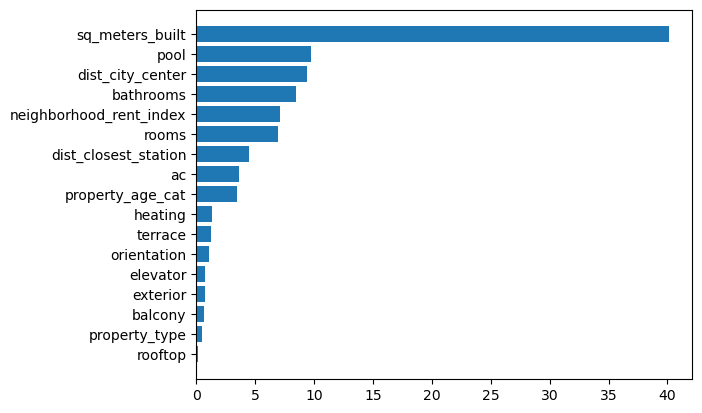

In [171]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y = 'Features'
        , width = 'Importance'
        , data = cat_importance)
ax.invert_yaxis()  # labels read top-to-bottom

Vemos cómo el tamaño del piso marca los resultados del modelo

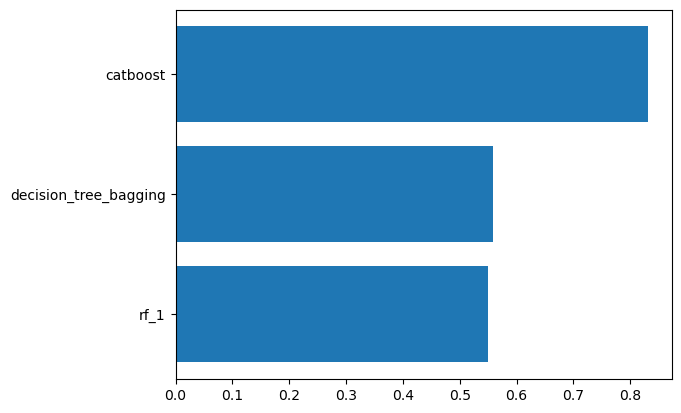

In [172]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(data=results.sort_values('r2_validation', ascending=False)
        , y = 'model'
        , width = 'r2_validation')
ax.invert_yaxis()  # labels read top-to-bottom